<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Permeability_one%20porosity_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [2]:
!pip install GitPython
from git import Repo
# !git clone https://github.com/MariiaKalinina/Elasticity.git
!git clone https://github.com/MariiaKalinina/Elasticity.git NewElasticity_v1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.3 MB/s eta 0:00:00
Cloning into 'NewElasticity_v1'...
remote: Enumerating objects: 502, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 502 (delta 193), reused 87 (delta 87), pack-reused 265 (from 1)
Receiving objects: 100% (502/502), 49.67 MiB | 7.17 MiB/s, done.
Resolving deltas: 100% (330/330), done.


In [3]:
path_to_ser = Path('/content/NewElasticity_v1/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties_data', skiprows=0)

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [6]:
data.dropna(subset=['AR thermal'], inplace=True)

In [7]:
data[:10]

Sample Well  \
0   113480    a   
1   113532    a   
2   113536    a   
3   113541    a   
4   113556    a   
5   113566    a   
6   113572    a   
7   113577    a   
9   113603    a   
10  113619    a   

                                                                                          Litholohy  \
0                               пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины   
1                                                                               пористо-кавернозный   
2                                                                               пористо-кавернозный   
3                                                                               пористо-кавернозный   
4                                                                               пористо-кавернозный   
5                                                                               пористо-кавернозный   
6                                                                               пористо-кавернозный   
7                                пористо-кавернозный, частично перекристаллизованный, скол на торце   
9   пористо-кавернозный, частично перекристаллизованный, неравномерная пористость, открытые трещины   
10                                                                              пористо-кавернозный   

    Porosity,%  Permeability  Density (water)  Density (oil)    Vp air    Vs air    Vp oil  \
0     4.524900      0.832741         2.572247       2.576227  5.037000  2.360000  5.564425   
1     6.473371      0.253703         2.537162       2.529374  4.042333  2.427667  5.173550   
2    15.024288     18.334600         2.285245       2.297374  3.514333  1.997000  4.103260   
3    14.192654     17.343900         2.326067       2.319278  3.241000  1.837667  3.971235   
4     9.432966     15.777000         2.459785       2.445896  3.798667  2.336333  4.759910   
5     9.294073     79.117000         2.462813       2.453298  3.756667  2.222333  4.699830   
6     8.824133     32.488200         2.473036       2.462001  3.847333  2.278000  5.103325   
7     7.476561      1.130080         2.514214       2.506365  3.716667  2.083333  4.972040   
9     6.812695      0.399309         2.538758       2.535101  4.065667  2.212000  5.177195   
10    8.326070      2.446320         2.478543       2.476065  4.154333  2.432000  4.983580   

      Vs oil  Vp water  Vs water  Unnamed: 14  AR thermal  AO electrical  Unnamed: 17  \
0   3.019440    5.2945    2.6495          NaN    0.066681       0.069183          NaN   
1   2.849075    5.0545    2.6650          NaN    0.134276       0.087096          NaN   
2   2.256210    4.0285    2.2330          NaN    0.131826       0.104713          NaN   
3   2.164210    3.8155    2.0285          NaN    0.122462       0.095499          NaN   
4   2.564645    4.8270    2.5030          NaN    0.081658       0.072444          NaN   
5   2.492100    4.8885    2.7235          NaN    0.144544       0.063096          NaN   
6   2.809800    4.9355    2.6325          NaN    0.149968       0.072444          NaN   
7   2.834515    4.8885    2.5050          NaN    0.120226       0.079433          NaN   
9   2.813970    4.9000    2.4710          NaN    0.158489       0.069183          NaN   
10  2.704390    4.9835    2.5480          NaN    0.124738       0.071340          NaN   

    Unnamed: 18    TC air    TC oil    TC 0,6      TC 6     TC 60    TC 180  
0           NaN  2.472888  2.668885       NaN  2.740225  2.966438  2.852613  
1           NaN  2.404575  2.600888  2.745500  2.741125  2.857375  2.834588  
2           NaN  1.858550  2.234582  2.535225  2.514712  2.630950  2.677875  
3           NaN  1.867175  2.286873  2.619337  2.604425  2.728613  2.715700  
4           NaN  2.123563  2.400862  2.661125  2.623087  2.823100  2.718675  
5           NaN  2.244775  2.456700  2.659225  2.679425  2.746012  2.825363  
6           NaN  2.267150  2.526250  2.644188  2.700200  2.843925  2.802163  
7           NaN  2.29

In [8]:
df_ues['Permeability'].min(), df_ues['Permeability'].max()

(0.0169466, 2393.99)

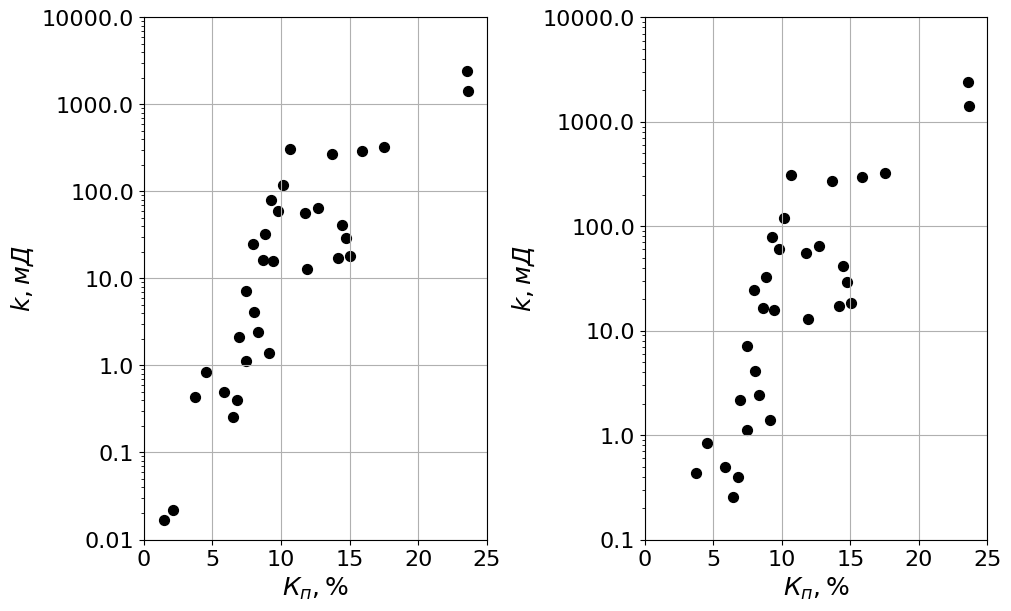

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
# layout='constrained'
# fig.tight_layout(pad=0.001000)
axs = fig.subplots(1, 2,  sharex=False)

ticks_size, label_size = 16, 18

        ### Porosity VS Permeability (all samples)
x_value, y_value = "Porosity,%", "Permeability"

  ### INPUT DATA
axs[0].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[0].set_xscale("linear")
axs[0].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[0].set_xlim([0, 25])
axs[0].set_xticks(np.arange(0, 26, 5))
axs[0].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[0].set_yscale('log', base=10)
axs[0].grid(which='major', axis='both', linestyle='-')

axs[0].set_yscale('log')
axs[0].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[0].set_ylim([10**-2, 10**4])
axs[0].set_yticks(np.logspace(-2, 4, num=7))
axs[0].set_yticklabels(np.logspace(-2, 4, num=7), fontsize=ticks_size)



  ### INPUT DATA - 2
axs[1].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[1].set_xscale("linear")
axs[1].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[1].set_xlim([0, 25])
axs[1].set_xticks(np.arange(0, 26, 5))
axs[1].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[1].set_yscale('log', base=10)
axs[1].grid(which='major', axis='both', linestyle='-')

axs[1].set_yscale('log')
axs[1].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[1].set_ylim([10**-1, 10**4])
axs[1].set_yticks(np.logspace(-1, 4, num=6))
axs[1].set_yticklabels(np.logspace(-1, 4, num=6), fontsize=ticks_size)


plt.show()

### Границы ХШ

In [10]:
def Upper_Hashin_Strikman(phi, lam):
    L0 = max(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    # print('TC Upper Hashin-Strikman:', L_eff)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    L0 = min(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    return L_eff

def Average_Hashin_Strikman(phi, lam):
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])

# Self-consistent (GSA)

ОСП - теплопроводность, проницаемость

In [11]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0
#     print('Эффективное значение TC_eff:', raschet(L0))


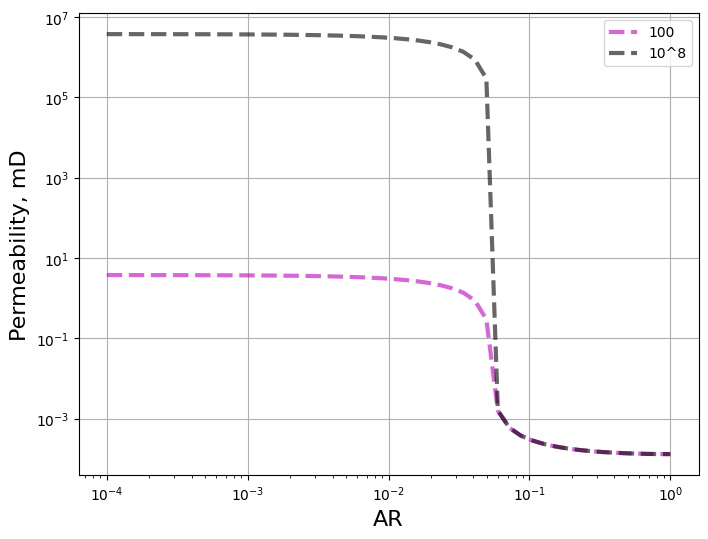

In [ ]:
ar_inclusion_list = np.logspace(-4, 0, num=50, base=10)
porosity = 0.08

calculation_perm_1, calculation_perm_2 =[], []

for ar_inclusion in ar_inclusion_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_inclusion]
  calculation_perm_1.append(effective_tc(conc, alpha_shape, [10**-4, 10**2]))
  calculation_perm_2.append(effective_tc(conc, alpha_shape, [10**-4, 10**8]))

fig, axs = plt.subplots(figsize=(8, 6))
axs.plot(ar_inclusion_list, calculation_perm_1, 'm--', lw=3, alpha=0.6, label='100')
axs.plot(ar_inclusion_list, calculation_perm_2, 'k--', lw=3, alpha=0.6, label='10^8')
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability, mD', fontsize=16)
axs.set_xlabel('AR', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

Анализ чувствительности «Матричная» проницаемость к АО пор (оценка по диапазону АО, инвертированному по теплопроводности: 0.07-0.28)

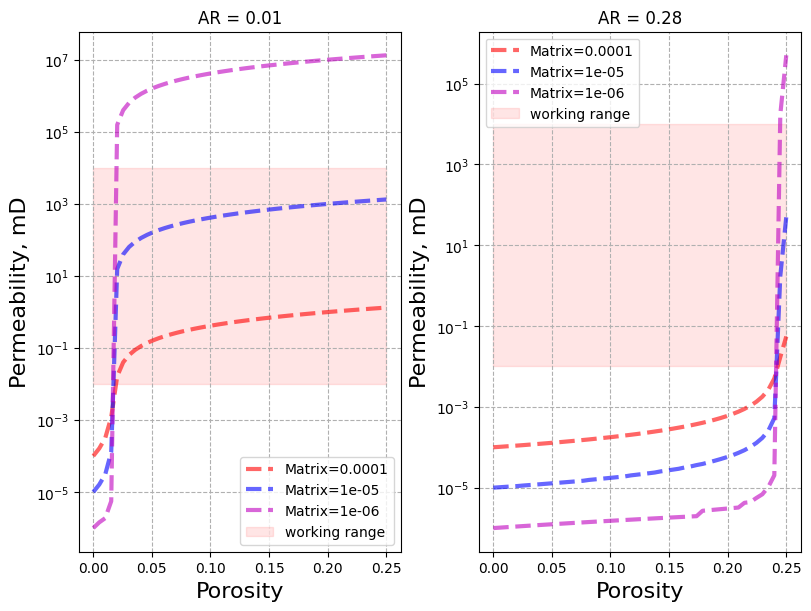

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity

    alpha_shape = [1, ar_fluid]

    mlam = [10**-4, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-5, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-6, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

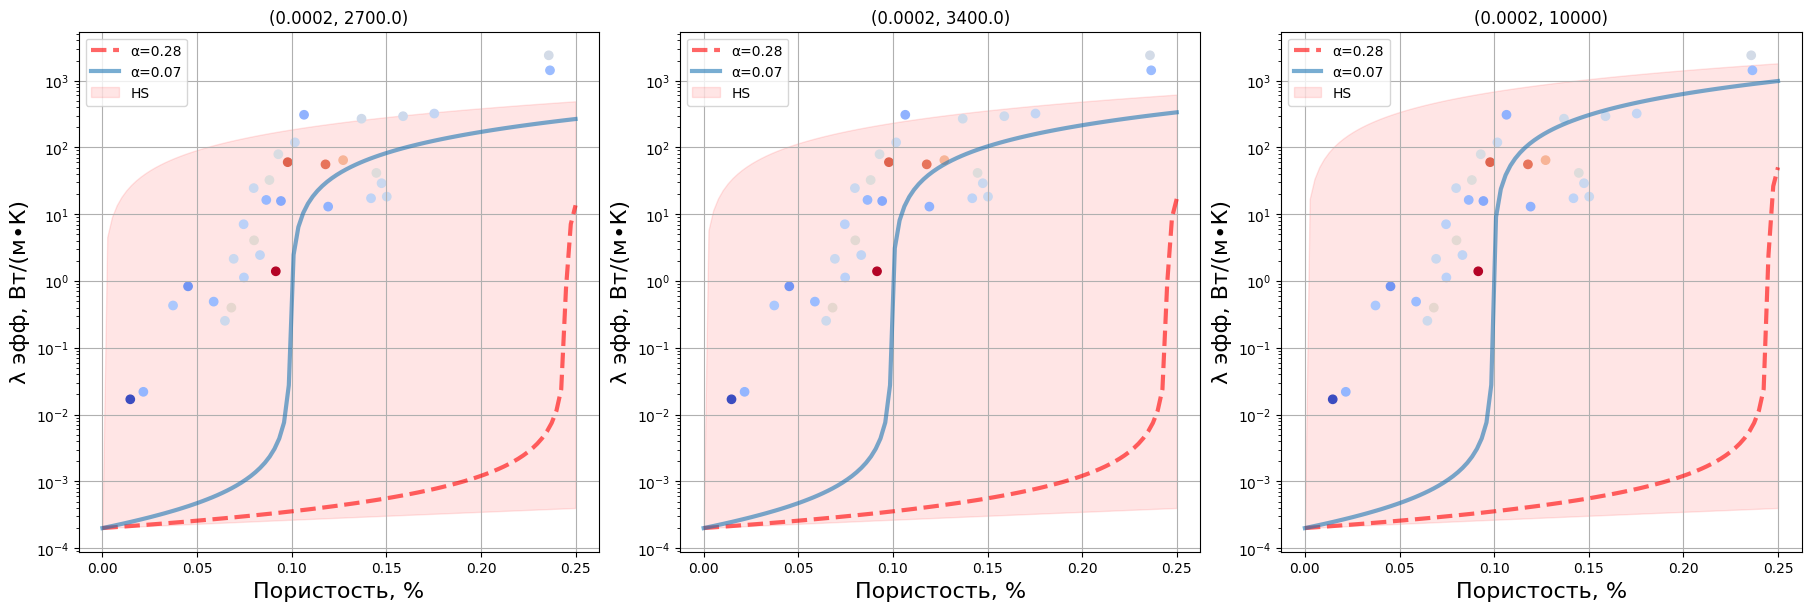

In [ ]:

fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 2.7*1000),
              (mtrx_perm, 3.4*1000),
              (mtrx_perm, 10**4)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

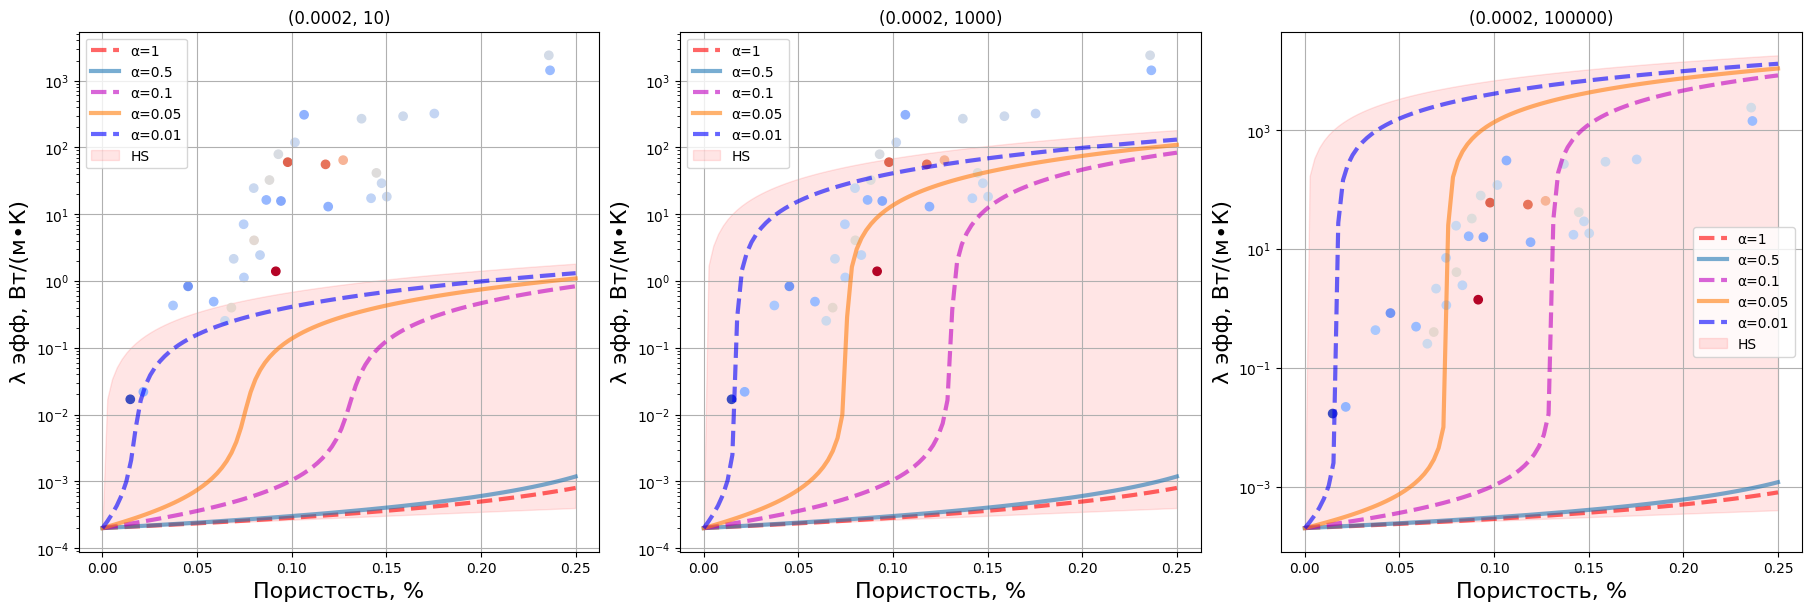

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**1),
              (mtrx_perm, 10**3),
              (mtrx_perm, 10**5)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 1]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.5]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    alpha_shape = [1, 0.1]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.05]
    for i in por:
        conc = [1-i, i]
        ar1.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.01]
    for i in por:
        conc = [1-i, i]
        ar2.append(effective_tc(conc, alpha_shape, mlam))

    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=1')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.5')
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label='α=0.1')
    ax.plot(por, ar1, lw=3, alpha=0.6, label='α=0.05')
    ax.plot(por, ar2,'b--', lw=3, alpha=0.6, label='α=0.01')




    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

Решение обратной задачи

In [ ]:
idx = 0
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]/3
mtrx_perm = 2*10**-4

In [ ]:
porosity, exp_permeability, ar_pore, ar_pore_initial

(0.045249, 0.832741, 0.022227, 0.066681)

In [ ]:
fluid_perm_list = np.logspace(1, 5, num=40, base=10)

calculation_perm =[]

for fluid_comp_perm in fluid_perm_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_pore]
  components = [mtrx_perm, fluid_comp_perm]
  calculation_perm.append(effective_tc(conc, alpha_shape, components))

In [ ]:

results = pd.DataFrame()
results['Fluid perm'] = fluid_perm_list
results['Calculatioin perm'] = calculation_perm

results['Diff'] = results['Calculatioin perm'].apply(lambda x: abs(np.round((x-exp_permeability)/exp_permeability*100, 2)))

In [ ]:
results = results.sort_values(by=f'Diff')

In [ ]:
results[:3]

Fluid perm  Calculatioin perm   Diff
13  215.443469           0.928042  11.44
12  170.125428           0.733142  11.96
11  134.339933           0.579238  30.44

### Вывод

## Анализ чувствительности
Рассматривая диапазон изменения проницаемости (k) от $10^{-2}$ до $10^{4}$ мД, изменения $k_{matrix}$ не влияют на эффективное значение, поэтому используем одно фиксированное значение $k_{matrix}$=0.0002 мД из уравнения регресиии "Пористость - Пронициемость".

$k_{fluid}$ в большей степени влияет на эффективное значение, однако начиная с $k_{fluid}$ > $10^{6}$, эффективное значение для $AR_{thermal}$: 0.07 - 0.28 не изменяется. Поэтому рассматриваем $k_{fluid}$ в диапазоне от $10^{0}$ до $10^{6}$ мД.

Рассчитать эффективную проницаемость с использованием $AR_{thermal}$: 0.07 - 0.28 не удалось. Если смотреть на анализ чувствительности, то видно, что кривые для разных $AR_{thermal}$ не попадают на экспериментальные значениея проницаемости. Однако, если занизить систематически $AR_{thermal}$ в 3 раза и больше (т.е. $AR_{thermal}$: 0.01 - 0.05), то можно получить приемлемые решения (погрешность 10%) для эффективного k.

Можно ли вообще использовать модель ОСП? Очень странное поведение модели: уменьшение эффективной проницаемости с увеличением АО, при этом на маленьких АО, эффективная проницаемость растет

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [ ]:
data_ml = data[['Porosity,%', 'AR thermal', 'TC air','TC oil', 'TC 6', 'TC 60', 'TC 180', 'Permeability']]
data_ml.dropna(inplace=True)

target = data_ml ['Permeability']

<ipython-input-23-35f8357ce9db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.dropna(inplace=True)


In [ ]:
### BEGIN Solution (do not delete this comment)
X, y = data_ml.iloc[:, :-1], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0xC0FFEE)
### END Solution (do not delete this comment)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features =list(X.columns)

X_train[features] = scaler.fit_transform(X_train[list(features)])
X_test[features] = scaler.fit_transform(X_test[list(features)])

In [ ]:
### BEGIN Solution

lin_reg = []

MODELS = {
    "Linear Regression": LinearRegression(),
    "Ridge regression" : Ridge(),
    "DecisionTree" : DecisionTreeRegressor()
}

for name, model in MODELS.items():
  clf = model.fit(X_train,y_train)

  y_pred = clf.predict(X_train)
  print(f'Trian RMSL {name}: {mse(y_train, y_pred):.2f}')

  if name=='Linear Regression':
    y_pred = clf.predict(X_test)
    lin_reg = y_pred

  y_pred = clf.predict(X_test)
  print(f'Test RMSL {name}: {mse(y_test, y_pred):.2f}', end='\n\n')

### END Solution

Trian RMSL Linear Regression: 2390.56
Test RMSL Linear Regression: 633942.79

Trian RMSL Ridge regression: 3105.12
Test RMSL Ridge regression: 682398.18

Trian RMSL DecisionTree: 0.00
Test RMSL DecisionTree: 601346.13



In [ ]:
clf = LinearRegression().fit(X_train,y_train)
lin = clf.predict(X)

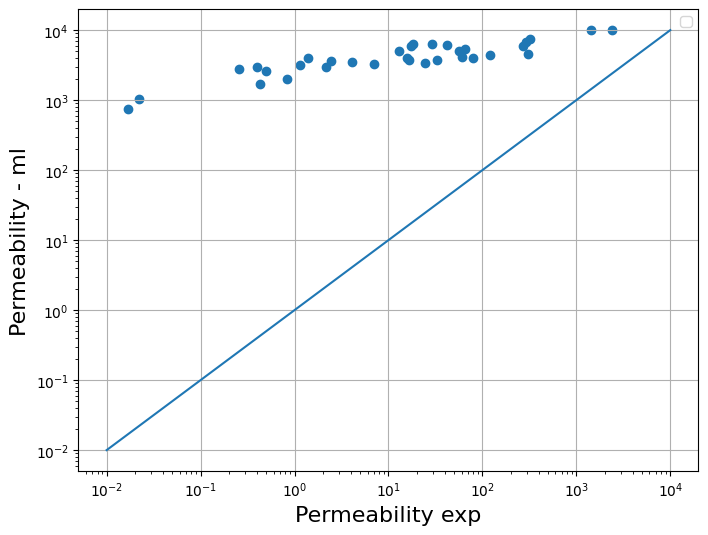

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6))
axs.scatter(target, lin)
axs.plot([10**-2, 10**4], [10**-2, 10**4])
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability - ml', fontsize=16)
axs.set_xlabel('Permeability exp', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

# f-модель

In [12]:
def effective_tc_f(conc, alpha_shape, lam, f):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]*(1-f) + lam[1]*f

    parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

    for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all # числитель
        t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

        parall_comp.append(t16)  # числитель формулы (матрица, флюид)
        perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

    L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
    return L_eff

### Plot "Porosity - Thermal conductivity with dependecence from f'

In [ ]:
N, n = 100, 6

for f in np.linspace(0, 1, n):

  eff_tc = []

  for porosity in np.linspace(0, 0.1, N):

    conc = [1-porosity, porosity]
    alpha_shape = [1, 10**-2]
    # mlam = [4.00*10**-2, 18.7]
    mlam = [1.82*10**-3, 1.06]

    eff_tc.append(effective_tc_f(conc, alpha_shape, mlam, f))

  plt.plot(np.linspace(0, 1, N),  eff_tc, label=f"{np.round(f, 1)}")
  plt.legend()
plt.xlim(0,1)
# plt.ylim(0,3)
plt.yscale('log')
plt.grid()
plt.xlabel('porosity')
plt.ylabel('conductivity, Sm*m')
plt.title('Porosity - Resestivity with dependecence from f')


Text(0.5, 1.0, 'Porosity - Thermal conductivity with dependecence from f')

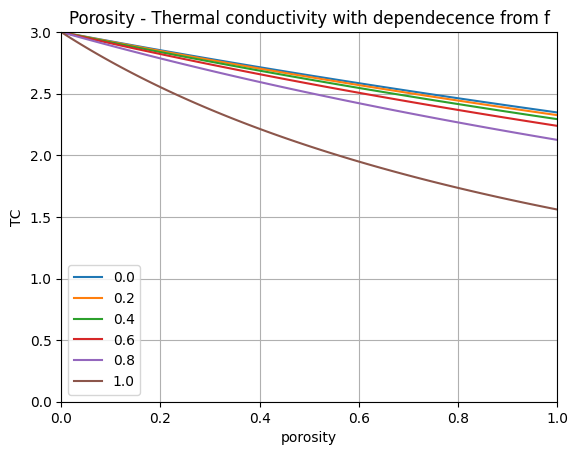

In [ ]:
N, n = 100, 6

for f in np.linspace(0, 1, n):

  eff_tc = []

  for porosity in np.linspace(0, 0.1, N):

    conc = [1-porosity, porosity]
    alpha_shape = [1, 10**-1]
    mlam = [3, 0.12]

    eff_tc.append(effective_tc_f(conc, alpha_shape, mlam, f))

  plt.plot(np.linspace(0, 1, N),  eff_tc, label=f"{np.round(f, 1)}")
  plt.legend()
plt.xlim(0,1)
plt.ylim(0,3)
plt.xlabel('porosity')
plt.ylabel('TC')
plt.grid()
plt.title('Porosity - Thermal conductivity with dependecence from f')


In [ ]:
conc = [1-0.045249, 0.045249]
alpha_shape = [1, 0.04862601580065353]
lam = [3.0975, 0.025]
f = 0.3684210526315789

effective_tc_f(conc, alpha_shape, lam, f)

2.4558010598757014

In [ ]:
3/np.linspace(10**-2, 10**2, 10)

array([3.00000000e+02, 2.69784173e-01, 1.34952767e-01, 8.99820036e-02,
       6.74915636e-02, 5.39956803e-02, 4.49977501e-02, 3.85703266e-02,
       3.37495781e-02, 3.00000000e-02])

In [ ]:
3/0.025, 3/0.12, 3/0.60

(120.0, 25.0, 5.0)

Text(0.5, 1.0, 'Porosity - Thermal conductivity with dependecence from f, Ar=0.0001, e=238.73241463784305')

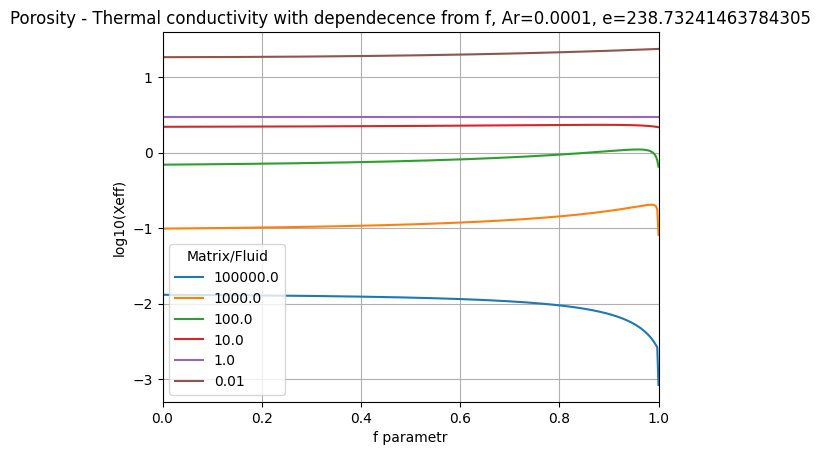

In [ ]:
N, n = 4, 400

matrix = 3
fluid = [3*10**-5, 3*10**-3, 0.03, 3*10**-1, 3*10**0, 3*10**2]
porosity = 10/100
ar = 10**-4
e=3*porosity/(4*pi*ar)

for fluid_comp in fluid:

  eff_tc = []
  m2fluid = []

  for f in np.logspace(-1, 0, n, base=10):

    conc = [1-porosity, porosity]
    alpha_shape = [1, ar]
    mlam = [matrix, fluid_comp]

    eff_tc.append(effective_tc_f(conc, alpha_shape, mlam, f))
    m2fluid.append(matrix/fluid_comp)

  plt.plot(np.linspace(0, 1, n),  np.log10(eff_tc), label=f"{np.round(matrix/fluid_comp, 3)}")
  plt.legend(title='Matrix/Fluid')
plt.xlim(0,1)
# plt.ylim(0,1)
plt.ylabel('log10(Xeff)')
plt.xlabel('f parametr')
plt.grid()
plt.title(f'Porosity - Thermal conductivity with dependecence from f, Ar={alpha_shape[1]}, e={e}')

In [ ]:
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

density_air, density_water, density_oil = p_air, p_water, p_oil

K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

In [ ]:
K_air_mtrx/K_air, Mu_air_mtrx/Mu_air

(53913733.666666664, 27232519.0)

In [ ]:
K_water_mtrx/K_water, Mu_water_mtrx/Mu_water

(28.29669585185185, 2.8624375000000003e+21)

In [ ]:
lam_6, lam_60, lam_180 = 1.060, 8.42, 18.87
lam_mtrx_6, lam_mtrx_60, lam_mtrx_180 = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

In [ ]:
lam_mtrx_6/lam_6, lam_mtrx_60/lam_60, lam_mtrx_180/lam_180, lam_6/lam_mtrx_6, lam_180/lam_mtrx_180

(0.0017169811320754717,
 0.0016983372921615203,
 0.0021197668256491787,
 582.4175824175825,
 471.75)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, y, z are your data arrays
x = np.linspace(0, 1, 100)
y = np.logspace(-4, 0, 100, base=10)
z = 3 * x / (4 * np.pi * y)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a surface
surf = ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)

# Set labels and title
ax.set_xlabel('Porosity')
ax.set_ylabel('log(AR)')
ax.set_zlabel('e')



# Adjust viewing angle
# ax.view_init(azim=40)

plt.show()

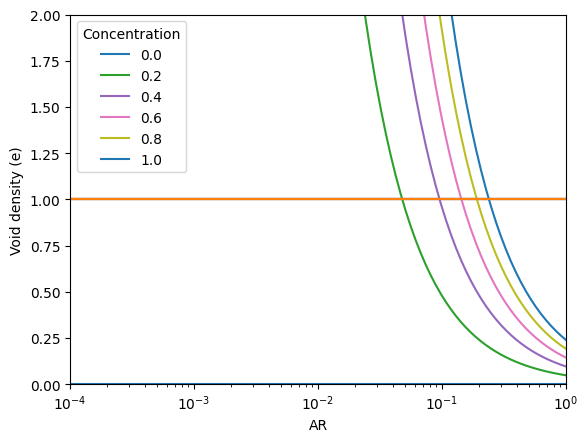

In [ ]:
for porosity in np.linspace(0, 1, 6):

  e_list = []

  for ar in np.logspace(-4, 0, 100, base=10):
      e = 3 * porosity / (4 * np.pi * ar)
      e_list.append(e)

  plt.plot(np.logspace(-4, 0, 100, base=10), e_list, label=f'{np.round(porosity, 2)}')
  plt.plot((10**-4, 10**0), (1, 1))
  plt.xscale('log')
  plt.ylim(0,2)
  plt.xlim(10**-4, 10**0)

  plt.xlabel('AR')
  plt.ylabel('Void density (e)')
  plt.legend(title='Concentration')

In [ ]:
# for porosity in np.linspace(0, 0.25, 3):
for porosity in [0.05, 0.1, 0.15, 0.2, 0.25]:

  e_list = []

  for ar in np.logspace(-4, 0, 100, base=10):
      e = 3 * porosity / (4 * np.pi * ar)
      e_list.append(e)

  plt.plot(np.logspace(-4, 0, 100, base=10), e_list, label=f'{porosity}')
  plt.plot((10**-4, 10**0), (1, 1))
  plt.xscale('log')
  plt.ylim(0,2)
  plt.xlim(10**-4, 10**0)

  plt.xlabel('AR')
  plt.ylabel('Void density (e)')
  plt.legend()

### Sensetive study

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)

ar = 0.13
lam_matrix = 10**-4

lam_fluid=[10**2, 10**4]

for ax, l_fluid in zip(axs,lam_fluid):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    list1, list2, list3 = [], [], []
    por = porosity

    alpha_shape = [1, ar]

    mlam = [lam_matrix, l_fluid]

    f=0.05
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'f={f}')

    f=0.1
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'f={f}')

    f=0.15
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'f={f}')


    f=0.2
    for i in por:
        conc = [1-i, i]
        list1.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list1, lw=3, alpha=0.6, label=f'f={f}')


    f=0.4
    for i in por:
        conc = [1-i, i]
        list2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list2, lw=3, alpha=0.6, label=f'f={f}')


    f=0.6
    for i in por:
        conc = [1-i, i]
        list3.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, list3, lw=3, alpha=0.6, label=f'f={f}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    ax.set_ylim([10**0, 10**4])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'ki fluid = {l_fluid}, AR=0.13')

plt.show()

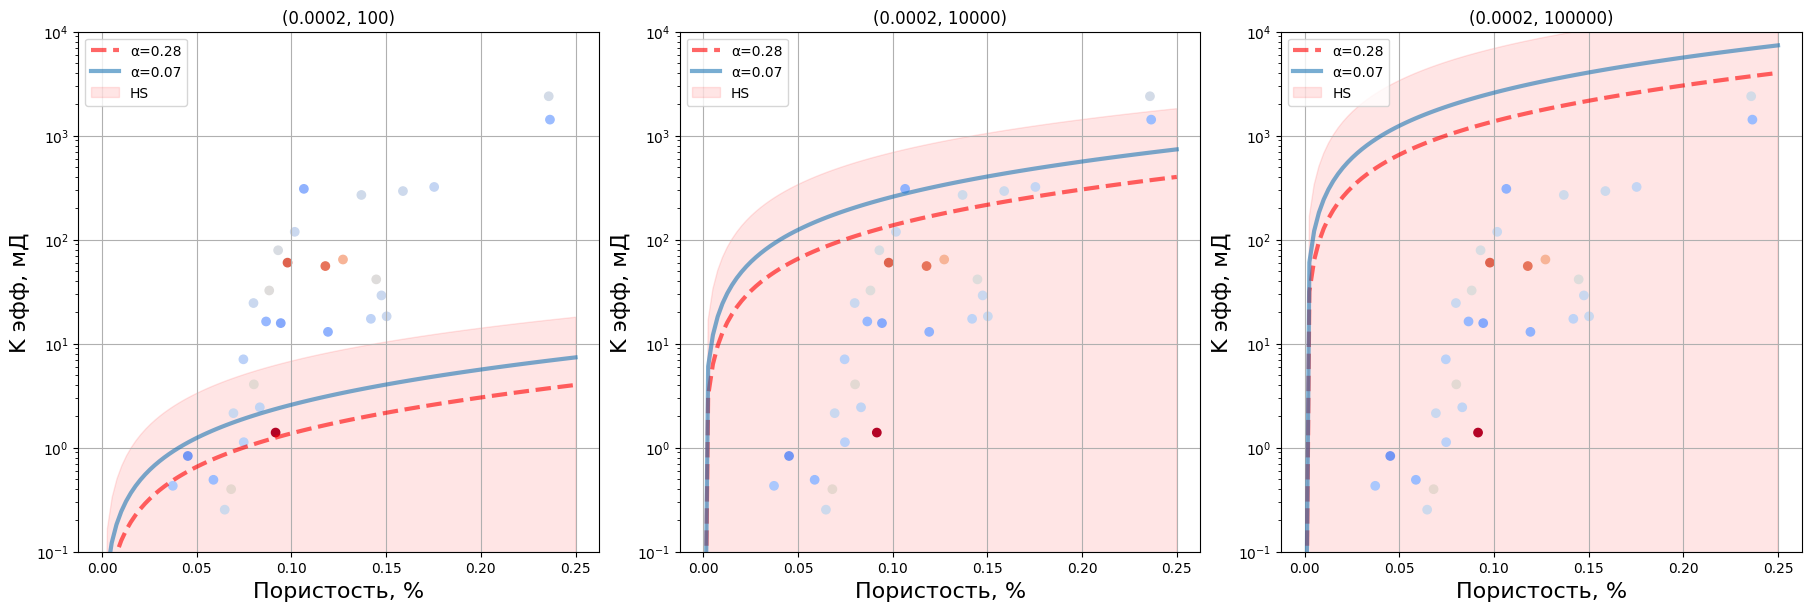

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**2),
              (mtrx_perm, 10**4),
              (mtrx_perm, 10**5)]

f=0.05

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('K эфф, мД', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    ax.set_ylim([10**-1, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

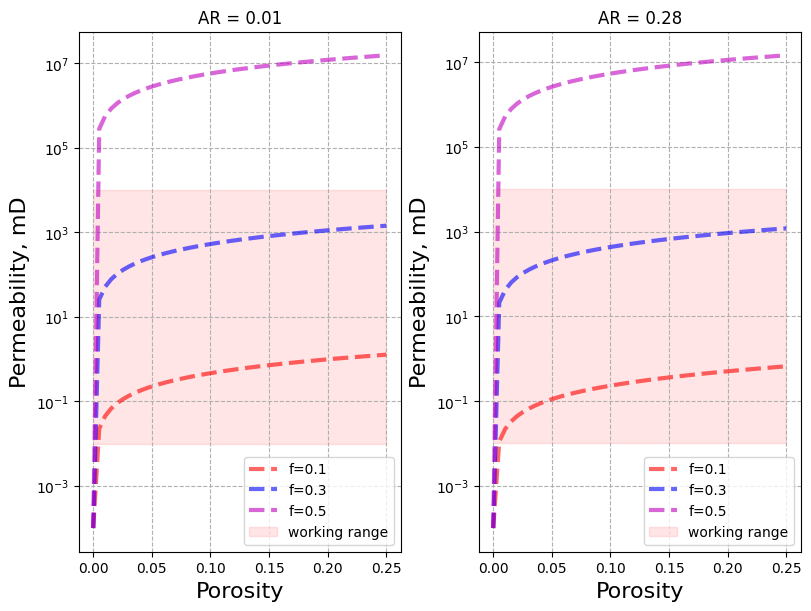

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)
matrix = 10**-4

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):


    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity
    alpha_shape = [1, ar_fluid]

    f = 0.1
    mlam = [matrix, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.3
    mlam = [matrix, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.5
    mlam = [matrix, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'f={f}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

### Inverse problem

In [ ]:
path_to_ser = Path('/content/NewElasticity_v1/f model.xlsx')
df_ues = pd.read_excel(path_to_ser,skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
idx = 27
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]
mtrx_perm = 2*10**-4

In [ ]:
print(porosity,ar_pore)

0.014711499999999999 0.022491


In [ ]:
### Ограничение на максимальное значение параметр связаности f через уравнение уравнение Козени– Кармана, о связи пористости и проницаемости
kmin, kmax, kreal = 0.0169466, 2393.99, exp_permeability
fmax = 1 - (np.log(kmax/kreal)/np.log(kmax/kmin))
print(f"fmax: {np.round(fmax, 2)}")
print(f"k/φ {np.round(kreal/porosity, 2)}")

fmax: 0.0
k/φ 1.15


In [ ]:
N = 200
fluid_perm_list = []
# f_list = np.linspace(0., fmax, N)
f_list = []
calculation_perm =[]

for fluid_comp_perm in np.logspace(1, 5, num=N, base=10):
  for f in np.linspace(0., 1, N):
    conc = [1-porosity, porosity]
    alpha_shape = [1, ar_pore]
    components = [mtrx_perm, fluid_comp_perm]
    calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))
    fluid_perm_list.append(fluid_comp_perm)
    f_list.append(f)

In [ ]:
results = pd.DataFrame()
results[f'Sample_{idx}'] = [data["Sample"][idx]]*N**2
results[f'Porosity_{idx}'] = [data["Porosity,%"][idx]]*N**2
results[f'Fluid perm_{idx}'] = fluid_perm_list
results[f'f_{idx}'] = f_list

results[f'Calculatioin perm_{idx}'] = calculation_perm
results[f'Expermental_{idx}'] = [exp_permeability]*len(calculation_perm)

### Байссовский подход
results[f'Diff_{idx}'] = abs((results[f'Calculatioin perm_{idx}'] - results[f'Expermental_{idx}'])/results[f'Expermental_{idx}']*100)
results['p(B|Ai)'] = np.exp(-results[f'Diff_{idx}']**2)
results['p(Ai|b)'] = np.exp(-results[f'Diff_{idx}']**2) / np.sum(results['p(B|Ai)'])

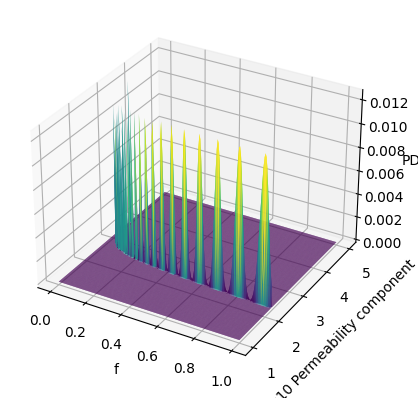

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming x, y, z are your data arrays
x = results[f'f_{idx}']
y = np.log10(results[f'Fluid perm_{idx}'])
z = results['p(Ai|b)']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a surface
surf = ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)

# Set labels and title
ax.set_xlabel('f')
ax.set_ylabel('Lg10 Permeability component')
ax.set_zlabel('PDF')

plt.show()

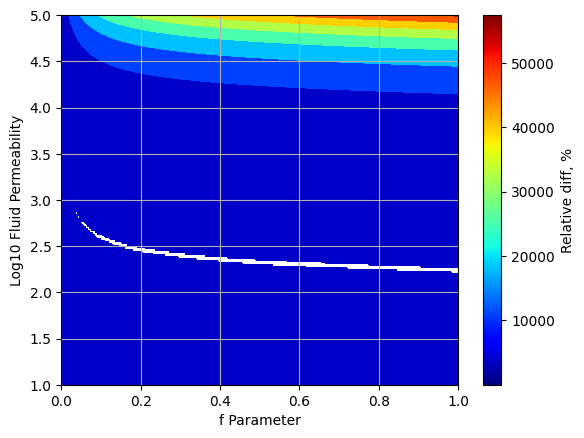

In [ ]:
scatter = plt.scatter(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']),
                      c=results[f'Diff_{idx}'], cmap='jet', marker='o')


masked_diff_filled = np.where(results[f'Diff_{idx}'] < 8, -1, results[f'Diff_{idx}'])
cmap = plt.cm.jet
cmap.set_under('white')  # Set the color for the value -1 to white
contour = plt.tricontourf(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), masked_diff_filled, cmap=cmap, vmin=-1)

plt.xlabel('f Parameter')
plt.ylabel('Log10 Fluid Permeability')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative diff, %')

plt.xlim(0, 1)
plt.ylim(1, 5)

plt.grid()

plt.show()

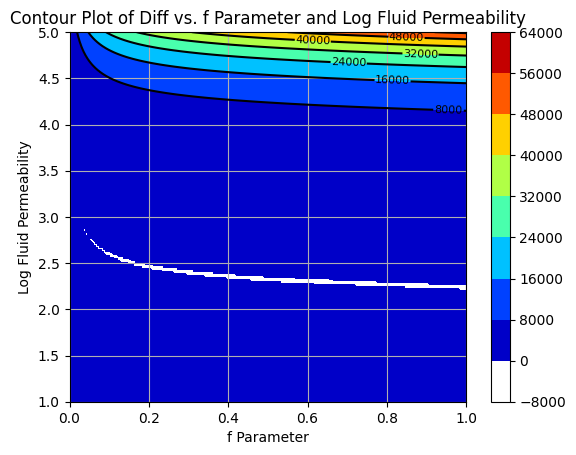

In [ ]:
# plt.figure(figsize=(8, 6))
masked_diff_filled = np.where(results[f'Diff_{idx}'] < 8, -1, results[f'Diff_{idx}'])


cmap = plt.cm.jet
cmap.set_under('white')  # Set the color for the value -1 to white

contour = plt.tricontourf(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), masked_diff_filled, cmap=cmap, vmin=-1)


contour_lines = plt.tricontour(results[f'f_{idx}'], np.log10(results[f'Fluid perm_{idx}']), results[f'Diff_{idx}'], colors='k')
plt.clabel(contour_lines, inline=True, fontsize=8)  # Add labels to the isolines


plt.colorbar(contour)

plt.xlabel('f Parameter')
plt.ylabel('Log Fluid Permeability')
plt.title('Contour Plot of Diff vs. f Parameter and Log Fluid Permeability')
plt.grid(True)
plt.show()

In [ ]:
results = results.sort_values(by=f'Diff_{idx}')
filtered_results = results[results[f'Diff_{idx}'] < 8]
# Save the filtered results to an Excel file
filtered_results.to_excel(f'{data["Sample"][idx]}_{idx}.xlsx', index=False)
# filtered_results.to_csv(f'{data["Sample"][idx]}.csv', index=False)  # This will save the DataFrame to a CSV file without including the index

In [ ]:
filtered_results[:5]

Sample_2  Porosity_2  Fluid perm_2       f_2  Calculatioin perm_2  Expermental_2    Diff_2  \
12590    113536   15.024288    176.291412  0.954774            18.334146        18.3346  0.002476   
15228    113536   15.024288    337.006433  0.140704            18.333369        18.3346  0.006712   
13488    113536   15.024288    222.194686  0.442211            18.340447        18.3346  0.031888   
12939    113536   15.024288    193.389175  0.698492            18.325931        18.3346  0.047283   
13119    113536   15.024288    202.550194  0.597990            18.323945        18.3346  0.058113   

        p(B|Ai)   p(Ai|b)  
12590  0.999994  0.012575  
15228  0.999955  0.012575  
13488  0.998984  0.012562  
12939  0.997767  0.012547  
13119  0.996629  0.012533

Text(0.5, 0, 'Ki components, mD')

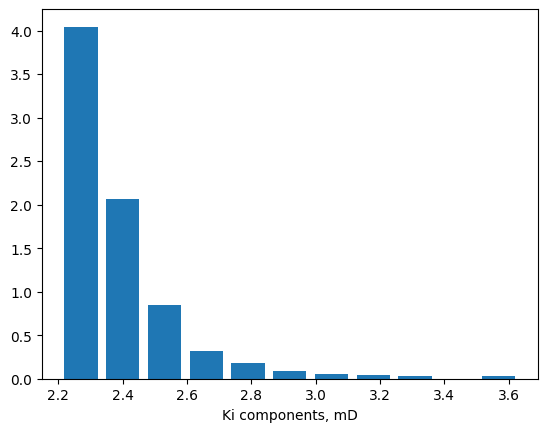

In [ ]:
plt.hist(np.log10(filtered_results[f'Fluid perm_{idx}']), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)
plt.xlabel('Ki components, mD')

Text(0.5, 0, 'f parametr')

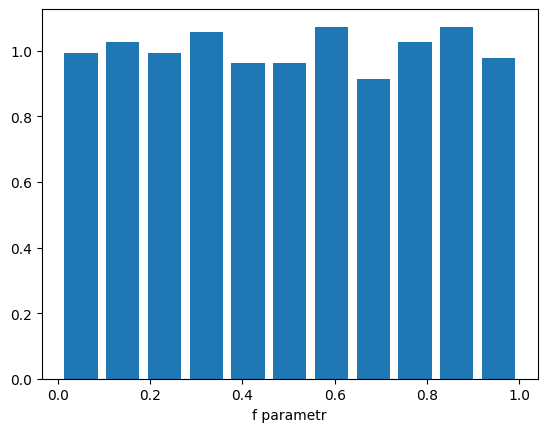

In [ ]:
plt.hist((filtered_results[f'f_{idx}']), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)
plt.xlabel('f parametr')

### Расчет параметра f через плотность трещин при разной пористости (по статье Березиной)

In [ ]:
def f_from_e(phi, alpha): #https://doi.org/10.3390/app121910185 - Berezina and Bayuk, 2022

  f = 0
  e = 3*phi/100/(4*np.pi*alpha)

  if phi <= 2:
    if np.log10(e) >= -3.5:
      f = 0.04*np.log10(e**2)+0.51*np.log10(e)+1.30
      print(f)
    else:
      f = 0.15

  elif phi > 2 and phi <=5:
    if np.log10(e) >= -3.0:
      f = 0.07*np.log10(e**2)+0.56*np.log10(e)+1.18
    else:
      f = 0.18

  elif phi > 5 and phi <=10:
    if np.log10(e) >= -3.0:
      f = 0.09*np.log10(e)**2+0.56*np.log10(e)+1.10
    else:
      f = 0.20

  elif phi > 10 and phi <=15:
    if np.log10(e) >= -2.5:
      f = 0.10*np.log10(e)**2+0.54*np.log10(e)+1.07
    else:
      f = 0.30

  elif phi > 15 and phi <=20:
    if np.log10(e) >= -2.0:
      f = 0.07*np.log10(e)**2+0.42*np.log10(e)+1.01
    else:
      f = 0.40

  return f

9.789559467455616 0.242103 0.6241973988096589


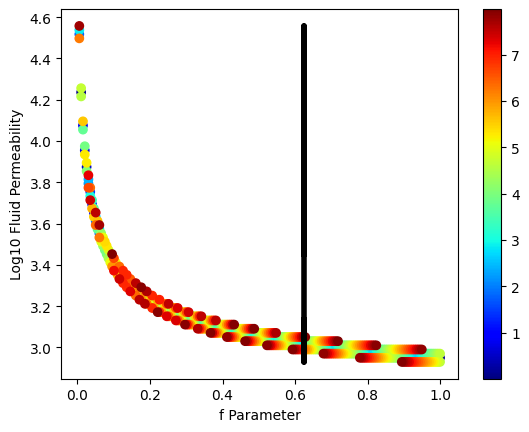

In [ ]:
scatter = plt.scatter(filtered_results[f'f_{idx}'], np.log10(filtered_results[f'Fluid perm_{idx}']),
                      c=filtered_results[f'Diff_{idx}'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('f Parameter')
plt.ylabel('Log10 Fluid Permeability')


porosity = data["Porosity,%"][idx]
ar_pore = data['AR thermal'][idx]
f = f_from_e(porosity, ar_pore)

print(porosity,ar_pore, f)

f_list = [f for _ in range(len(filtered_results[f'f_{idx}']))]
plt.plot(f_list,  np.log10(filtered_results[f'Fluid perm_{idx}']), color='black', lw=4)


3.5611613848643877 0.22102335086940447


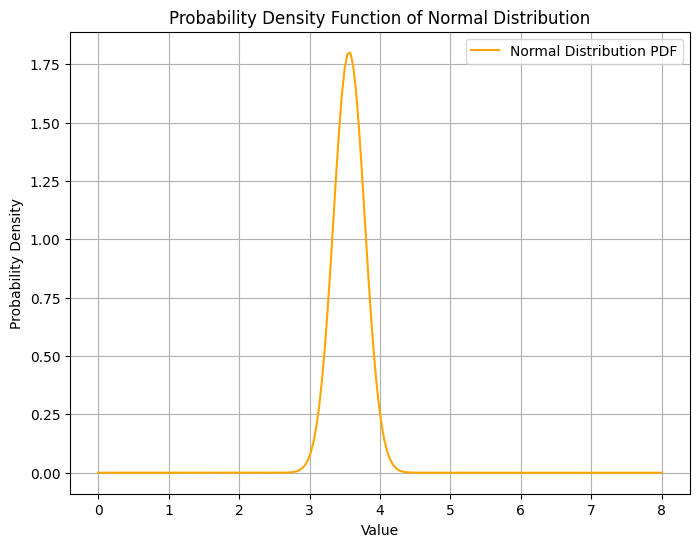

In [ ]:
from scipy.stats import norm

# Parameters of the normal distribution
data = data = np.log10(filtered_results[f'Fluid perm_{idx}'])
mean = np.mean(data)
std_dev = np.std(data)
print(mean, std_dev)

# Generate data points for the PDF
x = np.linspace(0, 8, 200)
pdf = norm.pdf(x, mean, std_dev)

plt.figure(figsize=(8, 6))

plt.plot(x, pdf, label='Normal Distribution PDF', color='orange')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function of Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()

### Direct problem with selected parametrs for permeability

In [ ]:
path_to_ser = Path('/content/f model.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='Лист1 (2)', skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
# filtered_data = data[data[f"total diff {prop}"] < 20]
data = data.sort_values(by=f"Porosity,%")
data = data[(data[f"Porosity,%"] < 7) & (data[f"Porosity,%"] >= 0)]
data.dropna(subset=['Porosity,%',"crack porosity" ], inplace=True)

In [ ]:
porosity = data["Porosity,%"][0:len(data)+1]
print(len(porosity))
exp_permeability = data["Permeability"][0:len(data)+1]
# ar_pore_initial = data['AR thermal']
# ar_pore = data['AR thermal']
AR_cracks = data["AR inclusion"][0:len(data)+1]
cracks_porosity = data["crack porosity"][0:len(data)+1]
f_array = data["f"]
f = 0.5*10**-3


TC_array = data['TC air'][0:32] / ([2.95] * len(data["Porosity,%"][0:32]))
mtrx_perm = 2*10**-4
# fluid_comp =
# fluid_perm = 10**2.8
# f = 0.3

import math
calculation_perm =[]

# table = pd.DataFrame()
# table['f mean'] = all_means_f
# table['porosity'] = all_porosity
# table['K i'] = all_means_i


for ar_cracks, por, cracks_por, TC in zip(AR_cracks, porosity, cracks_porosity, TC_array):

  if math.isnan(cracks_por):
    pass

  else:
    por = por/100
    AR_pore = AR_mtrx = 1.0

    # cracks_por = 0.0001 * (por*100) ** 1.862

    cracks_por = -0.0696 * TC + 0.0629

    if cracks_por < 0:
      cracks_por = 10**-4


    ar_cracks = 0.0574 * cracks_por ** 0.5235
    conc = [1-por, por-cracks_por, cracks_por]


    alpha_shape = [AR_mtrx, AR_pore, ar_cracks]

    # fluid_perm = 10**(1.7*np.log(por*100)-0.6603)
    # f = 0.026
    fluid_perm = 10**(2.644 * np.exp(0.0361*(por*100)))


    components = [mtrx_perm, fluid_perm, fluid_perm]
    # f = f_from_e(por*100, ar)
    print(alpha_shape)
    calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))

8
[1.0, 1.0, 0.0005826783934839814]
[1.0, 1.0, 0.00046228722524826435]
[1.0, 1.0, 0.0019710370134248664]
[1.0, 1.0, 0.003413590501573819]
[1.0, 1.0, 0.003167716271316846]
[1.0, 1.0, 0.004000043481275726]
[1.0, 1.0, 0.004469803241162415]
[1.0, 1.0, 0.003913285545651757]


In [ ]:
results = pd.DataFrame()
results['Sample'] = data["Sample"][0:len(data)+1]
results['Porosity'] = data["Porosity,%"][0:len(data)+1]
results['Calculatioin perm log'] = (calculation_perm)[0:len(data)+1]
results['Expermental perm log'] = data["Permeability"][0:len(data)+1]
results['Expermental'] = np.log10(exp_permeability)[0:len(data)+1]
results['Calculatioin perm'] = np.log10(calculation_perm)[0:len(data)+1]
results['Expermental'] = np.log10(data["Permeability"][0:len(data)+1])


results['Abs Error'] = np.abs((results['Calculatioin perm'] - results['Expermental'])/results['Expermental']*100)
results['Relative Error'] = np.abs((results['Calculatioin perm'] - results['Expermental']) / results['Expermental']) * 100

In [ ]:
globals()[f'final_{f}'] = pd.DataFrame()
globals()[f'final_{f}']['Sample'] = results['Sample']
globals()[f'final_{f}']['Porosity'] = results['Porosity']
globals()[f'final_{f}'][f'Expermental_{f}'] = results['Expermental']
globals()[f'final_{f}'][f'Calculatioin_perm_{f}'] = results['Calculatioin perm']

In [ ]:
globals()[f'final_{f}']

Sample  Porosity  Expermental_0.0005  Calculatioin_perm_0.0005
27  129817.0  1.471150           -1.770917                 -1.497412
26  129750.0  2.162350           -1.658880                 -1.454491
25  129744.0  3.731300           -0.366437                 -0.636720
0   113480.0  4.524900           -0.079490                 -0.309282
32  129914.0  5.877850           -0.308544                 -0.160387
1   113532.0  6.473371           -0.595674                  0.009993
9   113603.0  6.812695           -0.398691                  0.098534
28  129822.0  6.934715            0.332178                  0.064414

[]

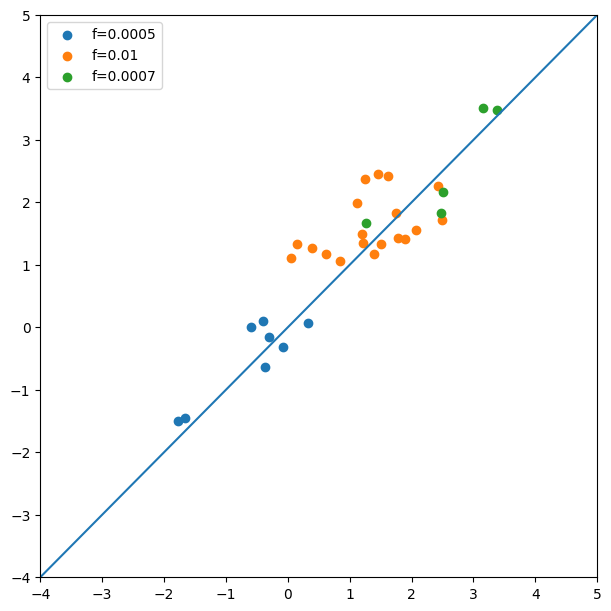

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)


data = globals()[f'final_{f}']
# ax.scatter(results['Expermental'], results['Calculatioin perm'])
# cracks_por = -0.0696 * TC + 0.0629
# scatter1 = plt.scatter(data['Expermental 0.01'], data[['Calculatioin perm 0.01']],
#                               c=data['Porosity'], cmap='jet', marker='o')
# scatter2 = plt.scatter(data['Expermental 1'], data[['Calculatioin perm 1']],
#                               c=data['Porosity'], cmap='seismic', marker='o')
# colorbar1 = plt.colorbar(scatter1)
# colorbar1.set_label('пористость ')
# plt.scatter(data['Expermental 0.014'], data[['Calculatioin perm 0.014']], label='f=0.014')

f = 0.5*10**-3
data = globals()[f'final_{f}']
plt.scatter(data[f'Expermental_{f}'], data[[f'Calculatioin_perm_{f}']], label=f'f={f}')

f = 10**-2
data = globals()[f'final_{f}']
plt.scatter(data[f'Expermental_{f}'], data[[f'Calculatioin_perm_{f}']], label=f'f={f}')

f = 0.7*10**-3
data = globals()[f'final_{f}']
plt.scatter(data[f'Expermental_{f}'], data[[f'Calculatioin_perm_{f}']], label=f'f={f}')
# plt.scatter(data['Expermental 0.12'], data[['Calculatioin perm 0.12']], label='f=0.12')
# ax.scatter(results['Porosity'], 10**results['Calculatioin perm'])
# ax.scatter(results['Porosity'], 10**results['Expermental'], label='exp')
# ax.set_yscale('log', base=10)
# ax.set_xscale('log', base=10)
ax.set_xlim([-4, 5])
ax.set_ylim([-4, 5])

ax.plot([-4, 5], [-4, 5])
plt.legend()

# scatter1 = axs[0].scatter(np.log10(data["AR inclusion"]), data["crack porosity"]*100,
#                               c=data[f"total diff {prop}"], cmap='jet', marker='o')
#     axs[0].set_xlabel('log10(AR cracks)')
#     axs[0].set_ylabel('Crack porosity, %')
#     axs[0].set_xlim(-4, -2)
#     axs[0].set_ylim(0, 3)
#     colorbar1 = plt.colorbar(scatter1, ax=axs[0])
#     colorbar1.set_label('невязка по 3м флюидам, %')

plt.plot()

### Plots for all samples

In [ ]:
path_to_ser = Path('/content/Tver_book_perm_1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='PERM_INVERSE', skiprows=0)

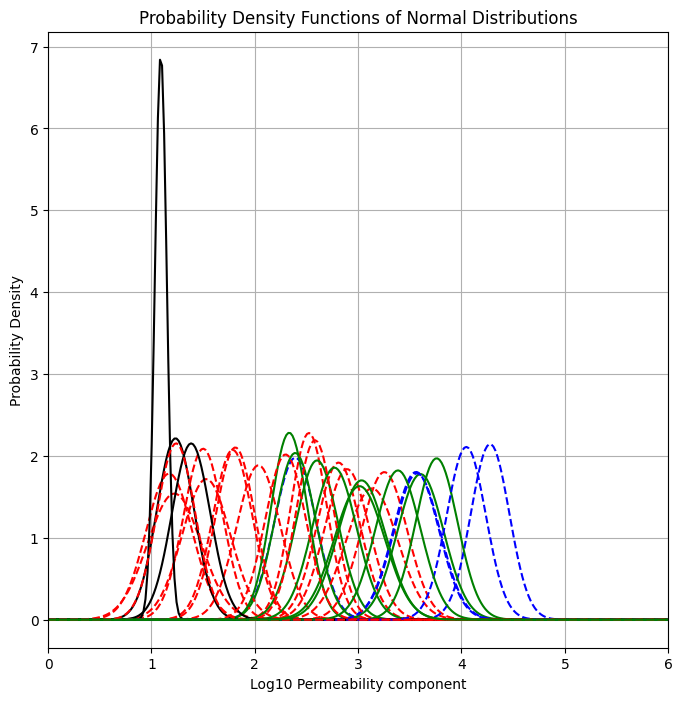

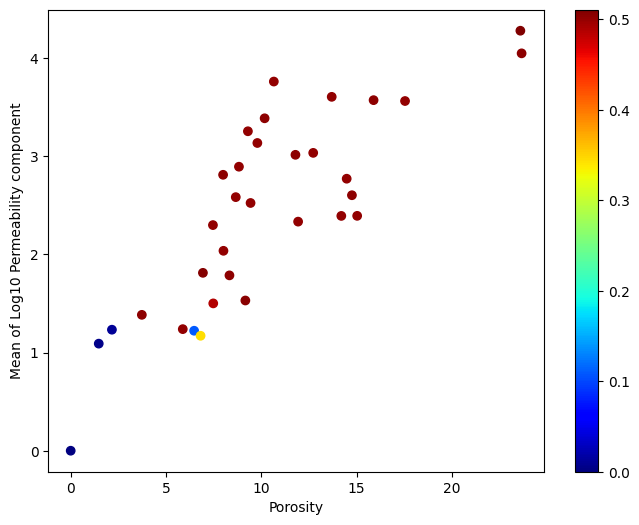

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Initialize an empty array to store all PDFs
all_pdfs = []
all_means_i = []
all_means_f = []
all_porosity = []


# Define the color map for different porosity ranges
colors = ['black', 'red', 'green', 'blue']
linestyle=['solid', 'dashed', 'solid', 'dashed']

for i in range(1, 34):
  if i == 8:
    all_means_i.append(0)
    all_porosity.append(0)
    all_means_f.append(0)
  else:
    # Parameters of the normal distribution
    data = np.log10(df_ues[f'Fluid perm_{i}'])
    mean = np.mean(data)
    std_dev = np.std(data)

    f_param = np.mean(df_ues[f'f_{i}'])

    # Generate data points for the PDF
    x = np.linspace(0, 10, 500)
    pdf = norm.pdf(x, mean, std_dev)

    # Determine the color based on porosity values
    porosity = df_ues[f'Porosity_{i}'][0]

    if porosity < 5:
      color_index, linestyle_index = 0, 0  # Default color is black
      # print(porosity, color_index)
    if porosity > 5 and porosity < 10:
        color_index, linestyle_index = 1, 1  # Red
        # print(porosity, color_index)
    if porosity > 10 and porosity < 15:
        color_index, linestyle_index = 2, 2  # Green
        # print(porosity, color_index)
    if porosity > 15:
      color_index, linestyle_index = 3, 3  # Green

    # Append the PDF and color to the array
    all_pdfs.append((pdf, colors[color_index], linestyle[linestyle_index] ))
    all_means_i.append(mean)
    all_porosity.append(porosity)
    all_means_f.append(f_param)

# Plot all PDFs on the same plot with different colors
plt.figure(figsize=(8, 8))

for pdf, color, linestyle in all_pdfs:
    plt.plot(x, pdf, color=color, linestyle=linestyle)

plt.xlabel('Log10 Permeability component')
plt.ylabel('Probability Density')
plt.title('Probability Density Functions of Normal Distributions')
plt.xlim(0, 6)
plt.grid(True)


plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_porosity, all_means_i,
                      c=all_means_f, cmap='jet', marker='o')
plt.xlabel('Porosity')
plt.ylabel('Mean of Log10 Permeability component')
plt.colorbar(scatter)  # Add color bar to the plot
# plt.xlim(0, 25)
# plt.ylim(0, 1)


plt.show()

In [ ]:
table = pd.DataFrame()
table['f mean'] = all_means_f
table['porosity'] = all_porosity
table['K i'] = all_means_i

In [ ]:
table

f mean   porosity       K i
0   0.108129   6.473371  1.221813
1   0.502164  15.024288  2.391874
2   0.502328  14.192654  2.391145
3   0.501697   9.432966  2.522849
4   0.502426   9.294073  3.253223
5   0.502525   8.824133  2.892181
6   0.487922   7.476561  1.500333
7   0.000000   0.000000  0.000000
8   0.343650   6.812696  1.170568
9   0.504391   8.326069  1.785643
10  0.501736   8.011974  2.035822
11  0.502463  17.534538  3.561161
12  0.502910   7.992399  2.809867
13  0.502484   9.789559  3.133800
14  0.510760  23.583723  4.276966
15  0.506646   9.160330  1.529835
16  0.502650  11.926943  2.332895
17  0.503081  11.786910  3.013320
18  0.501979  13.689575  3.603701
19  0.502811  14.749640  2.601802
20  0.502477  14.474410  2.769990
21  0.503007  15.885169  3.569977
22  0.501564   8.657731  2.582361
23  0.502592  10.653592  3.759420
24  0.503306   3.731300  1.383702
25  0.010908   2.162350  1.232381
26  0.005025   1.471150  1.090452
27  0.507662   6.934715  1.811472
28  0.501297   7.459951  2.297761
29  0.504681  23.648542  4.046554
30  0.502911  10.171065  3.385207
31  0.501481   5.877850  1.238193
32  0.502755  12.718631  3.033082

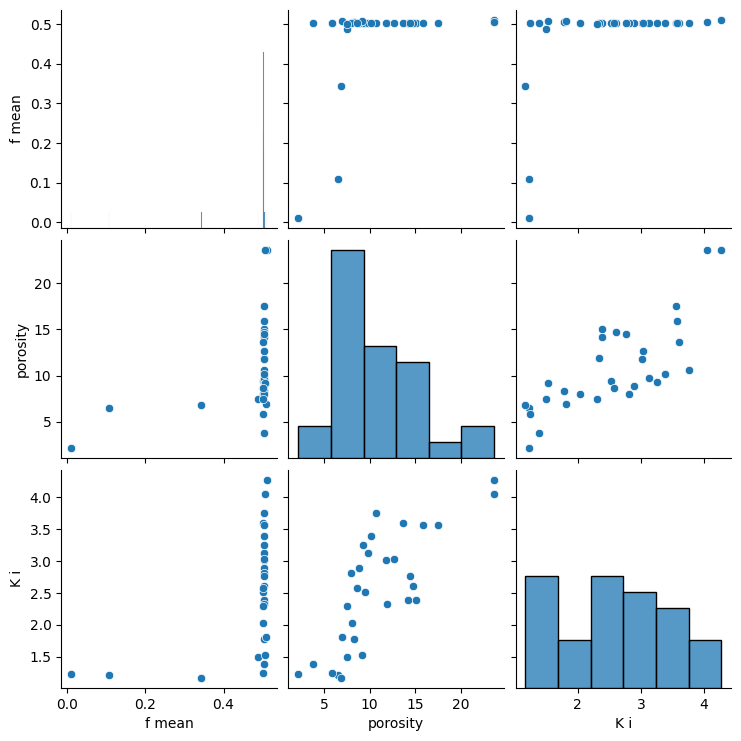

In [ ]:
import seaborn as sns
sns.pairplot(table)

### Input data

In [ ]:
path_to_ser = Path('/content/NewElasticity_v1/f model.xlsx')
df_ues_ar = pd.read_excel(path_to_ser, skiprows=0)

In [ ]:
df_ues_ar.columns

Index(['#', 'Sample', 'Well', 'Litholohy', 'Porosity,%', 'Permeability', 'Density (air)',
       'Density (water)', 'Density (oil)', 'Vp air', 'Vs air', 'Vp oil', 'Vs oil', 'Vp water',
       'Vs water', 'Unnamed: 15', 'AR thermal', 'AO electrical', 'AR elastic', 'Unnamed: 19',
       'TC air', 'TC oil', 'TC 0,6', 'TC 6', 'TC 60', 'TC 180', 'Unnamed: 26', 'Скважина', 'R 0.6',
       'R 6', 'R 60', 'R 180', 'Unnamed: 32', 'Unnamed: 33', 'УЭС, Ом*м', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Провод-ть, См/м', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41'],
      dtype='object')

In [ ]:

df_ues_ar.dropna(subset=['Porosity,%'], inplace=True)

In [ ]:
idx = 30
porosity = df_ues_ar["Porosity,%"][idx]/100

In [ ]:
porosity

0.236485416123435

In [ ]:
df_ues_ar[['AR thermal', 'AO electrical', 'AR elastic']].iloc[idx]

AR thermal       0.131826
AO electrical    0.080662
AR elastic       0.110000
Name: 31, dtype: float64

In [ ]:
air_tc_exp = df_ues_ar["TC air"][idx]
water_tc_exp = df_ues_ar["TC 6"][idx]
oil_tc_exp = df_ues_ar["TC oil"][idx]

In [ ]:
exp_6 = 1/ df_ues_ar["R 6"][idx]
exp_60 = 1/ df_ues_ar["R 60"][idx]
exp_180 = 1/ df_ues_ar["R 180"][idx]

In [ ]:
Vp_exp_air, Vs_exp_air = df_ues_ar["Vp air"][idx], df_ues_ar["Vs air"][idx]
Vp_exp_water, Vs_exp_water = df_ues_ar["Vp water"][idx], df_ues_ar["Vs water"][idx]

density_air, density_water = df_ues_ar["Density (air)"][idx], df_ues_ar["Density (water)"][idx]
p_air, p_water = density_air, density_water

### Thermal conductivity

In [ ]:
# Matrix value is fixed
def table_calculation(fluid, lam_matrix):

    print(lam_matrix)

  # for fluid in fluid_list:

    data_fluid = []

    tc_eff_list, f_result, ar_result = [], [], []
    tc_mtrx = []

    globals()[f'result_{fluid}'] = pd.DataFrame()
    globals()[f'sorted_{fluid}'] = pd.DataFrame()

    lam_fluid = 0

    if fluid=='air':
      lam_fluid = 0.025
    elif fluid == 'water':
      lam_fluid = 0.60
    elif fluid == 'oil':
      lam_fluid = 0.12

    N, n = 2, 2 # Amount of nodes


    for ar_inclusion in np.logspace(-2, 0, N, base=10):

      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [lam_matrix, lam_fluid]
        print(lam)

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)
        tc_mtrx.append(lam[0])

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
    globals()[f'result_{fluid}'][f'f'] = f_result
    globals()[f'result_{fluid}'][f'TCmtrx_{fluid}'] = tc_mtrx
    globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list


    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

    globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [globals()[f'{fluid}_tc_exp']]*len(tc_eff_list)

    globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
                                                                            [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

    globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
                                                                            [globals()[f"lam_mtrx_{fluid}"], lam_fluid])



    # Calculate the difference and assign it directly to the new column 'Diff Vp air'
    TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
    globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2))
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'TC_{fluid}'] >= globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'TC_{fluid}'] <= globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'])
]


    # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

    # return globals()[f'sorted_{fluid}'].shape[0]
    return globals()[f'result_{fluid}'].shape[0]

In [ ]:
# Matrix value changes within error
def table_calculation_matrix(fluid, lam_matrix_list):

  data_fluid = []

  tc_eff_list, f_result, ar_result = [], [], []
  tc_mtrx = []
  hs_up_list, hs_lo_list = [], []

  globals()[f'result_{fluid}'] = pd.DataFrame()
  globals()[f'sorted_{fluid}'] = pd.DataFrame()

  lam_fluid = 0

  if fluid=='air':
    lam_fluid = 0.025
  elif fluid == 'water':
    lam_fluid = 0.60
  elif fluid == 'oil':
    lam_fluid = 0.12


  N, n = 100, 20 # Amount of nodes

  for matrix_value in lam_matrix_list:
    for ar_inclusion in np.logspace(-2, 0, N, base=10):
      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [matrix_value, lam_fluid]

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)
        tc_mtrx.append(matrix_value)

        hs_up_list.append(Upper_Hashin_Strikman(conc, lam))
        hs_lo_list.append(Lower_Hashin_Strikman(conc, lam))

  globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
  globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
  globals()[f'result_{fluid}'][f'f'] = f_result
  globals()[f'result_{fluid}'][f'TCmtrx_{fluid}'] = tc_mtrx
  globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list

  globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = hs_up_list
  globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] = hs_lo_list


  globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

  globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [globals()[f'{fluid}_tc_exp']]*len(tc_eff_list)

  # globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # Calculate the difference and assign it directly to the new column 'Diff Vp air'
  TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
  globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2))
  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
  (globals()[f'result_{fluid}'][f'TC_{fluid}'] >= globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}']) &
  (globals()[f'result_{fluid}'][f'TC_{fluid}'] <= globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'])
]


  # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

  return globals()[f'result_{fluid}']

In [ ]:
fluid_list = ['air', 'water', 'oil']
# fluid_list = ['water']

lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

error_air, error_water, error_oil = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
N = 5

for fluid in fluid_list:

  # print(fluid, globals()[f"lam_mtrx_{fluid}"], globals()[f"lam_{fluid}"])

  globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  N)


  # for lam_matrix in globals()[f"lam_mtrx_{fluid}_list"] :

  number = table_calculation_matrix(fluid, globals()[f"lam_mtrx_{fluid}_list"])

    # print(globals()[f"error_{fluid}"], lam_matrix)

  # print('\n\n')

In [ ]:
tc_oil = result_oil
tc_water = result_water
tc_air = result_air

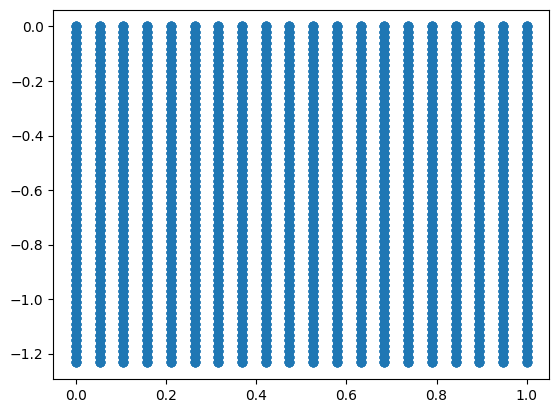

In [ ]:
plt.scatter(result_water["f"], np.log10(result_water["AR inclusion"]))

In [ ]:
result_water[:20]

Porosity,%  AR inclusion         f  TCmtrx_water  TC_water  TC_HSup_water  TC_HSlo_water  \
760    0.236485       0.05857  0.000000        2.8025  1.993435       2.151412       1.904238   
761    0.236485       0.05857  0.052632        2.8025  1.995719       2.151412       1.904238   
762    0.236485       0.05857  0.105263        2.8025  1.997903       2.151412       1.904238   
763    0.236485       0.05857  0.157895        2.8025  1.999956       2.151412       1.904238   
764    0.236485       0.05857  0.210526        2.8025  2.001843       2.151412       1.904238   
765    0.236485       0.05857  0.263158        2.8025  2.003520       2.151412       1.904238   
766    0.236485       0.05857  0.315789        2.8025  2.004932       2.151412       1.904238   
767    0.236485       0.05857  0.368421        2.8025  2.006012       2.151412       1.904238   
768    0.236485       0.05857  0.421053        2.8025  2.006675       2.151412       1.904238   
769    0.236485       0.05857  0.473684        2.8025  2.006813       2.151412       1.904238   
770    0.236485       0.05857  0.526316        2.8025  2.006289       2.151412       1.904238   
771    0.236485       0.05857  0.578947        2.8025  2.004923       2.151412       1.904238   
772    0.236485       0.05857  0.631579        2.8025  2.002481       2.151412       1.904238   
773    0.236485       0.05857  0.684211        2.8025  1.998652       2.151412       1.904238   
774    0.236485       0.05857  0.736842        2.8025  1.993009       2.151412       1.904238   
775    0.236485       0.05857  0.789474        2.8025  1.984965       2.151412       1.904238   
776    0.236485       0.05857  0.842105        2.8025  1.973677       2.151412       1.904238   
777    0.236485       0.05857  0.894737        2.8025  1.957909       2.151412       1.904238   
778    0.236485       0.05857  0.947368        2.8025  1.935774       2.151412       1.904238   
779    0.236485       0.05857  1.000000        2.8025  1.904238       2.151412       1.904238   

      e_water  TC_exp_water  Diff TC water  
760  0.963916      2.227387          10.50  
761  0.963916      2.227387          10.40  
762  0.963916      2.227387          10.30  
763  0.963916      2.227387          10.21  
764  0.963916      2.227387          10.13  
765  0.963916      2.227387          10.05  
766  0.963916      2.227387           9.99  
767  0.963916      2.227387           9.94  
768  0.963916      2.227387           9.91  
769  0.963916      2.227387           9.90  
770  0.963916      2.227387           9.93  
771  0.963916      2.227387           9.99  
772  0.963916      2.227387          10.10  
773  0.963916      2.227387          10.27  
774  0.963916      2.227387          10.52  
775  0.963916      2.227387          10.88  
776  0.963916      2.227387          11.39  
777  0.963916      2.227387          12.10  
778  0.963916      2.227387          13.09  
779  0.963916      2.227387          14.51

NameError: name 'scatter_1' is not defined

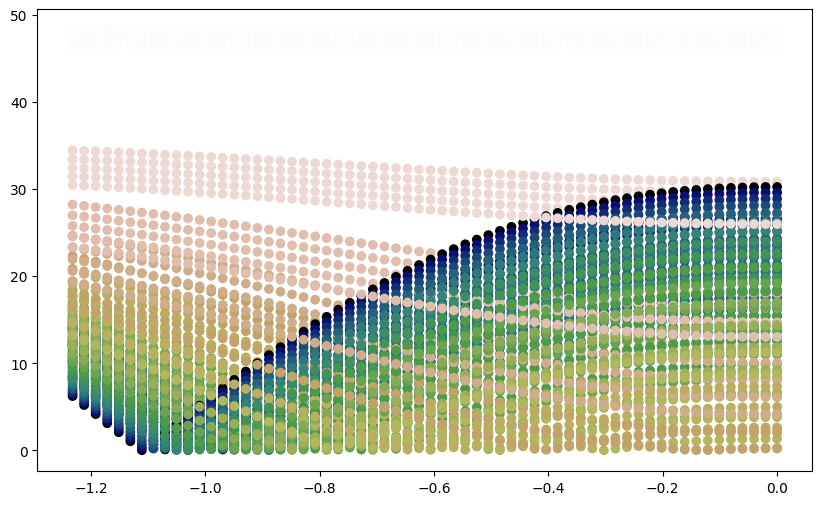

In [ ]:
plt.figure(figsize=(10, 6))

# scatter_1 = plt.scatter(np.log10(result_air['AR inclusion']),result_air['Diff TC air'],
#                       c=result_air['f'], cmap='jet', marker='o')

# scatter_2 = plt.scatter(np.log10(result_water['AR inclusion']),result_water['Diff TC water'],
#                       c=result_water['f'], cmap='seismic', marker='o')

scatter_3 = plt.scatter(np.log10(result_oil['AR inclusion']),result_oil['Diff TC oil'],
                      c=result_oil['f'], cmap='gist_earth', marker='o')

plt.colorbar(scatter_1)
plt.colorbar(scatter_2)
plt.colorbar(scatter_3)

plt.ylim(0, 10)

In [ ]:
def error_selection(table):
  error = 5
  globals()[f"selected_row_{fluid}"] = table[(abs(table[f'Diff TC {global}']) <= error)]

SyntaxError: f-string: invalid syntax (<ipython-input-35-60066dcbb09a>, line 3)

### Расчет одновременно для всей коллекции

In [ ]:
# # Merge all states function
# def merge_table(selected_row_air, selected_row_water, selected_row_oil, idx):
#   globals()[f"merged_data_{idx}"] = pd.merge(selected_row_air, selected_row_water,
#                   on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

#   globals()[f"merged_data_{idx}"] = pd.merge(globals()[f"merged_data_{idx}"], selected_row_oil,
#                       on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

#   globals()[f"merged_data_{idx}"]['total diff'] = np.sqrt(globals()[f"merged_data_{idx}"]["Diff TC air"]**2 + \
#                                   globals()[f"merged_data_{idx}"]["Diff TC water"]**2 +\
#                                   globals()[f"merged_data_{idx}"]["Diff TC oil"]**2 )

#   print('merge shape func', globals()[f"merged_data_{idx}"].shape[0])
#   return globals()[f"merged_data_{idx}"]


# Merge all states function
def merge_table(selected_row_air, selected_row_water, selected_row_oil):

  merged_data = pd.DataFrame()

  merged_data = pd.merge(selected_row_air, selected_row_water,
                  on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

  merged_data = pd.merge(merged_data, selected_row_oil,
                      on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

  merged_data['total diff'] = np.sqrt(merged_data["Diff TC air"]**2 + \
                                   merged_data["Diff TC water"]**2 +\
                                   merged_data["Diff TC oil"]**2 )
  return merged_data

0
0.045249 2.4728875 2.740225 2.66888457425328
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]
1
0.0647337128595146 2.404575 2.741125 2.60088763678152
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]
[2.8025  2.87625 2.95    3.02375 3.0975 ]


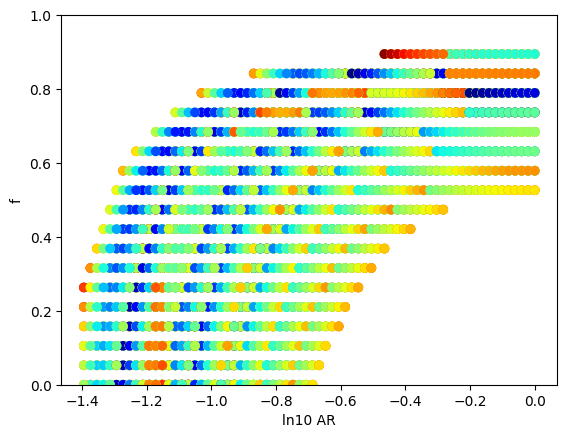

In [ ]:
# for number in range(0, len(df_ues_ar["#"])):
for number in df_ues_ar.index.tolist()[0:2]:

  fluid_list_full = ['air', 'water', 'oil']

  idx = number

  print(idx)
  porosity = df_ues_ar["Porosity,%"][idx]

  if np.isnan(porosity):
    pass

  else:
    porosity /= 100
    # Experemental values
    air_tc_exp = df_ues_ar["TC air"][idx]
    water_tc_exp = df_ues_ar["TC 6"][idx]
    oil_tc_exp = df_ues_ar["TC oil"][idx]

    print(porosity, air_tc_exp, water_tc_exp, oil_tc_exp)

    lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
    lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

    # Error in mineral matrix values
    error_air, error_water, error_oil = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
    N = 5

    # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
    # то проводиться новый расчет с ошибкой увеличенной на 2,5%
    globals()[f"merged_data_{idx}"] = pd.DataFrame()
    error = 2.5

    while globals()[f"merged_data_{idx}"].shape[0] == 0:
      # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])

      globals()[f"selected_row_{fluid}"] = pd.DataFrame()

      for fluid in fluid_list_full:
        globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                    globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                    N)
        print(globals()[f"lam_mtrx_{fluid}_list"])
        globals()[f'result_{fluid}'] = table_calculation_matrix(fluid, globals()[f"lam_mtrx_{fluid}_list"])
        globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff TC {fluid}']) <= error)]

      globals()[f"merged_data_{idx}"] = merge_table(selected_row_air, selected_row_water, selected_row_oil)
      error +=2.5


    # Pd DataFrame for each sample
    globals()[f"sample_{idx}"] = pd.DataFrame()
    globals()[f"sample_{idx}"] = globals()[f"merged_data_{idx}"]
    globals()[f"sample_{idx}"].to_csv(f'/content/Sample_{idx}.csv', index=True)

    # Plot data
    data = globals()[f"sample_{idx}"]
    scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
                          c=data["total diff"], cmap='jet', marker='o')

    # plt.colorbar(scatter)

    plt.xlabel('ln10 AR')
    plt.ylabel('f')
    plt.ylim(0, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

FileNotFoundError: Sample_2.csv not found. Skipping to the next index.
FileNotFoundError: Sample_3.csv not found. Skipping to the next index.
FileNotFoundError: Sample_4.csv not found. Skipping to the next index.
FileNotFoundError: Sample_5.csv not found. Skipping to the next index.
FileNotFoundError: Sample_6.csv not found. Skipping to the next index.
FileNotFoundError: Sample_7.csv not found. Skipping to the next index.
FileNotFoundError: Sample_8.csv not found. Skipping to the next index.
FileNotFoundError: Sample_9.csv not found. Skipping to the next index.
FileNotFoundError: Sample_10.csv not found. Skipping to the next index.
FileNotFoundError: Sample_11.csv not found. Skipping to the next index.
FileNotFoundError: Sample_12.csv not found. Skipping to the next index.
FileNotFoundError: Sample_13.csv not found. Skipping to the next index.
FileNotFoundError: Sample_14.csv not found. Skipping to the next index.
FileNotFoundError: Sample_15.csv not found. Skipping to the next index.


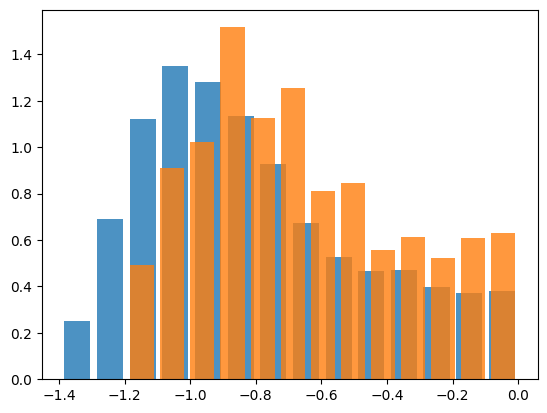

In [ ]:
for idx in range(0, len(df_ues_ar["#"])):
    try:
        path_to_ser = Path(f'/content/Sample_{idx}.csv')
        globals()[f"Sample_{idx}"] = pd.read_csv(path_to_ser, skiprows=0)

    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")
        continue  # Skip to the next index

    data = globals()[f"Sample_{idx}"]

    log_data = np.log10(data["AR inclusion"])
    normalized_data = MinMaxScaler().fit_transform(np.array(log_data).reshape(-1, 1))

    plt.hist(log_data, bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8)

    # # Create a mask by porosity
    # mask = None

    # if data['Porosity,%_air'].iloc[0] < 0.05:
    #     mask = data['Porosity,%_air'] < 0.05
    #     plt.hist(log_data[mask], bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8, color='black')
    # elif (data['Porosity,%_air'].iloc[0] > 0.05) & (data['Porosity,%_air'].iloc[0] < 0.1):
    #     mask = (data['Porosity,%_air'].iloc[0] > 0.05) & (data['Porosity,%_air'].iloc[0] < 0.1)
    #     plt.hist(log_data[mask], bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8, color='red')
    # else:
    #     mask = ~(data['Porosity,%_air'].iloc[0] < 0.05) & ~((data['Porosity,%_air'].iloc[0] > 0.05) & (data['Porosity,%_air'].iloc[0] < 0.1))
    #     plt.hist(log_data[mask], bins="sturges", density=True, histtype='barstacked', rwidth=0.8, alpha=0.8, color='blue')

plt.show()

In [ ]:
sample_2["TCmtrx_air"].min().max()

2.95

KeyError: 'merged_data_2'

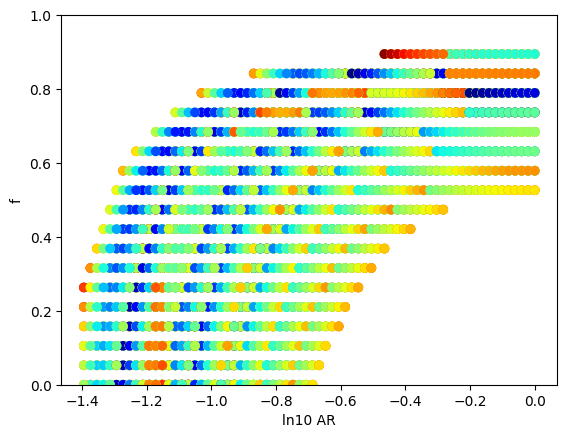

In [ ]:
for number in df_ues_ar.index.tolist()[0:10]:
  idx = number
# for number in range(0, len(df_ues_ar["#"])):

  globals()[f"sample_{idx}"] = pd.DataFrame()
  globals()[f"sample_{idx}"] = globals()[f"merged_data_{idx}"]

  # Plot the new data
  data = globals()[f"sample_{idx}"]
  scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
                        c=data["total diff"], cmap='jet', marker='o')

  plt.xlabel('ln10 AR')
  plt.ylabel('f')
  plt.ylim(0, 1)

(0.0, 1.0)

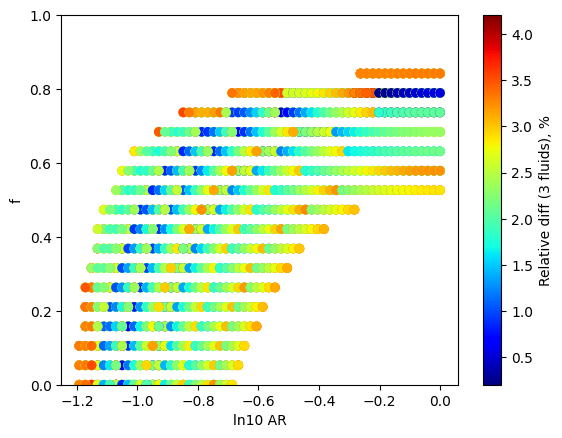

In [ ]:
data = sample_1

scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
                      c=data["total diff"], cmap='jet', marker='o')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative diff (3 fluids), %')

plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

In [ ]:
result_water

NameError: name 'result_water' is not defined

In [ ]:
error = 7

In [ ]:
selected_row_air = result_air[(abs(result_air['Diff TC air']) <= error)]
selected_row_air[:5]

Porosity,%  AR inclusion         f  TCmtrx_air    TC_air     e_air  TC_exp_air  \
11300    0.236485      0.056997  0.000000        2.95  1.271097  0.990519      1.2605   
11301    0.236485      0.056997  0.010101        2.95  1.269207  0.990519      1.2605   
11302    0.236485      0.056997  0.020202        2.95  1.267287  0.990519      1.2605   
11303    0.236485      0.056997  0.030303        2.95  1.265337  0.990519      1.2605   
11304    0.236485      0.056997  0.040404        2.95  1.263355  0.990519      1.2605   

       TC_HSup_air  TC_HSlo_air  Diff TC air  
11300      2.02481     0.243458         0.84  
11301      2.02481     0.243458         0.69  
11302      2.02481     0.243458         0.54  
11303      2.02481     0.243458         0.38  
11304      2.02481     0.243458         0.23

In [ ]:
selected_row_water = result_water[result_water['Diff TC water'] <= error]
selected_row_water[:5]

Porosity,%  AR inclusion         f  TCmtrx_water  TC_water   e_water  TC_exp_water  \
11300    0.236485      0.056997  0.000000          2.95  2.072275  0.990519      2.227387   
11301    0.236485      0.056997  0.010101          2.95  2.072774  0.990519      2.227387   
11302    0.236485      0.056997  0.020202          2.95  2.073270  0.990519      2.227387   
11303    0.236485      0.056997  0.030303          2.95  2.073763  0.990519      2.227387   
11304    0.236485      0.056997  0.040404          2.95  2.074253  0.990519      2.227387   

       TC_HSup_water  TC_HSlo_water  Diff TC water  
11300       2.252936       1.970977           6.96  
11301       2.252936       1.970977           6.94  
11302       2.252936       1.970977           6.92  
11303       2.252936       1.970977           6.90  
11304       2.252936       1.970977           6.88

In [ ]:
selected_row_oil = result_oil[result_oil['Diff TC oil'] <= error]
selected_row_oil[:5]

Porosity,%  AR inclusion         f  TCmtrx_oil    TC_oil     e_oil  TC_exp_oil  \
12500    0.236485      0.068568  0.000000        2.95  1.550851  0.823371    1.662913   
12501    0.236485      0.068568  0.010101        2.95  1.550004  0.823371    1.662913   
12502    0.236485      0.068568  0.020202        2.95  1.549143  0.823371    1.662913   
12503    0.236485      0.068568  0.030303        2.95  1.548267  0.823371    1.662913   
12504    0.236485      0.068568  0.040404        2.95  1.547378  0.823371    1.662913   

       TC_HSup_oil  TC_HSlo_oil  Diff TC oil  
12500     2.064566      0.87576         6.74  
12501     2.064566      0.87576         6.79  
12502     2.064566      0.87576         6.84  
12503     2.064566      0.87576         6.89  
12504     2.064566      0.87576         6.95

In [ ]:
# Merge selected_row_air and selected_row_water first
merged_data_tc = pd.merge(selected_row_air,
                       selected_row_water,
                       on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

# Then merge the result with selected_row_oil
merged_data_tc = pd.merge(merged_data_tc,
                       selected_row_oil,
                       on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

merged_data_tc['total diff'] = np.sqrt(merged_data_tc["Diff TC air"]**2 + \
                                    merged_data_tc["Diff TC water"]**2 +\
                                    merged_data_tc["Diff TC oil"]**2 )

In [ ]:
merged_data_tc[:5]

Porosity,%_air  AR inclusion         f  TCmtrx_air    TC_air     e_air  TC_exp_air  \
0        0.236485      0.070713  0.141414        2.95  1.346955  0.798394      1.2605   
1        0.236485      0.070713  0.151515        2.95  1.344377  0.798394      1.2605   
2        0.236485      0.071810  0.171717        2.95  1.346485  0.786192      1.2605   
3        0.236485      0.071810  0.181818        2.95  1.343748  0.786192      1.2605   
4        0.236485      0.071810  0.191919        2.95  1.340959  0.786192      1.2605   

   TC_HSup_air  TC_HSlo_air  Diff TC air  Porosity,%_water  TCmtrx_water  TC_water   e_water  \
0      2.02481     0.243458         6.86          0.236485          2.95  2.093259  0.798394   
1      2.02481     0.243458         6.65          0.236485          2.95  2.093513  0.798394   
2      2.02481     0.243458         6.82          0.236485          2.95  2.095036  0.786192   
3      2.02481     0.243458         6.60          0.236485          2.95  2.095255  0.786192   
4      2.02481     0.243458         6.38          0.236485          2.95  2.095467  0.786192   

   TC_exp_water  TC_HSup_water  TC_HSlo_water  Diff TC water  Porosity,%  TCmtrx_oil    TC_oil  \
0      2.227387       2.252936       1.970977           6.02    0.236485        2.95  1.547668   
1      2.227387       2.252936       1.970977           6.01    0.236485        2.95  1.546541   
2      2.227387       2.252936       1.970977           5.94    0.236485        2.95  1.549195   
3      2.227387       2.252936       1.970977           5.93    0.236485        2.95  1.547978   
4      2.227387       2.252936       1.970977           5.92    0.236485        2.95  1.546738   

      e_oil  TC_exp_oil  TC_HSup_oil  TC_HSlo_oil  Diff TC oil  total diff  
0  0.798394    1.662913     2.064566      0.87576         6.93   11.459708  
1  0.798394    1.662913     2.064566      0.87576         7.00   11.372889  
2  0.786192    1.662913     2.064566      0.87576         6.84   11.339383  
3  0.786192    1.662913     2.064566      0.87576         6.91   11.246022  
4  0.786192    1.662913     2.064566      0.87576         6.99   11.162925

In [ ]:
merged_data_tc["AR inclusion"].min(), merged_data_tc["AR inclusion"].max()

(0.07071284778942996, 0.28720631177978284)

In [ ]:
merged_data_tc.to_csv('/content/tc_5.csv', index=True)

(0.0, 1.0)

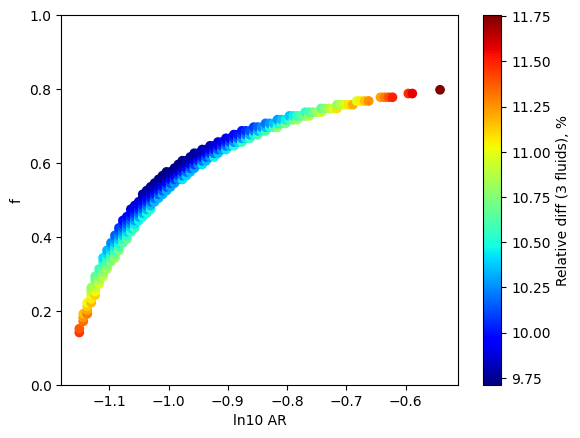

In [ ]:
scatter = plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"],
                      c=merged_data_tc["total diff"], cmap='jet', marker='o')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative diff (3 fluids), %')

plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(array([0.54285714, 0.95      , 0.9       , 1.22857143, 1.04285714,
        1.34285714, 1.14285714, 0.77142857, 0.83571429, 0.60714286,
        0.72142857, 0.71428571]),
 array([-1.11111111, -1.01851852, -0.92592593, -0.83333333, -0.74074074,
        -0.64814815, -0.55555556, -0.46296296, -0.37037037, -0.27777778,
        -0.18518519, -0.09259259,  0.        ]),
 <BarContainer object of 12 artists>)

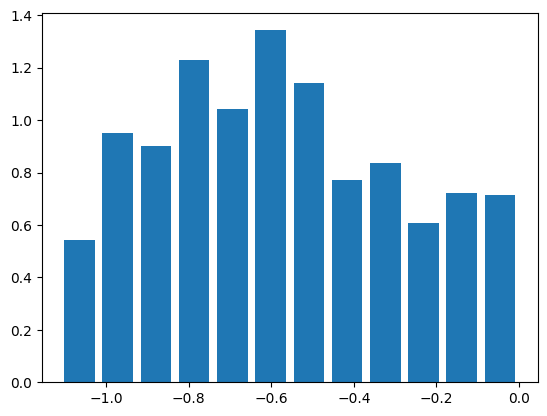

In [ ]:
plt.hist(np.log10(merged_data_tc["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

(array([1.08888889, 0.86527778, 0.88472222, 1.28333333, 1.04027778,
        1.16666667, 1.95416667, 1.43888889, 1.37083333, 1.68194444,
        1.08888889, 0.83611111]),
 array([0.        , 0.06802721, 0.13605442, 0.20408163, 0.27210884,
        0.34013605, 0.40816327, 0.47619048, 0.54421769, 0.6122449 ,
        0.68027211, 0.74829932, 0.81632653]),
 <BarContainer object of 12 artists>)

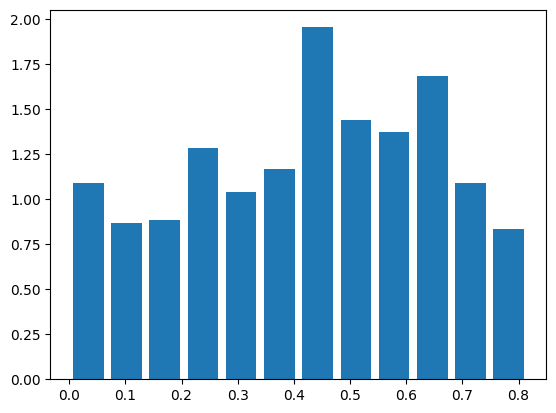

In [ ]:
plt.hist(merged_data_tc["f"], bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

In [ ]:
first[0:4]

Unnamed: 0  Porosity,%_air  AR inclusion         f  TCmtrx_air    TC_air     e_air  TC_exp_air  \
0           0        0.014711      0.026388  0.535354        2.95  2.605928  0.133096    2.659425   
1           1        0.014711      0.026388  0.545455        2.95  2.604311  0.133096    2.659425   
2           2        0.014711      0.026388  0.555556        2.95  2.602641  0.133096    2.659425   
3           3        0.014711      0.026388  0.565657        2.95  2.600916  0.133096    2.659425   

   TC_HSup_air  TC_HSlo_air  Diff TC air  Porosity,%_water  TCmtrx_water  TC_water   e_water  \
0     2.886189     1.856277         2.01          0.014711          2.95  2.883979  0.133096   
1     2.886189     1.856277         2.07          0.014711          2.95  2.884015  0.133096   
2     2.886189     1.856277         2.14          0.014711          2.95  2.884046  0.133096   
3     2.886189     1.856277         2.20          0.014711          2.95  2.884073  0.133096   

   TC_exp_water  TC_HSup_water  TC_HSlo_water  Diff TC water  Porosity,%  TCmtrx_oil    TC_oil  \
0      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.765829   
1      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.765925   
2      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.766012   
3      2.907188       2.903178       2.871794            0.8    0.014711        2.95  2.766089   

      e_oil  TC_exp_oil  TC_HSup_oil  TC_HSlo_oil  Diff TC oil  total diff  
0  0.133096     2.83689     2.889215     2.619323          2.5    3.306070  
1  0.133096     2.83689     2.889215     2.619323          2.5    3.342888  
2  0.133096     2.83689     2.889215     2.619323          2.5    3.386680  
3  0.133096     2.83689     2.889215     2.619323          2.5    3.424909

### Electrical conductivity

In [ ]:
def table_calculation(fluid, lam_matrix):

    data_fluid = []

    tc_eff_list, f_result, ar_result = [], [], []

    globals()[f'result_{fluid}'] = pd.DataFrame()
    globals()[f'sorted_{fluid}'] = pd.DataFrame()

    lam_fluid = 0

    if fluid=='6':
      lam_fluid = 1.060
    elif fluid == '60':
      lam_fluid = 8.42
    elif fluid == '180':
      lam_fluid = 18.87

    N, n = 300, 100 # Amount of nodes

    for ar_inclusion in np.logspace(-2, 0, N):

      for f in np.linspace(0, 1, n):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [globals()[f"lam_mtrx_{fluid}"], lam_fluid]

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        tc_eff_list.append(1/lam_eff)
        f_result.append(f)
        ar_result.append(ar_inclusion)

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
    globals()[f'result_{fluid}'][f'f'] = f_result
    globals()[f'result_{fluid}'][f'TC_{fluid}'] = (tc_eff_list)

    globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = [1/(globals()[f'exp_{fluid}'])]*len(tc_eff_list)

    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])

    # Calculate the difference and assign it directly to the new column 'Diff Vp air'
    TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
    # globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = np.log10(abs((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp)))

    globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = abs(np.round((np.log10(globals()[f'result_{fluid}'][f'TC_{fluid}']) - \
                                                                     np.log10(TC_exp)) / np.log10(TC_exp) * 100, 2))
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

    # return globals()[f'sorted_{fluid}'].shape[0]
    return globals()[f'result_{fluid}'].shape[0]

In [ ]:
fluid_list = ['6', '60', '180']

lam_6, lam_60, lam_180 = 1.060, 8.42, 18.87
lam_mtrx_6, lam_mtrx_60, lam_mtrx_180 = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

error_6, error_60, error_180 = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
N = 5

for fluid in fluid_list:

  # print(fluid, globals()[f"lam_mtrx_{fluid}"], globals()[f"lam_{fluid}"])

  globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  N)

  for lam_matrix in globals()[f"lam_mtrx_{fluid}_list"] :

    number = table_calculation(fluid, lam_matrix)

    # print(globals()[f"error_{fluid}"], lam_matrix)

  # print('\n\n')

In [ ]:
electric_180 = result_180
electric_60 = result_60
electric_6 = result_6

In [ ]:
electric_60[:5]

Porosity,%  AR inclusion         f      TC_60  TC_exp_60      e_60  \
2900    0.064734      0.015631  0.000000  16.027634  25.352935  0.988694   
2901    0.064734      0.015631  0.010101   6.594615  25.352935  0.988694   
2902    0.064734      0.015631  0.020202   5.312448  25.352935  0.988694   
2903    0.064734      0.015631  0.030303   4.794853  25.352935  0.988694   
2904    0.064734      0.015631  0.040404   4.509818  25.352935  0.988694   

      Diff TC 60  
2900       14.18  
2901       41.65  
2902       48.34  
2903       51.51  
2904       53.41

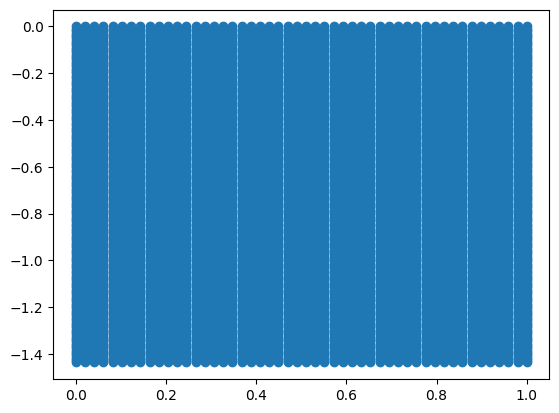

In [ ]:
plt.scatter(result_6["f"], np.log10(result_6["AR inclusion"]))

In [ ]:
result_60[:10]

Porosity,%  AR inclusion         f      TC_60  TC_exp_60      e_60  Diff TC 60
2900    0.158852      0.038275  0.000000  13.490877     3.8954  0.990806      246.33
2901    0.158852      0.038275  0.020408   3.002213     3.8954  0.990806       22.93
2902    0.158852      0.038275  0.040816   2.250574     3.8954  0.990806       42.22
2903    0.158852      0.038275  0.061224   1.968082     3.8954  0.990806       49.48
2904    0.158852      0.038275  0.081633   1.815933     3.8954  0.990806       53.38
2905    0.158852      0.038275  0.102041   1.718374     3.8954  0.990806       55.89
2906    0.158852      0.038275  0.122449   1.648903     3.8954  0.990806       57.67
2907    0.158852      0.038275  0.142857   1.595836     3.8954  0.990806       59.03
2908    0.158852      0.038275  0.163265   1.553219     3.8954  0.990806       60.13
2909    0.158852      0.038275  0.183673   1.517698     3.8954  0.990806       61.04

(0.0, 10.0)

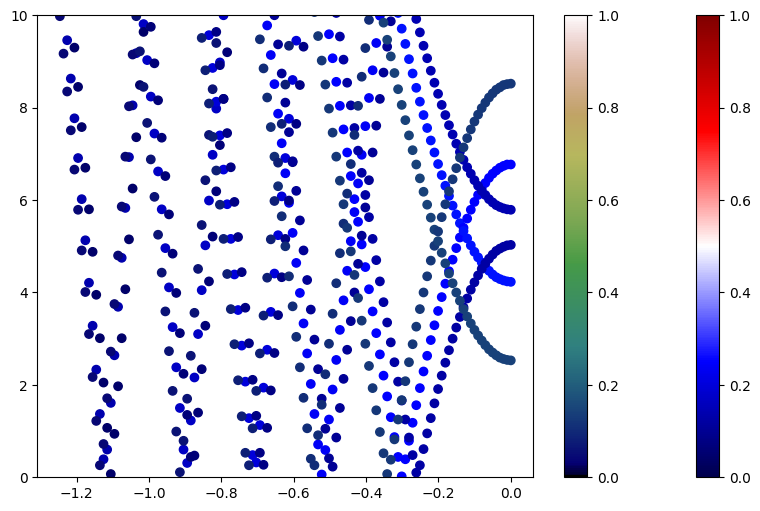

In [ ]:
plt.figure(figsize=(10, 6))

scatter1 = plt.scatter(np.log10(result_60['AR inclusion']),result_60['Diff TC 60'],
                      c=result_60['f'], cmap='jet', marker='o')

scatter_2 = plt.scatter(np.log10(result_6['AR inclusion']),result_6['Diff TC 6'],
                      c=result_6['f'], cmap='seismic', marker='o')

scatter_3 = plt.scatter(np.log10(result_180['AR inclusion']),result_180['Diff TC 180'],
                      c=result_180['f'], cmap='gist_earth', marker='o')

plt.colorbar(scatter_1)
plt.colorbar(scatter_2)
plt.colorbar(scatter_3)

plt.ylim(0, 10)


In [ ]:
error = 10

In [ ]:
selected_row_6 = result_6[(abs(result_6['Diff TC 6']) <= error)]
selected_row_6[:5]

Empty DataFrame
Columns: [Porosity,%, AR inclusion, f, TC_6, TC_exp_6, e_6, Diff TC 6]
Index: []

In [ ]:
selected_row_60 = result_60[result_60['Diff TC 60'] <= error]
selected_row_60[:5]

Empty DataFrame
Columns: [Porosity,%, AR inclusion, f, TC_60, TC_exp_60, e_60, Diff TC 60]
Index: []

In [ ]:
selected_row_180= result_180[result_180['Diff TC 180'] <= error]
selected_row_180[:5]

Empty DataFrame
Columns: [Porosity,%, AR inclusion, f, TC_180, TC_exp_180, e_180, Diff TC 180]
Index: []

In [ ]:

# Merge selected_row_air and selected_row_water first
merged_data = pd.merge(selected_row_6,
                       selected_row_60,
                       on=["AR inclusion", "f"], suffixes=('_6', '60'), how='inner')

# Then merge the result with selected_row_oil
merged_data = pd.merge(merged_data,
                       selected_row_180,
                       on=["AR inclusion", "f"], suffixes=('_merged', '_180'), how='inner')

merged_data['total diff'] = np.sqrt(merged_data["Diff TC 6"]**2 + \
                                    merged_data["Diff TC 60"]**2 +\
                                    merged_data["Diff TC 180"]**2 )

In [ ]:
merged_data[:5]

Empty DataFrame
Columns: [Porosity,%_6, TC_6, TC_exp_6, e_6, Diff TC 6, Porosity,%60, TC_60, TC_exp_60, e_60, Diff TC 60, Porosity,%, AR inclusion, f, TC_180, TC_exp_180, e_180, Diff TC 180, total diff]
Index: []

(0.0, 1.0)

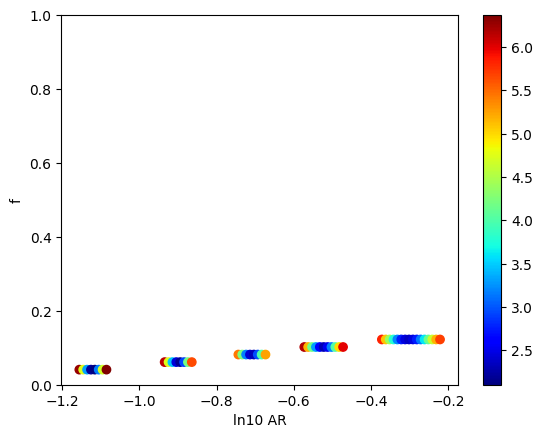

In [ ]:
scatter = plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"],
                      c= merged_data["total diff"], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(0.0, 1.0)

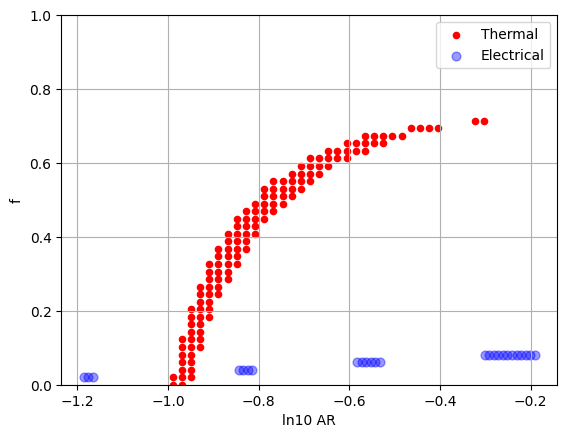

In [ ]:
# scatter1 = plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"],
#                       c= merged_data_tc["total diff"], cmap='seismic', marker='o')

# scatter2 = plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"],
#                       c= merged_data["total diff"], cmap='hsv', marker='o')

# plt.colorbar(scatter1)  # Add color bar to the plot
# plt.colorbar(scatter2)  # Add color bar to the plot


plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"], color='red', s=20, label='Thermal')

plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"], color='blue', alpha=0.4, s=40, label='Electrical')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')
plt.grid()
plt.legend()

plt.ylim(0, 1)

### Elastic

In [13]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

In [14]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

In [15]:
def HS_borders(K, μ, f):


  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 +
                        f[0]*(K[0]+4/3*μ[0])**-1))

  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 +
                        f[1]*(K[1]+4/3*μ[1])**-1))

  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 +
                          2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))

  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 +
                          2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [16]:
def prolate_common(K_i, Mu_i, AR, K_it, Mu_it): ### --> AR>1


    func_teta = (AR * ((AR ** 2-1) ** (-3 / 2))) * (AR * (AR ** 2-1) ** 0.5-np.arccosh(AR))
    func_f = AR ** 2 * (1-AR ** 2) ** -1 * (3 * func_teta-2)


    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it+2 * Mu_it) ### < -- Poisson ration
    R = (1 - 2*v_m) / (2 *(1-v_m))

    A = Mu_i / Mu_it - 1
    B = 1/3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (
                   func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)


    P = 1/3 * (3*F1 / F2)
    Q = 1 / 5 * (2 / F3+1 / F4+((F4 * F5+F6 * F7-F8 * F9) / (F2 * F4)))

    return P, Q


def oblate_common(K_i, Mu_i, AR, K_it, Mu_it): ### < --- oblate - AR < 1
                                              ### <-- K_i, Mu_i: components of medium
                                              ### <-- K_it, Mu_it: effective moduls, that iterate

    func_teta = AR / ((1-AR ** 2) ** (3/2)) * (np.arccos(AR) - AR * (1-AR ** 2) ** 0.5)
    func_f = (AR ** 2 / (1-AR ** 2)) * (3 * func_teta-2)

    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it + 2 * Mu_it)
    R = (1-2 * v_m) / (2 * (1-v_m))

    A = (Mu_i / Mu_it)-1
    B = 1 / 3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)

    P = 1/3 * (3*F1/F2)
    Q = 1/5 * (2/F3 + 1/F4 + ((F4 * F5 + F6 * F7 - F8 * F9) / (F2 * F4)))

    return P, Q

In [17]:
def effective_modulus(AR_mtrx, AR_fluid, K_it, Mu_it, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  P_mtrx, Q_mtrx = 0, 0
  P_fl, Q_fl = 0, 0

  if AR_mtrx < 1:
    P_mtrx, Q_mtrx = oblate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  elif AR_mtrx == 1:
    AR_mtrx = 1.00001
    P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  else:
     P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)


  if AR_fluid < 1:
    P_fl, Q_fl = oblate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  elif AR_fluid == 1:
    AR_fluid = 1.00001
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  else:
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)



  Mu = (((1-por) * Mu_matrix * Q_mtrx)+(por * Mu_fluid * Q_fl)) / (
            (1-por) * Q_mtrx + por * Q_fl)  # эффективный модуль сдвига


  K = (((1-por) * K_matrix * P_mtrx)+(por * K_fluid * P_fl)) / (
            (1-por) * P_mtrx + por * P_fl)  # эффективный модуль сжатия


  return K, Mu

In [18]:
def main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por, f):

  K, Mu = 0, 0

  x0, x1 = K_matrix*(1-f)+K_fluid*f, Mu_matrix*(1-f) + Mu_fluid*f ### <--- first initialization
  K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)


  # while abs(x0-K_eff) and abs(x1-Mu_eff) >= eps:
  #   # print(x0, x1, K_eff, Mu_eff)
  #   x0, x1 = K_eff, Mu_eff
  #   K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K, Mu = K_eff, Mu_eff

  return K, Mu

In [106]:
def effective_modulus_double_porosity(AR_mtrx, AR_pore,
                                      K_it, Mu_it,
                                      K_matrix, Mu_matrix,
                                      K_fluid, Mu_fluid, porosity_pore):

  P_mtrx, Q_mtrx = 0, 0
  P_fl_pore, Q_fl_pore = 0, 0

  if AR_mtrx < 1:
    P_mtrx, Q_mtrx = oblate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  elif AR_mtrx == 1:
    AR_mtrx = 1.00001
    P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  else:
     P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)


  if AR_pore < 1:
    P_fl_pore, Q_fl_pore = oblate_common(K_fluid, Mu_fluid, AR_pore, K_it, Mu_it)
  elif AR_pore == 1:
    AR_pore= 1.00001
    P_fl_pore, Q_fl_pore = prolate_common(K_fluid, Mu_fluid, AR_pore, K_it, Mu_it)
  else:
    P_fl_pore, Q_fl_pore = prolate_common(K_fluid, Mu_fluid, AR_pore, K_it, Mu_it)

  total_porosity = porosity_pore

  Mu = (((1-total_porosity) * Mu_matrix * Q_mtrx)+(porosity_pore * Mu_fluid * Q_fl_pore)) / (
            (1-total_porosity) * Q_mtrx + porosity_pore * Q_fl_pore)  # эффективный модуль сдвига


  K = (((1-total_porosity) * K_matrix * P_mtrx)+(porosity_pore * K_fluid * P_fl_pore)) / (
            (1-total_porosity) * P_mtrx + porosity_pore * P_fl_pore)


  return K, Mu

In [110]:
def main_Berryman_common_double_porosity(AR_mtrx, AR_pore,
                                         K_matrix, Mu_matrix,
                                         K_fluid, Mu_fluid,
                                         porosity_pore, f):

  K, Mu = 0, 0

  x0, x1 = K_matrix*(1-f)+K_fluid*f, Mu_matrix*(1-f) + Mu_fluid*f ### <--- first initialization
  K_eff, Mu_eff = effective_modulus_double_porosity(AR_mtrx, AR_pore,
                                    x0, x1,
                                    K_matrix, Mu_matrix,
                                    K_fluid, Mu_fluid,
                                    porosity_pore)


  # while abs(x0-K_eff) and abs(x1-Mu_eff) >= eps:
  #   # print(x0, x1, K_eff, Mu_eff)
  #   x0, x1 = K_eff, Mu_eff
  #   K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K, Mu = K_eff, Mu_eff

  return K, Mu

In [21]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

density_air, density_water, density_oil = p_air, p_water, p_oil

90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


In [ ]:
K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

Text(0.5, 1.0, 'Porosity - Elastic with dependecence from f')

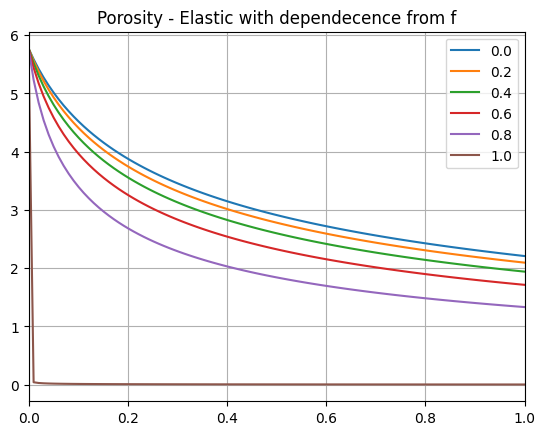

In [ ]:
N, n = 100, 6

for f in np.linspace(0, 1, n):

  Vp_array, Vs_array = [], []

  for porosity in np.linspace(0, 0.1, N):

    AR_mtrx, AR_inclusion = 1, 10**-2

    K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, K_air_mtrx, Mu_air_mtrx, K_air, Mu_air, porosity, f)

    # K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, K_water_mtrx, Mu_water_mtrx, K_water, Mu_water, porosity, f)
    density_mtrx, density_fluid = 2.71, p_water
    Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

    Vp_array.append(Vp)
    Vs_array.append(Vs)

    # Vp_array.append(K)
    # Vs_array.append(Mu)

  plt.plot(np.linspace(0, 1, N),  Vp_array, label=f"{np.round(f, 1)}")
  # plt.plot(np.linspace(0, 1, N),  Vs_array, label=f"{np.round(f, 1)}")
  plt.legend()
plt.xlim(0,1)
# plt.ylim(5.8,6)
plt.grid()
plt.title('Porosity - Elastic with dependecence from f')


In [ ]:
fluid_list = ['air', 'water']
eps = 10**-8

for fluid in fluid_list:

    data_fluid = {

    }

    Vp_fluid_list = []
    Vs_fluid_list = []
    AR_list = []
    K_mtrx_var, mu_mtrx_var = [], []
    f_list = []

    globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)

    ### Matrix range
    globals()[f"K_{fluid}_matix_range"] = [
                                      globals()[f"K_{fluid}_mtrx"],
                                      ]

    globals()[f"Mu_{fluid}_matix_range"] = [
                                      globals()[f"Mu_{fluid}_mtrx"],
                                     ]


#     error_mtrx = 0

# ### Matrix range
#     globals()[f"K_{fluid}_matix_range"] = [globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * error_mtrx ,
#                                       globals()[f"K_{fluid}_mtrx"],
#                                       globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * error_mtrx ]

#     globals()[f"Mu_{fluid}_matix_range"] = [globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * error_mtrx ,
#                                       globals()[f"Mu_{fluid}_mtrx"],
#                                       globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * error_mtrx ]

    N, n = 300, 100

    for ar_inclusion in np.logspace(-2, 0, num=N, base=10):

      for f in np.linspace(0, 1, n):

        AR_inclusion = ar_inclusion
        AR_mtrx = 1.00001

        for k, mu in zip(globals()[f"K_{fluid}_matix_range"], globals()[f"Mu_{fluid}_matix_range"]):

          AR_list.append(ar_inclusion)
          f_list.append(f)

          K_matrix, Mu_matrix = k, mu
          K_mtrx_var.append(K_matrix)
          mu_mtrx_var.append(Mu_matrix)

          K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, k, mu, globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"] , porosity, f)
          density_mtrx, density_fluid = 2.71, globals()[f"density_{fluid}"]
          Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

          Vp_fluid_list.append(Vp)
          Vs_fluid_list.append(Vs)

    globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(Vp_fluid_list)
    globals()[f'result_{fluid}'][f'AR inclusion'] = AR_list
    globals()[f'result_{fluid}'][f'f'] = f_list

    globals()[f'result_{fluid}'][f'K matrx {fluid}'] = K_mtrx_var
    globals()[f'result_{fluid}'][f'Mu matrx {fluid}'] = mu_mtrx_var

    globals()[f'result_{fluid}'][f'Vp {fluid}'] = Vp_fluid_list
    globals()[f'result_{fluid}'][f'Vs {fluid}'] = Vs_fluid_list

    globals()[f'result_{fluid}'][f'Vp_exp_{fluid}'] = [globals()[f'Vp_exp_{fluid}']]*len(Vp_fluid_list)
    globals()[f'result_{fluid}'][f'Vs_exp_{fluid}'] = [globals()[f'Vs_exp_{fluid}']]*len(Vs_fluid_list)

    # HS_borders

    globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], _, _, _, _ =\
     HS_borders(
    [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
    [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
    [1 - globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']])

    _, _, _, globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'], _ =\
     HS_borders(
    [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
    [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
    [1 - globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']])


    globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'] = \
    modulus2velosity(2.71, globals()[f"density_{fluid}"],
                     globals()[f'result_{fluid}'][f'Porosity,%'],
                     globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'])


    globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}'] = \
    modulus2velosity(2.71, globals()[f"density_{fluid}"],
                     globals()[f'result_{fluid}'][f'Porosity,%'],
                     globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'])


### Selection
    globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'Vp {fluid}'] >= globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'Vp {fluid}'] <= globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'])
]

    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
    (globals()[f'result_{fluid}'][f'Vs {fluid}'] >= globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}']) &
    (globals()[f'result_{fluid}'][f'Vs {fluid}'] <= globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'])
]


    Vp_exp, Vs_exp = globals()[f"Vp_exp_{fluid}"], globals()[f"Vs_exp_{fluid}"]

### Relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'result_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)

    globals()[f'result_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'result_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff'] = globals()[f'result_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

# ### Sort values
#     globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'].sort_values(by=f'Diff')

<ipython-input-77-fdf9b8ba45c9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
<ipython-input-77-fdf9b8ba45c9>:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)
<ipython-input-67-a336f510f645>:5: RuntimeWarning: invalid value encountered in sqrt
  Vs = np.sqrt(Mu/density)
<ipython-input-77-fdf9b8ba45c9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

In [ ]:
result_air.shape

(24300, 21)

In [ ]:
vel_air = result_air
vel_water = result_water

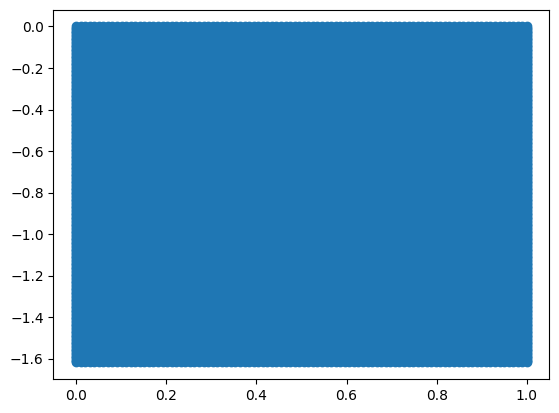

In [ ]:
plt.scatter(result_air["f"], np.log10(result_air["AR inclusion"]))

In [ ]:
result_water[:10]

Porosity,%  AR inclusion         f  K matrx water  Mu matrx water  Vp water  Vs water  \
5700         0.1      0.024059  0.000000      63.667566       28.624375  3.968231  2.207883   
5701         0.1      0.024059  0.010101      63.667566       28.624375  3.966148  2.205531   
5702         0.1      0.024059  0.020202      63.667566       28.624375  3.964030  2.203138   
5703         0.1      0.024059  0.030303      63.667566       28.624375  3.961877  2.200702   
5704         0.1      0.024059  0.040404      63.667566       28.624375  3.959689  2.198222   
5705         0.1      0.024059  0.050505      63.667566       28.624375  3.957464  2.195696   
5706         0.1      0.024059  0.060606      63.667566       28.624375  3.955202  2.193124   
5707         0.1      0.024059  0.070707      63.667566       28.624375  3.952901  2.190504   
5708         0.1      0.024059  0.080808      63.667566       28.624375  3.950561  2.187836   
5709         0.1      0.024059  0.090909      63.667566       28.624375  3.948180  2.185116   

      Vp_exp_water  Vs_exp_water  K_HSup_water  K_HSlo_water  Mu_HSup_water  Mu_HSlo_water  \
5700        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5701        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5702        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5703        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5704        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5705        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5706        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5707        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5708        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5709        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   

      Vp_HSup_water  Vs_HSup_water  Vp_HSlo_water  Vs_HSlo_water   e_water  Diff Vp water  \
5700       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.74   
5701       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.68   
5702       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.61   
5703       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.55   
5704       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.48   
5705       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.41   
5706       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.34   
5707       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.27   
5708       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.20   
5709       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.13   

      Diff Vs water   Diff  
5700          26.42  34.21  
5701          26.28  34.07  
5702          26.15  33.92  
5703          26.01  33.78  
5704          25.86  33.62  
5705          25.72  33.47  
5706          25.57  33.30  
5707          25.42  33.14  
5708          25.27  32.99  
5709          25.11  32.82

In [ ]:
result_air["AR inclusion"].min(), result_air["AR inclusion"].max()

(0.024058630546440658, 1.0)

In [ ]:
result_water[:10]

Porosity,%  AR inclusion         f  K matrx water  Mu matrx water  Vp water  Vs water  \
5700         0.1      0.024059  0.000000      63.667566       28.624375  3.968231  2.207883   
5701         0.1      0.024059  0.010101      63.667566       28.624375  3.966148  2.205531   
5702         0.1      0.024059  0.020202      63.667566       28.624375  3.964030  2.203138   
5703         0.1      0.024059  0.030303      63.667566       28.624375  3.961877  2.200702   
5704         0.1      0.024059  0.040404      63.667566       28.624375  3.959689  2.198222   
5705         0.1      0.024059  0.050505      63.667566       28.624375  3.957464  2.195696   
5706         0.1      0.024059  0.060606      63.667566       28.624375  3.955202  2.193124   
5707         0.1      0.024059  0.070707      63.667566       28.624375  3.952901  2.190504   
5708         0.1      0.024059  0.080808      63.667566       28.624375  3.950561  2.187836   
5709         0.1      0.024059  0.090909      63.667566       28.624375  3.948180  2.185116   

      Vp_exp_water  Vs_exp_water  K_HSup_water  K_HSlo_water  Mu_HSup_water  Mu_HSlo_water  \
5700        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5701        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5702        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5703        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5704        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5705        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5706        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5707        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5708        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   
5709        3.2595        1.7465     50.233968     17.070565      23.624819   2.350000e-19   

      Vp_HSup_water  Vs_HSup_water  Vp_HSlo_water  Vs_HSlo_water   e_water  Diff Vp water  \
5700       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.74   
5701       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.68   
5702       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.61   
5703       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.55   
5704       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.48   
5705       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.41   
5706       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.34   
5707       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.27   
5708       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.20   
5709       5.669274       3.047973       2.590901   3.039910e-10  0.992294          21.13   

      Diff Vs water   Diff  
5700          26.42  34.21  
5701          26.28  34.07  
5702          26.15  33.92  
5703          26.01  33.78  
5704          25.86  33.62  
5705          25.72  33.47  
5706          25.57  33.30  
5707          25.42  33.14  
5708          25.27  32.99  
5709          25.11  32.82

In [ ]:
calc_error = 5 # достуимая ошибка между эксериментальными и расчетными данными

In [ ]:
selected_row_air = result_air[(abs(result_air['Diff Vp air']) <= calc_error ) &\
                             (abs(result_air['Diff Vs air']) <= calc_error)]
selected_row_air[:5]

Porosity,%  AR inclusion         f  K matrx air  Mu matrx air    Vp air    Vs air  \
5767         0.1      0.024059  0.676768    53.913734     27.232519  2.300025  1.565544   
5768         0.1      0.024059  0.686869    53.913734     27.232519  2.276796  1.551341   
5769         0.1      0.024059  0.696970    53.913734     27.232519  2.252793  1.536610   
5770         0.1      0.024059  0.707071    53.913734     27.232519  2.227974  1.521317   
5771         0.1      0.024059  0.717172    53.913734     27.232519  2.202288  1.505428   

      Vp_exp_air  Vs_exp_air  K_HSup_air  K_HSlo_air  Mu_HSup_air  Mu_HSlo_air  Vp_HSup_air  \
5767    2.212333    1.503667   42.249138    0.000022    22.434345     0.000018     5.308212   
5768    2.212333    1.503667   42.249138    0.000022    22.434345     0.000018     5.308212   
5769    2.212333    1.503667   42.249138    0.000022    22.434345     0.000018     5.308212   
5770    2.212333    1.503667   42.249138    0.000022    22.434345     0.000018     5.308212   
5771    2.212333    1.503667   42.249138    0.000022    22.434345     0.000018     5.308212   

      Vs_HSup_air  Vp_HSlo_air  Vs_HSlo_air     e_air  Diff Vp air  Diff Vs air  Diff  
5767     2.959729     0.004269     0.002688  0.992294         3.96         4.12  5.71  
5768     2.959729     0.004269     0.002688  0.992294         2.91         3.17  4.30  
5769     2.959729     0.004269     0.002688  0.992294         1.83         2.19  2.85  
5770     2.959729     0.004269     0.002688  0.992294         0.71         1.17  1.37  
5771     2.959729     0.004269     0.002688  0.992294        -0.45         0.12  0.47

In [ ]:
selected_row_water = result_water[(abs(result_water['Diff Vp water']) <= calc_error ) &\
                               (abs(result_water['Diff Vs water'])  <= calc_error )]
selected_row_water[:5]

Empty DataFrame
Columns: [Porosity,%, AR inclusion, f, K matrx water, Mu matrx water, Vp water, Vs water, Vp_exp_water, Vs_exp_water, K_HSup_water, K_HSlo_water, Mu_HSup_water, Mu_HSlo_water, Vp_HSup_water, Vs_HSup_water, Vp_HSlo_water, Vs_HSlo_water, e_water, Diff Vp water, Diff Vs water, Diff]
Index: []

In [ ]:
### Объеденение результатов инверсии для воздуха и воды. Объединяются по столбцу "AR inclusion"
merged_data_elastic = pd.merge(selected_row_air,
                       selected_row_water, on="AR inclusion", suffixes=('_air', '_water'), how='inner')

# merged_data will contain the rows where the "AR inclusion" values are equal in both DataFrames

merged_data_elastic['Diff air+water'] = np.sqrt(merged_data_elastic['Diff_air']*0.3 +merged_data_elastic['Diff_water']*0.7)
merged_data_elastic.sort_values(by=f'Diff air+water')

merged_data_elastic[:5]

Empty DataFrame
Columns: [Porosity,%_air, AR inclusion, f_air, K matrx air, Mu matrx air, Vp air, Vs air, Vp_exp_air, Vs_exp_air, K_HSup_air, K_HSlo_air, Mu_HSup_air, Mu_HSlo_air, Vp_HSup_air, Vs_HSup_air, Vp_HSlo_air, Vs_HSlo_air, e_air, Diff Vp air, Diff Vs air, Diff_air, Porosity,%_water, f_water, K matrx water, Mu matrx water, Vp water, Vs water, Vp_exp_water, Vs_exp_water, K_HSup_water, K_HSlo_water, Mu_HSup_water, Mu_HSlo_water, Vp_HSup_water, Vs_HSup_water, Vp_HSlo_water, Vs_HSlo_water, e_water, Diff Vp water, Diff Vs water, Diff_water, Diff air+water]
Index: []

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6799: RuntimeWarning: invalid value encountered in divide
  tops = (tops / np.diff(bins)) / tops[-1].sum()


Text(0.5, 0, 'ln10 AR')

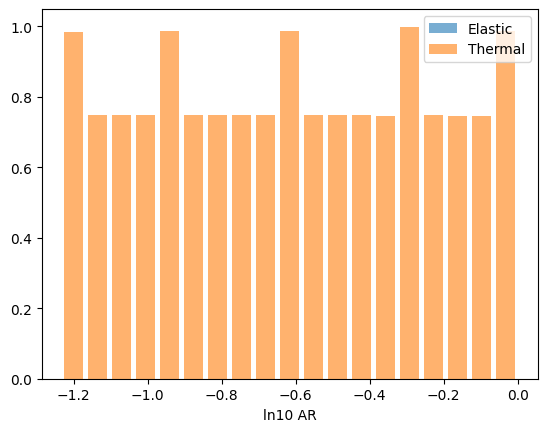

In [ ]:
plt.hist(np.log10(merged_data_elastic["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Elastic')

plt.hist(np.log10(merged_data_tc["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Thermal')

# plt.hist(np.log10(merged_data["AR inclusion"]), bins="sturges", density=True,
#          histtype='barstacked', rwidth=0.8, alpha=0.6, label='Electrical')

plt.legend()
plt.xlabel('ln10 AR')

Text(0.5, 0, 'f parametr')

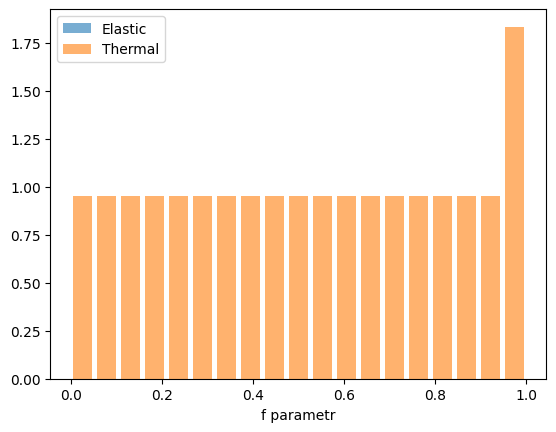

In [ ]:
plt.hist((merged_data_elastic["f_air"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Elastic')

plt.hist((merged_data_tc["f"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8, alpha=0.6, label='Thermal')

# plt.hist((merged_data["f"]), bins="sturges", density=True,
#          histtype='barstacked', rwidth=0.8, alpha=0.6, label='Electrical')

plt.legend()
plt.xlabel('f parametr')

In [ ]:
10**-0.8

0.15848931924611134

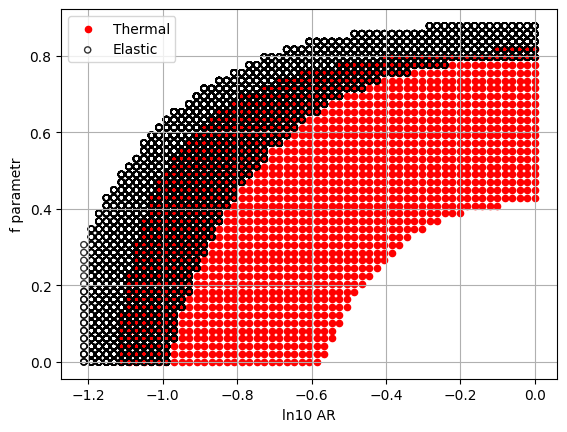

In [ ]:
plt.scatter(np.log10(merged_data_tc["AR inclusion"]),  merged_data_tc["f"], color='red', s=20, label='Thermal')


plt.scatter(np.log10(merged_data_elastic["AR inclusion"]),  merged_data_elastic["f_air"], alpha=0.8,
            s=20, label='Elastic',
            facecolors='none', edgecolors='black')

# plt.scatter(np.log10(merged_data["AR inclusion"]),  merged_data["f"], color='blue', s=40, label='Electrical')


plt.xlabel('ln10 AR')
plt.ylabel('f parametr')
plt.grid()
plt.legend()

# plt.ylim(0, 0.2)

In [ ]:
vel_air[:5]

Porosity,%  AR inclusion         f  K matrx air  Mu matrx air    Vp air    Vs air  \
700     0.08012      0.019179  0.000000    53.913734     27.232519  3.072580  2.006103   
701     0.08012      0.019179  0.020408    53.913734     27.232519  3.060623  1.999935   
702     0.08012      0.019179  0.040816    53.913734     27.232519  3.048316  1.993565   
703     0.08012      0.019179  0.061224    53.913734     27.232519  3.035642  1.986982   
704     0.08012      0.019179  0.081633    53.913734     27.232519  3.022584  1.980176   

     Vp_exp_air  Vs_exp_air  K_HSup_air  K_HSlo_air  Mu_HSup_air  Mu_HSlo_air  Vp_HSup_air  \
700       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
701       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
702       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
703       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   
704       4.248       2.562   44.321549    0.000028    23.322426     0.000023     5.395552   

     Vs_HSup_air  Vp_HSlo_air  Vs_HSlo_air     e_air  Diff Vp air  Diff Vs air   Diff  
700      3.00044     0.004768     0.003001  0.997293       -27.67       -21.70  35.16  
701      3.00044     0.004768     0.003001  0.997293       -27.95       -21.94  35.53  
702      3.00044     0.004768     0.003001  0.997293       -28.24       -22.19  35.92  
703      3.00044     0.004768     0.003001  0.997293       -28.54       -22.44  36.31  
704      3.00044     0.004768     0.003001  0.997293       -28.85       -22.71  36.72

### Thermal + Elastic + Electrical

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
### Merge Thermal conductivity
merged_data_tc = pd.merge(tc_air,
                       tc_water,
                       on=["AR inclusion", "f"], how='inner')

merged_data_tc = pd.merge(merged_data_tc,
                       tc_oil,
                       on=["AR inclusion", "f"], how='inner')

merged_data_tc[:5]

Porosity,%_x  AR inclusion    f  TCmtrx_air    TC_air  TC_HSup_air  TC_HSlo_air     e_air  \
0      0.236485       0.05857  0.0      2.8025  1.223749     1.924099     0.242329  0.963916   
1      0.236485       0.05857  0.0      2.8025  1.223749     1.924099     0.242329  0.963916   
2      0.236485       0.05857  0.0      2.8025  1.223749     1.924099     0.242329  0.963916   
3      0.236485       0.05857  0.0      2.8025  1.223749     1.924099     0.242329  0.963916   
4      0.236485       0.05857  0.0      2.8025  1.223749     1.924099     0.242329  0.963916   

   TC_exp_air  Diff TC air  Porosity,%_y  TCmtrx_water  TC_water  TC_HSup_water  TC_HSlo_water  \
0      1.2605         2.92      0.236485        2.8025  1.993435       2.151412       1.904238   
1      1.2605         2.92      0.236485        2.8025  1.993435       2.151412       1.904238   
2      1.2605         2.92      0.236485        2.8025  1.993435       2.151412       1.904238   
3      1.2605         2.92      0.236485        2.8025  1.993435       2.151412       1.904238   
4      1.2605         2.92      0.236485        2.8025  1.993435       2.151412       1.904238   

    e_water  TC_exp_water  Diff TC water  Porosity,%  TCmtrx_oil    TC_oil  TC_HSup_oil  \
0  0.963916      2.227387           10.5    0.236485     2.80250  1.433027     1.963819   
1  0.963916      2.227387           10.5    0.236485     2.87625  1.464699     2.014193   
2  0.963916      2.227387           10.5    0.236485     2.95000  1.496321     2.064566   
3  0.963916      2.227387           10.5    0.236485     3.02375  1.527896     2.114937   
4  0.963916      2.227387           10.5    0.236485     3.09750  1.559426     2.165309   

   TC_HSlo_oil     e_oil  TC_exp_oil  Diff TC oil  
0     0.861499  0.963916    1.662913        13.82  
1     0.868752  0.963916    1.662913        11.92  
2     0.875760  0.963916    1.662913        10.02  
3     0.882534  0.963916    1.662913         8.12  
4     0.889086  0.963916    1.662913         6.22

In [ ]:
### Find diff for thermal conductivity in diffrent saturation states

diff_columns_tc = merged_data_tc.filter(like='Diff').copy()
diff_columns_tc.loc[:, ["AR inclusion", "f"]] = merged_data_tc[["AR inclusion", "f"]]

matrix_nX3 = np.column_stack((diff_columns_tc["Diff TC air"],
                              diff_columns_tc["Diff TC water"],
                              diff_columns_tc["Diff TC oil"]))

diff_columns_tc["Diff TC fluid"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

# Normalization Линейное масштабирование
diff_columns_tc["Diff TC fluid"] = MinMaxScaler().fit_transform(np.array(diff_columns_tc["Diff TC fluid"]).reshape(-1, 1))

print(diff_columns_tc[:5])

   Diff TC air  Diff TC water  Diff TC oil  AR inclusion    f  Diff TC fluid
0         2.92           10.5        13.82       0.05857  0.0       0.159918
1         2.92           10.5        11.92       0.05857  0.0       0.144227
2         2.92           10.5        10.02       0.05857  0.0       0.129644
3         2.92           10.5         8.12       0.05857  0.0       0.116499
4         2.92           10.5         6.22       0.05857  0.0       0.105211


In [ ]:
### Merge Elastic properties
merged_data_elastic = pd.merge(vel_air,
                               vel_water,
                               on=["AR inclusion", "f"], suffixes=['_air', '_water'], how='inner')

NameError: name 'vel_air' is not defined

In [ ]:
### Find diff for elastic velocities in diffrent saturation states

diff_columns_elastic = merged_data_elastic.filter(like='Diff_').copy() # Diff include Vp and Vs relative diffrence
                                                                      # for Vp and Vs of the same saturation

diff_columns_elastic.loc[:, ["AR inclusion", "f"]] = merged_data_elastic[["AR inclusion", "f"]]

matrix_nX3 = np.column_stack((diff_columns_elastic["Diff_air"],
                              diff_columns_elastic["Diff_water"]))

diff_columns_elastic["Diff velocities fluid"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

# Normalization Линейное масштабирование
diff_columns_elastic["Diff velocities fluid"] = MinMaxScaler().fit_transform(np.array(diff_columns_elastic["Diff velocities fluid"]).reshape(-1, 1))

print(diff_columns_elastic[:5])

NameError: name 'merged_data_elastic' is not defined

In [ ]:
### Merge electric conductivity
merged_data_electric = pd.merge(electric_180,
                       electric_60,
                       on=["AR inclusion", "f"], how='inner')

merged_data_electric = pd.merge(merged_data_electric,
                       electric_6,
                       on=["AR inclusion", "f"], how='inner')

merged_data_electric[:5]

Porosity,%_x  AR inclusion         f    TC_180  TC_exp_180    e_180  \
0      0.141927      0.034286  0.000000  5.026920    2.626467  0.98823   
1      0.141927      0.034286  0.010101  1.908540    2.626467  0.98823   
2      0.141927      0.034286  0.020202  1.404061    2.626467  0.98823   
3      0.141927      0.034286  0.030303  1.195903    2.626467  0.98823   
4      0.141927      0.034286  0.040404  1.081292    2.626467  0.98823   

   Diff TC 180  Porosity,%_y      TC_60  TC_exp_60     e_60  Diff TC 60  \
0        67.23      0.141927  13.875388   5.854637  0.98823       48.83   
1        33.07      0.141927   4.494211   5.854637  0.98823       14.96   
2        64.86      0.141927   3.236355   5.854637  0.98823       33.54   
3        81.47      0.141927   2.734665   5.854637  0.98823       43.07   
4        91.91      0.141927   2.462602   5.854637  0.98823       49.00   

   Porosity,%        TC_6   TC_exp_6      e_6  Diff TC 6  
0    0.141927  109.085724  46.416085  0.98823      22.27  
1    0.141927   35.618719  46.416085  0.98823       6.90  
2    0.141927   25.675087  46.416085  0.98823      15.43  
3    0.141927   21.702911  46.416085  0.98823      19.81  
4    0.141927   19.547350  46.416085  0.98823      22.53

In [ ]:
### Find diff for electric conductivityin diffrent saturation states

diff_columns_electric = merged_data_electric.filter(like='Diff').copy()
diff_columns_electric.loc[:, ["AR inclusion", "f"]] = merged_data_electric[["AR inclusion", "f"]]

matrix_nX3 = np.column_stack((diff_columns_electric ["Diff TC 180"],
                              diff_columns_electric ["Diff TC 60"],
                              diff_columns_electric ["Diff TC 6"]))

diff_columns_electric["Diff Electric fluid"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

diff_columns_electric["Diff Electric fluid"] = MinMaxScaler().fit_transform(np.array(diff_columns_electric["Diff Electric fluid"]).reshape(-1, 1))

diff_columns_electric[:5]

Diff TC 180  Diff TC 60  Diff TC 6  AR inclusion         f  \
0        67.23       48.83      22.27      0.034286  0.000000   
1        33.07       14.96       6.90      0.034286  0.010101   
2        64.86       33.54      15.43      0.034286  0.020202   
3        81.47       43.07      19.81      0.034286  0.030303   
4        91.91       49.00      22.53      0.034286  0.040404   

   Diff Electric fluid  
0             0.366520  
1             0.152732  
2             0.316891  
3             0.402392  
4             0.455995

In [ ]:
### Merge Thermal, Elastic properties, Electrical properteis
merged_data_total = pd.merge(diff_columns_tc,
                               diff_columns_elastic,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total = pd.merge(merged_data_total,
                               diff_columns_electric,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total['Diff tc+velocities'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2)

merged_data_total['Diff tc+velocities+electrical'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2 + \
                                                             merged_data_total['Diff Electric fluid']**2)

merged_data_total[:5]

Diff TC air  Diff TC water  Diff TC oil  AR inclusion         f  \
0        21.78           9.53        22.99      0.034286  0.000000   
1        21.87           9.50        22.98      0.034286  0.010101   
2        21.95           9.48        22.98      0.034286  0.020202   
3        22.04           9.45        22.97      0.034286  0.030303   
4        22.13           9.42        22.96      0.034286  0.040404   

   Diff TC fluid  Diff_air  Diff_water  Diff velocities fluid  Diff TC 180  \
0       0.266809     10.09        4.85               0.045598        67.23   
1       0.267366     10.17        4.84               0.046081        33.07   
2       0.267966     10.28        4.83               0.046760        64.86   
3       0.268529     10.39        4.83               0.047470        81.47   
4       0.269094     10.50        4.83               0.048182        91.91   

   Diff TC 60  Diff TC 6  Diff Electric fluid  Diff tc+velocities  \
0       48.83      22.27             0.366520            0.270677   
1       14.96       6.90             0.152732            0.271308   
2       33.54      15.43             0.316891            0.272016   
3       43.07      19.81             0.402392            0.272692   
4       49.00      22.53             0.455995            0.273374   

   Diff tc+velocities+electrical  
0                       0.455634  
1                       0.311344  
2                       0.417627  
3                       0.486087  
4                       0.531662

In [ ]:
# X_train= np.array(merged_data_total["Diff tc+velocities"]).reshape(-1, 1)
# min_max_scaler = MinMaxScaler()
# X_train_minmax_1 = min_max_scaler.fit_transform(X_train)

In [ ]:
# X_train = np.array(merged_data_total["Diff tc+velocities+electrical"]).reshape(-1, 1)
# min_max_scaler = MinMaxScaler()
# X_train_minmax_2 = min_max_scaler.fit_transform(X_train)

(0.0, 1.0)

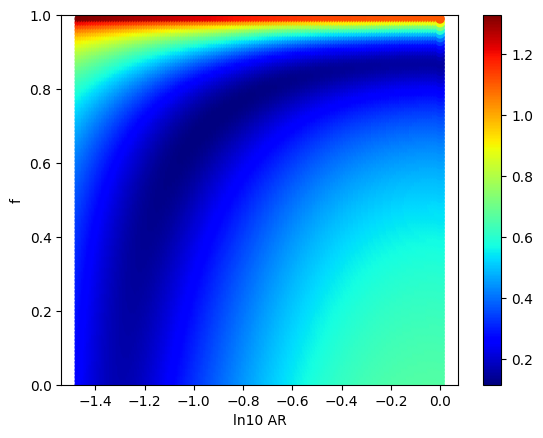

In [ ]:
scatter = plt.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                      c=merged_data_total['Diff tc+velocities'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

(0.0, 1.0)

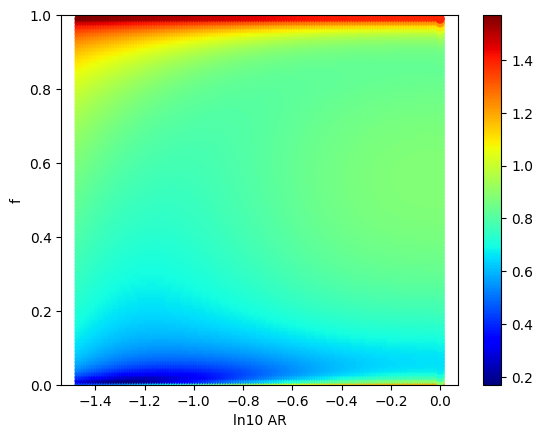

In [ ]:
scatter = plt.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                      c=merged_data_total['Diff tc+velocities+electrical'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

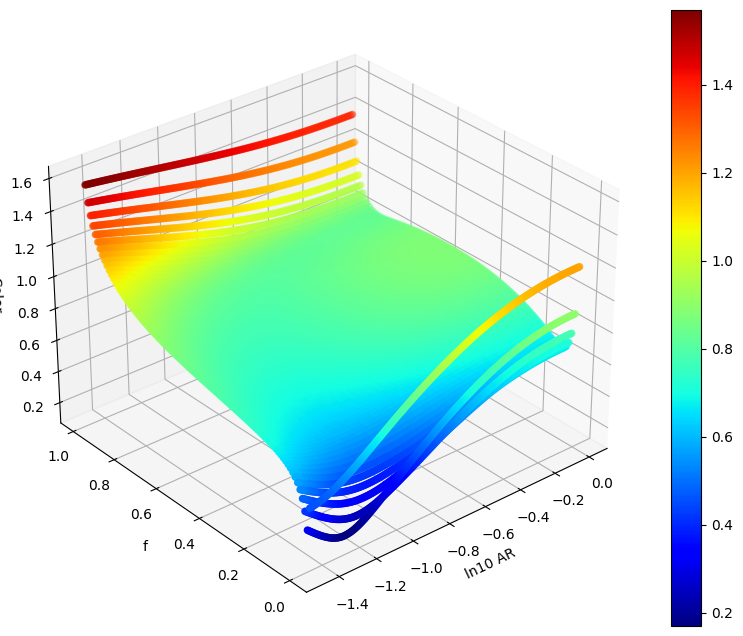

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))  # Set the figure size to be larger
ax = fig.add_subplot(111, projection='3d')

z_data = merged_data_total['Diff tc+velocities+electrical']
# z_data = merged_data_total['Diff tc+velocities']

# Create a 3D scatter plot
scatter = ax.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                     z_data , c=z_data , cmap='jet', marker='o')

# Add color bar to the plot
plt.colorbar(scatter)

# Set labels for the axes
ax.set_xlabel('ln10 AR')
ax.set_ylabel('f')
ax.set_zlabel('Color')

# Set initial viewing angle for rotation
ax.view_init(elev=30, azim=-130)  # Adjust the elevation (elev) and azimuth (azim) angles for desired rotation

plt.show()

In [ ]:
idx

3

In [ ]:
globals()[f"sample_{idx}_AR"] =  np.log10(merged_data_total["AR inclusion"])
globals()[f"sample_{idx}_f"] =  merged_data_total["f"]
globals()[f"sample_{idx}_diff"] = merged_data_total['Diff tc+velocities+electrical']

(array([0.80883871, 0.80883871, 0.80883871, 0.80883871, 0.80883871,
        0.80883871, 0.71896774, 0.80883871, 0.80883871, 0.80883871,
        0.80883871, 0.80883871, 0.80883871, 0.80883871]),
 array([-1.24623116, -1.15721464, -1.06819813, -0.97918162, -0.89016511,
        -0.8011486 , -0.71213209, -0.62311558, -0.53409907, -0.44508256,
        -0.35606604, -0.26704953, -0.17803302, -0.08901651,  0.        ]),
 <BarContainer object of 14 artists>)

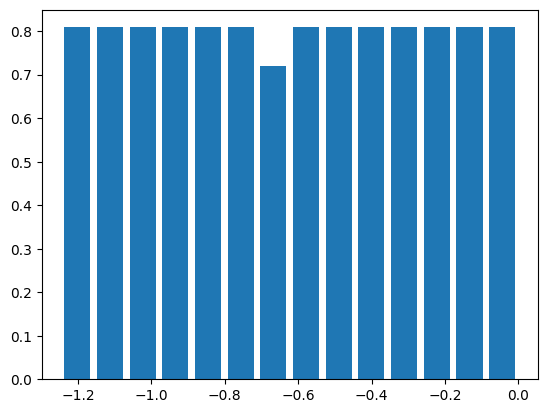

In [ ]:
plt.hist(np.log10(merged_data_total["AR inclusion"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

(array([1.16666667, 0.875     , 1.16666667, 0.875     , 1.16666667,
        0.875     , 0.875     , 1.16666667, 0.875     , 1.16666667,
        0.875     , 1.16666667, 0.875     , 1.16666667]),
 array([0.        , 0.06997085, 0.13994169, 0.20991254, 0.27988338,
        0.34985423, 0.41982507, 0.48979592, 0.55976676, 0.62973761,
        0.69970845, 0.7696793 , 0.83965015, 0.90962099, 0.97959184]),
 <BarContainer object of 14 artists>)

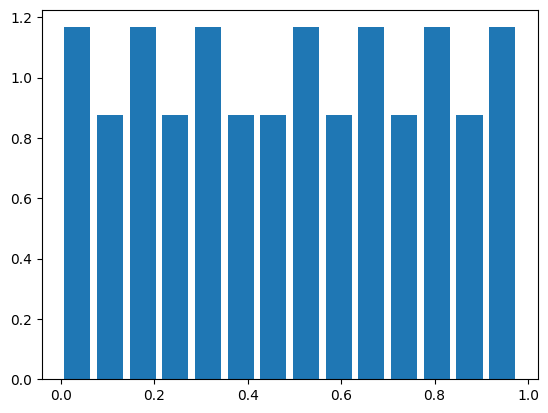

In [ ]:
plt.hist(merged_data_total["f"], bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)

In [ ]:
for i in range(0, 4):
  globals()[f"sample_{i}"] = pd.DataFrame()

  globals()[f"sample_{i}"][f'AR'] = globals()[f"sample_{i}_AR"]
  globals()[f"sample_{i}"][f'f'] = globals()[f"sample_{i}_f"]
  globals()[f"sample_{i}"][f'Diff'] = globals()[f"sample_{i}_diff"]

In [ ]:
sample_2[:5]

AR         f      Diff
0 -1.444816  0.000000  0.472440
1 -1.444816  0.010101  0.346101
2 -1.444816  0.020202  0.452725
3 -1.444816  0.030303  0.522056
4 -1.444816  0.040404  0.568524

In [ ]:
merged_sample = pd.DataFrame()

merged_sample = pd.merge(sample_0, sample_1,
                       on=["AR", "f"], how='inner')

merged_sample = pd.merge(merged_sample,
                       sample_2,
                       on=["AR", "f"], how='inner')

merged_sample = pd.merge(merged_sample,
                       sample_3, suffixes=['_1', '_2'],
                       on=["AR", "f"], how='inner')

merged_sample['Diff total'] = np.sqrt(merged_sample['Diff_x']**2 + \
                                      merged_sample['Diff_y']**2 + \
                                      merged_sample['Diff_1']**2 + \
                                      merged_sample['Diff_2']**2)

In [ ]:
merged_sample[:5]

AR         f    Diff_x    Diff_y    Diff_1    Diff_2  Diff total
0 -1.444816  0.000000  0.128666  0.206756  0.472440  0.459607    0.702667
1 -1.444816  0.010101  0.412947  0.454116  0.346101  0.289703    0.761880
2 -1.444816  0.020202  0.544115  0.579427  0.452725  0.398151    0.997638
3 -1.444816  0.030303  0.615919  0.648243  0.522056  0.469053    1.136718
4 -1.444816  0.040404  0.662027  0.692436  0.568524  0.516446    1.227878

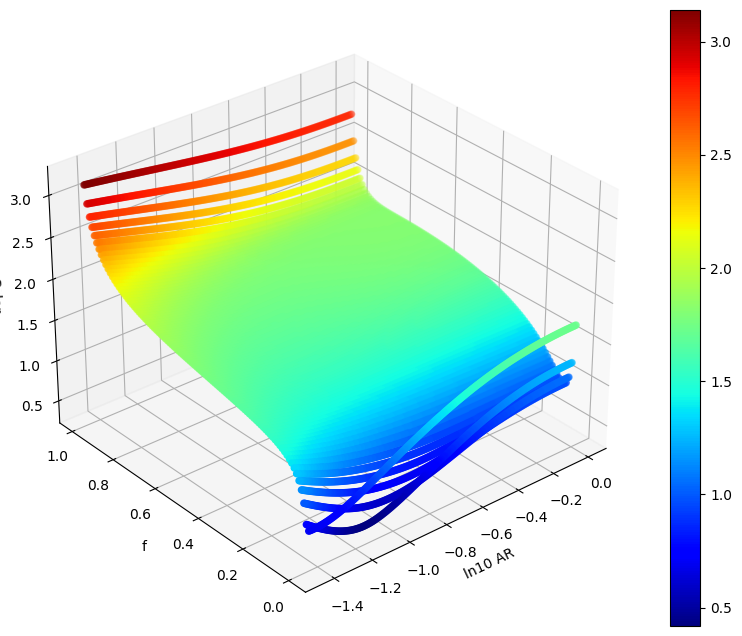

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))  # Set the figure size to be larger
ax = fig.add_subplot(111, projection='3d')

z_data = merged_sample['Diff total']
# z_data = merged_data_total['Diff tc+velocities']

# Create a 3D scatter plot
scatter = ax.scatter(merged_sample["AR"], merged_sample["f"],
                     z_data , c=z_data , cmap='jet', marker='o')

# Add color bar to the plot
plt.colorbar(scatter)

# Set labels for the axes
ax.set_xlabel('ln10 AR')
ax.set_ylabel('f')
ax.set_zlabel('Color')

# Set initial viewing angle for rotation
ax.view_init(elev=30, azim=-130)  # Adjust the elevation (elev) and azimuth (azim) angles for desired rotation

plt.show()

(0.0, 1.0)

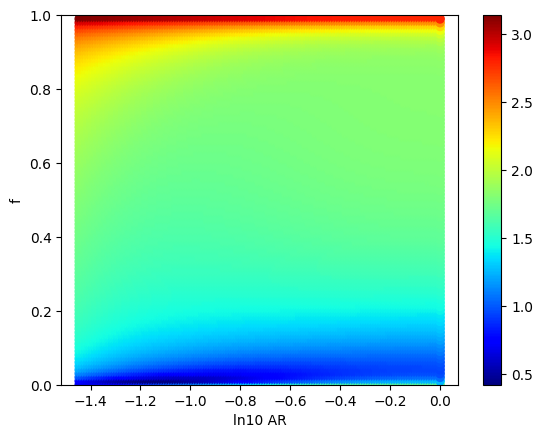

In [ ]:
scatter = plt.scatter(merged_sample["AR"], merged_sample["f"],
                      c=merged_sample['Diff total'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')

plt.ylim(0, 1)

# One porosity f-model

In [22]:
path_to_ser = Path('/content/NewElasticity_v1/f model.xlsx')
df_ues_ar = pd.read_excel(path_to_ser, skiprows=0)

In [23]:
df_ues_ar.columns

Index(['#', 'Sample', 'Well', 'Litholohy', 'Porosity,%', 'Permeability', 'Density (air)',
       'Density (water)', 'Density (oil)', 'Vp air', 'Vs air', 'Vp oil', 'Vs oil', 'Vp water',
       'Vs water', 'Unnamed: 15', 'AR thermal', 'AO electrical', 'AR elastic', 'Unnamed: 19',
       'TC air', 'TC oil', 'TC 0,6', 'TC 6', 'TC 60', 'TC 180', 'Unnamed: 26', 'Скважина', 'R 0.6',
       'R 6', 'R 60', 'R 180', 'Unnamed: 32', 'Unnamed: 33', 'УЭС, Ом*м', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Провод-ть, См/м', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41'],
      dtype='object')

In [24]:
df_ues_ar.dropna(subset=['Porosity,%'], inplace=True)

### Main calculation

In [121]:
# Matrix value changes within error
def double_porosity(fluid, lam_fluid, lam_matrix_list, porosity,
                    experemental_value, prop):

  ###
  # prop: str, physical property to name columns
  ###

  data_fluid = []

  tc_eff_list, f_result, ar_result = [], [], []
  tc_mtrx = []
  crack_porosity_list = []
  hs_up_list, hs_lo_list = [], []

  globals()[f'result_{fluid}'] = pd.DataFrame()
  globals()[f'sorted_{fluid}'] = pd.DataFrame()

  lam_fluid = lam_fluid
  print(fluid, lam_fluid)


  N, n = 200, 100 # Amount of nodes


  for matrix_value in lam_matrix_list:
    for f in np.linspace(0, 1, n):
      for ar_cracks in np.logspace(-3, 0,  N, base=10):

        conc = [1-porosity, porosity]
        AR_pore = 1.
        alpha_shape = [1, ar_cracks]
        lam = [matrix_value, lam_fluid]

        lam_eff = effective_tc_f(conc, alpha_shape, lam, f)

        # print(conc, alpha_shape, lam, lam_eff, f)

        tc_eff_list.append(lam_eff)
        f_result.append(f)
        ar_result.append(ar_cracks)
        tc_mtrx.append(matrix_value)
        # crack_porosity_list.append(crack_porosity)

        hs_up_list.append(Upper_Hashin_Strikman(conc, lam))
        hs_lo_list.append(Lower_Hashin_Strikman(conc, lam))

  globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity]*len(tc_eff_list)
  globals()[f'result_{fluid}'][f'AR inclusion'] = ar_result
  globals()[f'result_{fluid}'][f'f'] = f_result
  # globals()[f'result_{fluid}'][f'crack porosity'] = crack_porosity_list
  globals()[f'result_{fluid}'][f'{prop}_mtrx_{fluid}'] = tc_mtrx
  globals()[f'result_{fluid}'][f'{prop}_{fluid}'] = tc_eff_list

  globals()[f'result_{fluid}'][f'{prop}_HSup_{fluid}'] = hs_up_list
  globals()[f'result_{fluid}'][f'{prop}_HSlo_{fluid}'] = hs_lo_list

  globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])
  globals()[f'result_{fluid}'][f'{prop}_exp_{fluid}'] = [experemental_value]*len(tc_eff_list)

  # print(globals()[f'result_{fluid}'].shape)



  # globals()[f'result_{fluid}'][f'TC_HSup_{fluid}'] = Upper_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # globals()[f'result_{fluid}'][f'TC_HSlo_{fluid}'] =  Lower_Hashin_Strikman([1-globals()[f'result_{fluid}'][f'Porosity,%'], globals()[f'result_{fluid}'][f'Porosity,%']],
  #                                                                         [globals()[f"lam_mtrx_{fluid}"], lam_fluid])

  # Calculate the difference and assign it directly to the new column 'Diff Vp air'
  TC_exp = globals()[f'result_{fluid}'][f'{prop}_exp_{fluid}']
  globals()[f'result_{fluid}'][f'Diff {prop} {fluid}'] = abs(np.round((globals()[f'result_{fluid}'][f'{prop}_{fluid}'] - TC_exp) / TC_exp * 100, 2))
  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

  # print(globals()[f'result_{fluid}'].shape)

  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
  (globals()[f'result_{fluid}'][f'{prop}_{fluid}'] >= globals()[f'result_{fluid}'][f'{prop}_HSlo_{fluid}']) &
  (globals()[f'result_{fluid}'][f'{prop}_{fluid}'] <= globals()[f'result_{fluid}'][f'{prop}_HSup_{fluid}'])
]


  # globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}'], key=lambda x: x.abs())

  return globals()[f'result_{fluid}']

In [122]:
# # Merge all states function
# def merge_table(selected_row_air, selected_row_water, selected_row_oil, idx):
#   globals()[f"merged_data_{idx}"] = pd.merge(selected_row_air, selected_row_water,
#                   on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

#   globals()[f"merged_data_{idx}"] = pd.merge(globals()[f"merged_data_{idx}"], selected_row_oil,
#                       on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

#   globals()[f"merged_data_{idx}"]['total diff'] = np.sqrt(globals()[f"merged_data_{idx}"]["Diff TC air"]**2 + \
#                                   globals()[f"merged_data_{idx}"]["Diff TC water"]**2 +\
#                                   globals()[f"merged_data_{idx}"]["Diff TC oil"]**2 )

#   print('merge shape func', globals()[f"merged_data_{idx}"].shape[0])
#   return globals()[f"merged_data_{idx}"]


# Merge all states function
def merge_table(selected_row_air, selected_row_water, selected_row_oil, prop):

  merged_data = pd.DataFrame()

  merged_data = pd.merge(selected_row_air, selected_row_water,
                  on=["AR inclusion", "f"], suffixes=('_air', '_water'), how='inner')

  merged_data = pd.merge(merged_data, selected_row_oil,
                      on=["AR inclusion", "f"], suffixes=('_merged', '_oil'), how='inner')

  merged_data[f'total diff {prop}'] = np.sqrt(merged_data[f"Diff {prop} air"]**2 + \
                                   merged_data[f"Diff {prop} water"]**2 +\
                                   merged_data[f"Diff {prop} oil"]**2 )
  return merged_data

### Thermal

In [123]:
def thermal_calculation(idx, prop, experemental_error = True):
  ###
  # experemental_error = True: выбор значений по расхождению с эксериментальным
  # данными


  fluid_list_full = ['air', 'water', 'oil']

  print(idx)
  porosity = df_ues_ar["Porosity,%"][idx]
  print(porosity)

  if np.isnan(porosity):
    pass

  else:

    global lam_air, lam_water, lam_oil
    global lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil
    global error_air, error_water, error_oil
    global air_tc_exp, water_tc_exp, oil_tc_exp

    porosity /= 100
    # Experemental values
    air_tc_exp = df_ues_ar["TC air"][idx]
    water_tc_exp = df_ues_ar["TC 6"][idx]
    oil_tc_exp = df_ues_ar["TC oil"][idx]
    print(porosity, air_tc_exp, water_tc_exp, oil_tc_exp)


    lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
    lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

    # Error in mineral matrix values
    error_air, error_water, error_oil = 0.0, 0.0, 0.0 # Error for K, mu minreal matrix
    N = 1

    globals()[f"merged_data_{idx}"] = pd.DataFrame()

    if experemental_error==False:

      for fluid in fluid_list_full:
        globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
            globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"], N)
        # print(globals()[f"lam_mtrx_{fluid}_list"])
        globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                        globals()[f"lam_{fluid}"],
                                                        globals()[f"lam_mtrx_{fluid}_list"],
                                                        porosity,
                                                        globals()[f"{fluid}_tc_exp"],
                                                        prop)

      globals()[f"merged_data_{idx}"] = merge_table(result_air,
                                                    result_water,
                                                    result_oil,
                                                    prop)

    else:

      # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
      # то проводиться новый расчет с ошибкой увеличенной на 2,5%
      # globals()[f"merged_data_{idx}"] = pd.DataFrame()
      error = 2.5

      while globals()[f"merged_data_{idx}"].shape[0] == 0:
        # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])

        for fluid in fluid_list_full:

          globals()[f"selected_row_{fluid}"] = pd.DataFrame()
          globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                            globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                            N)
          # print(globals()[f"lam_mtrx_{fluid}_list"])
          globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                          globals()[f"lam_{fluid}"],
                                                          globals()[f"lam_mtrx_{fluid}_list"],
                                                          porosity,
                                                          globals()[f"{fluid}_tc_exp"],
                                                          prop = 'TC')

          globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff {prop} {fluid}']) <= error)]

        globals()[f"merged_data_{idx}"] = merge_table(selected_row_air,
                                                      selected_row_water,
                                                      selected_row_oil,
                                                      prop)
        print(error)
        error +=2.5


    # Pd DataFrame for each sample
    globals()[f"sample_{idx}_{prop}"] = pd.DataFrame()
    globals()[f"sample_{idx}_{prop}"] = globals()[f"merged_data_{idx}"]
    globals()[f"sample_{idx}_{prop}"].to_csv(f'/content/Sample_one_porosity_{prop}_{idx}.csv', index=True)
    globals()[f"sample_{idx}_{prop}"].to_csv(f'/content/drive/My Drive/Sample_one_porosity_{prop}_{idx}.csv', index=False)

    # # Plot data
    # data = globals()[f"sample_{idx}"]
    # scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
    #                       c=data["total diff"], cmap='jet', marker='o')'
    # plt.colorbar(scatter)

    # plt.xlabel('ln10 AR')
    # plt.ylabel('f')
    # plt.ylim(0, 1)

### Electrical

In [124]:
def electrical_calculation(idx, prop, experemental_error = True):
  ###
  # experemental_error = True: выбор значений по расхождению с эксериментальным
  # данными

  # for number in range(0, len(df_ues_ar["#"])):
  fluid_list_full = ['air', 'water', 'oil']


  print(idx)
  porosity = df_ues_ar["Porosity,%"][idx]
  print(porosity)

  if np.isnan(porosity):
    pass

  else:

    global elec_air, elec_water, elec_oil
    global elec_mtrx_air, elec_mtrx_water, elec_mtrx_oil
    global error_air, error_water, error_oil
    global air_elec_exp, water_elec_exp, oil_elec_exp

    porosity /= 100
    # Experemental values
    air_elec_exp = 1/ df_ues_ar["R 6"][idx]
    water_elec_exp = 1 / df_ues_ar["R 60"][idx]
    oil_elec_exp = 1/ df_ues_ar["R 180"][idx]

    print(porosity, air_elec_exp, water_elec_exp, oil_elec_exp)

    elec_air, elec_water, elec_oil = 1.060, 8.42, 18.87
    elec_mtrx_air, elec_mtrx_water, elec_mtrx_oil = 1.82*10**-3, 1.43*10**-2, 4.00*10**-2

    # Error in mineral matrix values
    error_air, error_water, error_oil = 0.0, 0.0, 0.0 # Error for K, mu minreal matrix
    N = 1

    globals()[f"merged_data_{idx}"] = pd.DataFrame()

    if experemental_error==False:

      for fluid in fluid_list_full:
        globals()[f"elec_mtrx_{fluid}_list"] = np.linspace(globals()[f"elec_mtrx_{fluid}"] - globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
            globals()[f"elec_mtrx_{fluid}"] + globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"], N)
        # print(globals()[f"elec_mtrx_{fluid}_list"])
        globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                        globals()[f"elec_{fluid}"],
                                                        globals()[f"elec_mtrx_{fluid}_list"],
                                                        porosity,
                                                        globals()[f"{fluid}_elec_exp"],
                                                        prop )

      globals()[f"merged_data_{idx}"] = merge_table(result_air, result_water, result_oil, prop)

    else:

      # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
      # то проводиться новый расчет с ошибкой увеличенной на 2,5%
      error = 2.5

      while globals()[f"merged_data_{idx}"].shape[0] == 0:
        # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])

        for fluid in fluid_list_full:

          globals()[f"selected_row_{fluid}"] = pd.DataFrame()
          globals()[f"elec_mtrx_{fluid}_list"] = np.linspace(globals()[f"elec_mtrx_{fluid}"] - globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                            globals()[f"elec_mtrx_{fluid}"] + globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                            N)
          # print(globals()[f"elec_mtrx_{fluid}_list"])
          globals()[f'result_{fluid}'] = double_porosity(fluid,
                                                          globals()[f"elec_{fluid}"],
                                                          globals()[f"elec_mtrx_{fluid}_list"],
                                                          porosity,
                                                          globals()[f"{fluid}_elec_exp"],
                                                          prop)

          globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff {prop} {fluid}']) <= error)]

        globals()[f"merged_data_{idx}"] = merge_table(selected_row_air, selected_row_water, selected_row_oil, prop)
        print(error)
        error +=2.5


    # Pd DataFrame for each sample
    globals()[f"sample_{idx}_{prop}"] = pd.DataFrame()
    globals()[f"sample_{idx}_{prop}"] = globals()[f"merged_data_{idx}"]
    globals()[f"sample_{idx}_{prop}"].to_csv(f'/content/Sample_one_porosity_{prop}_{idx}.csv', index=True)
    globals()[f"sample_{idx}_{prop}"].to_csv(f'/content/drive/My Drive/Sample_one_porosity_{prop}_{idx}.csv', index=False)

    # # Plot data
    # data = globals()[f"sample_{idx}"]
    # scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
    #                       c=data["total diff"], cmap='jet', marker='o')'
    # plt.colorbar(scatter)

    # plt.xlabel('ln10 AR')
    # plt.ylabel('f')
    # plt.ylim(0, 1)

### Elastic

In [ ]:
# Vp_exp_air, Vs_exp_air = df_ues_ar["Vp air"][idx], df_ues_ar["Vs air"][idx]
# Vp_exp_water, Vs_exp_water = df_ues_ar["Vp water"][idx], df_ues_ar["Vs water"][idx]

# density_air, density_water = df_ues_ar["Density (air)"][idx], df_ues_ar["Density (water)"][idx]
# p_air, p_water = density_air, density_water

In [125]:
def double_porosity_elastic(fluid, K_fluid, Mu_fluid, lam_matrix_list, density_fluid, porosity,
                    experemental_value, prop):

  eps = 10**-5

  data_fluid = []

  Vp_fluid_list = []
  Vs_fluid_list = []
  K_mtrx_var, mu_mtrx_var = [], []
  AR_cracks_list, f_list, crack_porosity_list = [], [], []
  K_hs_up_list, K_hs_lo_list = [], []
  Mu_hs_up_list, Mu_hs_lo_list = [], []
  pore_porosity = []

  globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)

  K_fluid, Mu_fluid = K_fluid, Mu_fluid

  N, n = 200, 100

  for K_matrix_value, Mu_matrix_value in zip(lam_matrix_list[0], lam_matrix_list[1]):
    for f in np.linspace(0, 1, n):
      for ar_cracks in np.logspace(-3, 0, num=N, base=10):

        AR_mtrx = 1.00001
        k, mu = K_matrix_value, Mu_matrix_value

        AR_cracks_list.append(ar_cracks)
        f_list.append(f)
        # crack_porosity_list.append(crack_porosity)

        K_matrix, Mu_matrix = k, mu
        K_mtrx_var.append(K_matrix)
        mu_mtrx_var.append(Mu_matrix)
        pore_porosity.append(porosity)
        crack_porosity = 0

        K, Mu = main_Berryman_common_double_porosity(AR_mtrx, ar_cracks,
                                      k, mu,
                                      globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"],
                                      porosity, f)
        density_mtrx, density_fluid = 2.71, density_fluid
        Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

        Vp_fluid_list.append(Vp)
        Vs_fluid_list.append(Vs)


  globals()[f'result_{fluid}'][f'Porosity,%'] = [porosity] * len(Vp_fluid_list)
  globals()[f'result_{fluid}'][f'Pore Porosity,%'] = pore_porosity
  globals()[f'result_{fluid}'][f'AR inclusion'] = AR_cracks_list
  globals()[f'result_{fluid}'][f'f'] = f_list
  # globals()[f'result_{fluid}'][f'crack porosity'] = crack_porosity_list

  globals()[f'result_{fluid}'][f'K matrx {fluid}'] = K_mtrx_var
  globals()[f'result_{fluid}'][f'Mu matrx {fluid}'] = mu_mtrx_var

  globals()[f'result_{fluid}'][f'Vp {fluid}'] = Vp_fluid_list
  globals()[f'result_{fluid}'][f'Vs {fluid}'] = Vs_fluid_list

  globals()[f'result_{fluid}'][f'Vp_exp_{fluid}'] = [experemental_value[0]] * len(Vs_fluid_list)
  globals()[f'result_{fluid}'][f'Vs_exp_{fluid}'] = [experemental_value[1]] * len(Vs_fluid_list)

###  HS_borders

  globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], _, _, _, _ =\
  HS_borders(
  [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
  [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
  [1 - porosity, porosity])

  _, _, _, globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'], _ =\
  HS_borders(
  [globals()[f'result_{fluid}'][f'K matrx {fluid}'], globals()[f"K_{fluid}"]],
  [globals()[f'result_{fluid}'][f'Mu matrx {fluid}'], globals()[f"Mu_{fluid}"]],
  [1 - porosity, porosity])


  globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'] = \
  modulus2velosity(2.71, density_fluid,
                  porosity,
                  globals()[f'result_{fluid}'][f'K_HSup_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSup_{fluid}'])


  globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}'] = \
  modulus2velosity(2.71, density_fluid,
                  porosity,
                  globals()[f'result_{fluid}'][f'K_HSlo_{fluid}'], globals()[f'result_{fluid}'][f'Mu_HSlo_{fluid}'])

### Selection
  globals()[f'result_{fluid}'][f'e_{fluid}'] = 3*globals()[f'result_{fluid}'][f'Porosity,%'] / (4 * pi * globals()[f'result_{fluid}'][f'AR inclusion'])
  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][globals()[f'result_{fluid}'][f'e_{fluid}']<=1] # Select only void density < 1

  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
  (globals()[f'result_{fluid}'][f'Vp {fluid}'] >= globals()[f'result_{fluid}'][f'Vp_HSlo_{fluid}']) &
  (globals()[f'result_{fluid}'][f'Vp {fluid}'] <= globals()[f'result_{fluid}'][f'Vp_HSup_{fluid}'])
]

  globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'][
  (globals()[f'result_{fluid}'][f'Vs {fluid}'] >= globals()[f'result_{fluid}'][f'Vs_HSlo_{fluid}']) &
  (globals()[f'result_{fluid}'][f'Vs {fluid}'] <= globals()[f'result_{fluid}'][f'Vs_HSup_{fluid}'])
]


  Vp_exp, Vs_exp = globals()[f"Vp_exp_{fluid}"], globals()[f"Vs_exp_{fluid}"]

### Relative diffrence between calculated and experimntal velocities
  globals()[f'result_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'result_{fluid}'][[f'Vp {fluid}']]\
  .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)

  globals()[f'result_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'result_{fluid}'][[f'Vs {fluid}']]\
  .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
  globals()[f'result_{fluid}'][f'Diff {prop} {fluid}'] = globals()[f'result_{fluid}']\
  .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

  return globals()[f'result_{fluid}']

In [126]:
def elastic_calculation(idx, prop, experemental_error = True):

  ###
  # experemental_error = True: выбор значений по расхождению с эксериментальным
  # данными

  # for number in range(0, len(df_ues_ar["#"])):



  fluid_list_full = ['air', 'water', 'oil']

  print(idx)
  porosity = df_ues_ar["Porosity,%"][idx]

  if np.isnan(porosity):
    pass

  else:

    global K_air, K_water, K_oil
    global Mu_air, Mu_water, Mu_oil
    global p_air, p_water, p_oil
    global K_air_mtrx, K_water_mtrx, K_oil_mtrx
    global Mu_air_mtrx, Mu_water_mtrx, Mu_oil_mtrx
    global error_air, error_water, error_oil

    global Vp_exp_air, Vp_exp_water, Vp_exp_oil
    global Vs_exp_air, Vs_exp_water, Vs_exp_oil

    porosity /= 100
    # Experemental values
    Vp_exp_air, Vs_exp_air = df_ues_ar["Vp air"][idx], df_ues_ar["Vs air"][idx]
    Vp_exp_water, Vs_exp_water = df_ues_ar["Vp water"][idx], df_ues_ar["Vs water"][idx]
    Vp_exp_oil, Vs_exp_oil = df_ues_ar["Vp oil"][idx], df_ues_ar["Vs oil"][idx]

    density_air, density_water, density_oil = df_ues_ar["Density (air)"][idx], df_ues_ar["Density (water)"][idx], df_ues_ar["Density (oil)"][idx]
    p_air, p_water, p_oil = density_air, density_water, density_oil

    # print(porosity, Vp_exp_air, Vs_exp_air)
    # print(porosity, Vp_exp_water, Vs_exp_water)
    # print(porosity, Vp_exp_oil, Vs_exp_oil)

    Vp_reg_air, Vs_reg_air = 5.77, 3.17
    Vp_reg_water, Vs_reg_water = 6.13, 3.25
    Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

    K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
    K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
    K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

    K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
    K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
    K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04


    # Error in mineral matrix values
    error_air, error_water, error_oil = 0.0, 0.0, 0.0 # Error for K, mu minreal matrix
    N = 1



    globals()[f"merged_data_{idx}"] = pd.DataFrame()

    if experemental_error==False:

      for fluid in fluid_list_full:
        globals()[f"K_mtrx_{fluid}_list"] = np.linspace(globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                        globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * globals()[f"error_{fluid}"], N)

        globals()[f"Mu_mtrx_{fluid}_list"] = np.linspace(globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                          globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * globals()[f"error_{fluid}"], N)

        lam_matrix_list = [globals()[f"K_mtrx_{fluid}_list"], globals()[f"Mu_mtrx_{fluid}_list"]]
        experemental_value = [globals()[f"Vp_exp_{fluid}"], globals()[f"Vs_exp_{fluid}"]]

        globals()[f'result_{fluid}'] = double_porosity_elastic(fluid, globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"],
                                                          lam_matrix_list,
                                                          globals()[f"p_{fluid}"],
                                                          porosity,
                                                          experemental_value, prop)

      globals()[f"merged_data_{idx}"] = merge_table(result_air, result_water, result_oil, prop)

    else:

      # Цикл - если в обобщенной таблице для нескольких состояний, число строк равно нулю,
      # то проводиться новый расчет с ошибкой увеличенной на 2,5%
      error = 2.5

      while globals()[f"merged_data_{idx}"].shape[0] == 0:
        # print("error: ", error, globals()[f"merged_data_{idx}"].shape[0])

        for fluid in fluid_list_full:

          globals()[f"selected_row_{fluid}"] = pd.DataFrame()
          globals()[f"elec_mtrx_{fluid}_list"] = np.linspace(globals()[f"elec_mtrx_{fluid}"] - globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                            globals()[f"elec_mtrx_{fluid}"] + globals()[f"elec_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                            N)

          globals()[f'result_{fluid}'] = double_porosity_elastic(fluid, globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"],
                                                                  [globals()[f"K_mtrx_{fluid}_list"], globals()[f"Mu_mtrx_{fluid}_list"]],
                                                                  globals()[f"p_{fluid}"],
                                                                  porosity,
                                                                  [globals()[f"Vp_exp_{fluid}"], globals()[f"Vs_exp_{fluid}"]],
                                                                  prop)

          globals()[f"selected_row_{fluid}"] = globals()[f'result_{fluid}'][(abs(globals()[f'result_{fluid}'][f'Diff {prop} {fluid}']) <= error)]

        globals()[f"merged_data_{idx}"] = merge_table(selected_row_air, selected_row_water, selected_row_oil, prop)
        print(error)
        error +=2.5


    # Pd DataFrame for each sample
    globals()[f"sample_{idx}_{prop}"] = pd.DataFrame()
    globals()[f"sample_{idx}_{prop}"] = globals()[f"merged_data_{idx}"]
    globals()[f"sample_{idx}_{prop}"].to_csv(f'/content/Sample_one_porosity_{prop}_{idx}.csv', index=True)
    globals()[f"sample_{idx}_{prop}"].to_csv(f'/content/drive/My Drive/Sample_one_porosity_{prop}_{idx}.csv', index=False)


    # # Plot data
    # data = globals()[f"sample_{idx}"]
    # scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
    #                       c=data["total diff"], cmap='jet', marker='o')'
    # plt.colorbar(scatter)

    # plt.xlabel('ln10 AR')
    # plt.ylabel('f')
    # plt.ylim(0, 1)

In [128]:
def main():
    from google.colab import drive
    drive.mount('/content/drive')
    # for number in range(0, len(df_ues_ar["#"])):
    # for idx in range(0, 33):
    for idx in range(2, 3):
        try:
            thermal_calculation(idx, prop='TC', experemental_error = False)
            electrical_calculation(idx, prop='Elec', experemental_error = False)
            elastic_calculation(idx, prop='Elas', experemental_error=False)
        except KeyError as e:
            print(f"KeyError: {e}. Skipping to the next index.")
            continue
            return  # Exit the function if file is not found

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2
15.0242881386861
0.15024288138686098 1.85855 2.5147125 2.23458197098924
air 0.025
water 0.6
oil 0.12
2
15.0242881386861
0.15024288138686098 0.022015148835918076 0.1722884920845609 0.3844028259242765
air 1.06
water 8.42
oil 18.87
2
90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


<ipython-input-125-25510528c646>:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
<ipython-input-125-25510528c646>:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)
<ipython-input-14-a336f510f645>:5: RuntimeWarning: invalid value encountered in sqrt
  Vs = np.sqrt(Mu/density)
<ipython-input-125-25510528c646>:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

### Plots

In [129]:
def make_plot(idx, prop):
    try:
        path_to_ser = Path(f'/content/Sample_one_porosity_{prop}_{idx}.csv')
        globals()[f"Sample_{idx}"] = pd.read_csv(path_to_ser, skiprows=0)
    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")
        return  # Exit the function if file is not found


    data = globals()[f"Sample_{idx}"]

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    for ax in axs:
      ax.set_title(f'Sample {idx}, {prop}')

    # # First scatter plot
    # scatter1 = axs[0].scatter(np.log10(data["AR inclusion"]), data["crack porosity"]*100,
    #                           c=data[f"total diff {prop}"], cmap='jet', marker='o')
    # axs[0].set_xlabel('log10(AR cracks)')
    # axs[0].set_ylabel('Crack porosity, %')
    # axs[0].set_xlim(-4, -2)
    # axs[0].set_ylim(0, 3)
    # colorbar1 = plt.colorbar(scatter1, ax=axs[0])
    # colorbar1.set_label('невязка по 3м флюидам, %')


    # Second scatter plot
    scatter2 = axs[1].scatter(data["e_air"], data['f'],
                              c=data[f"total diff {prop}"], cmap='jet', marker='o')

    axs[1].set_ylabel('f')
    axs[1].set_xlabel('Pore density, %')
    # axs[1].set_ylim(0, 0.1)
    # axs[1].set_xlim(0, 3)
    colorbar2 = plt.colorbar(scatter2, ax=axs[1])
    colorbar2.set_label('невязка по 3м флюидам, %')



    # Third scatter plot
    scatter3 = axs[2].scatter(np.log10(data["AR inclusion"]), data['f'],
                              c=data[f"total diff {prop}"], cmap='jet', marker='o')
    axs[2].set_ylabel('f')
    axs[2].set_xlabel('log10(AR)')
    # axs[2].set_ylim(0, 0.1)
    # axs[2].set_xlim(-4, -2)
    colorbar3 = plt.colorbar(scatter3, ax=axs[2])
    colorbar3.set_label('невязка по 3м флюидам, %')

    plt.tight_layout()
    plt.show()

In [132]:
idx_list = [2]

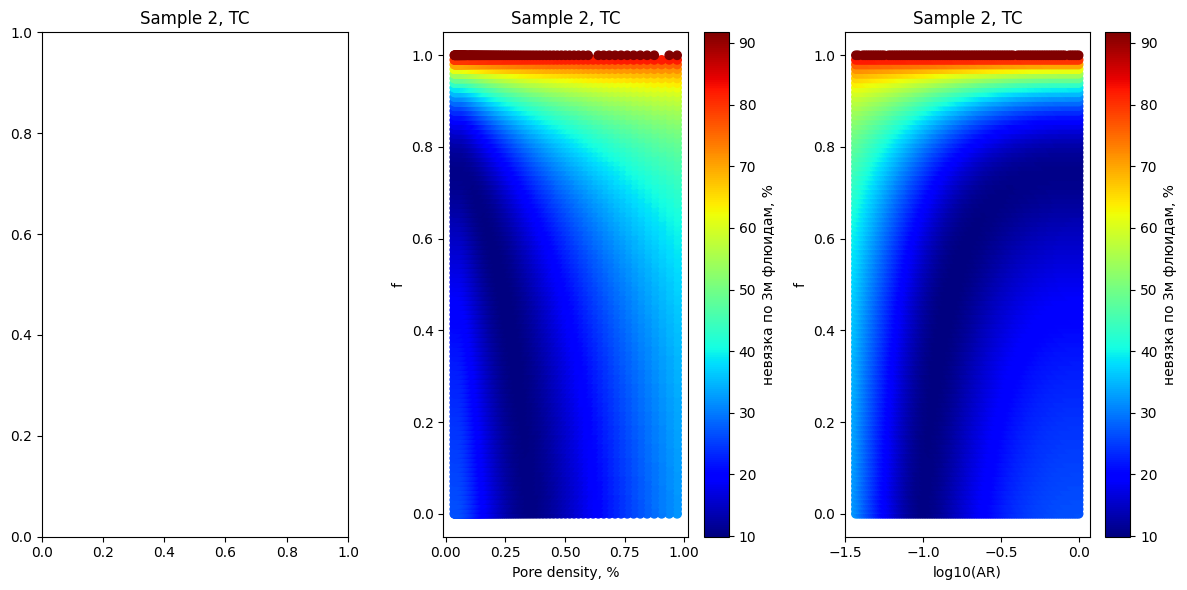

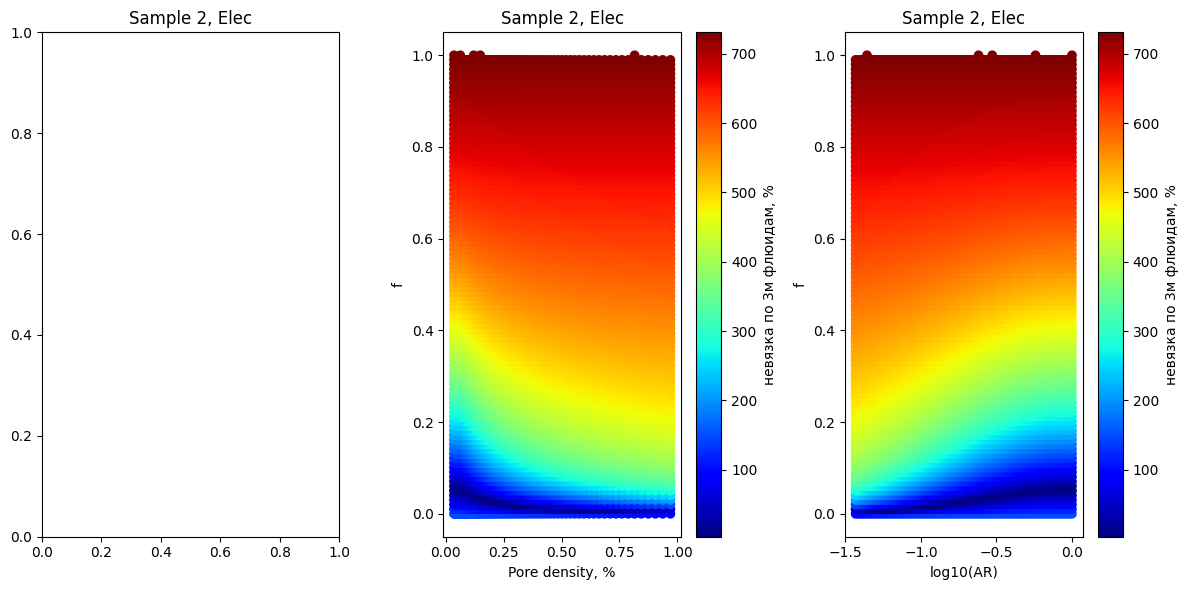

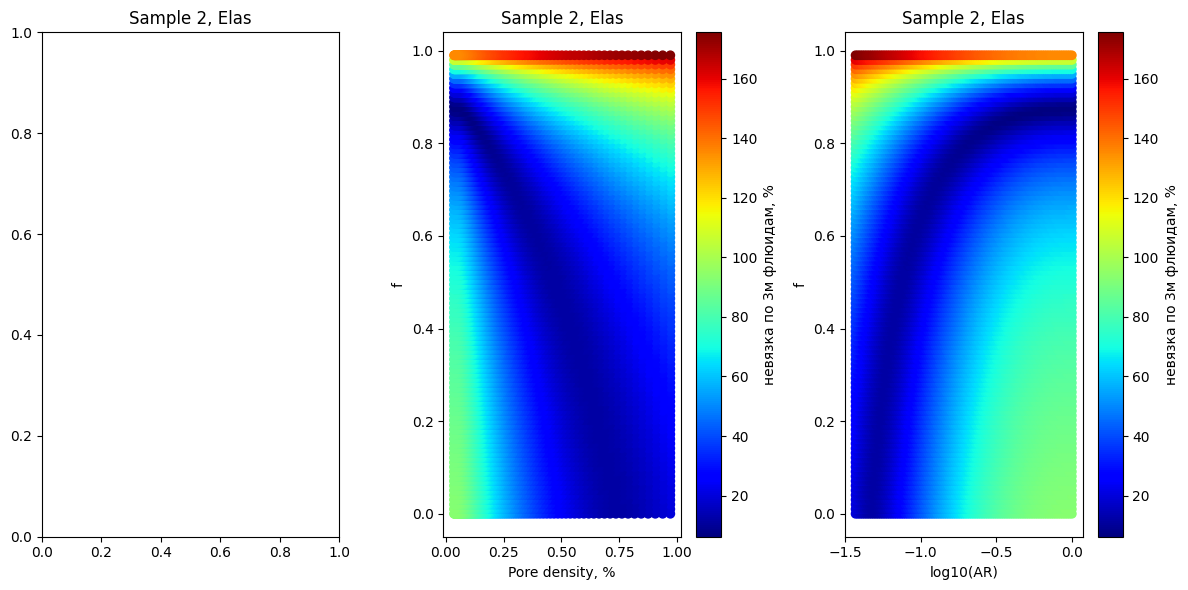

In [133]:
for idx in idx_list:
  make_plot(idx, prop="TC")
  make_plot(idx, prop="Elec")
  make_plot(idx, prop="Elas")

### Plot visualization

In [137]:
def make_plot(idx, prop):
    try:
        path_to_ser = Path(f'/content/Sample_one_porosity_{prop}_{idx}.csv')
        globals()[f"Sample_{idx}"] = pd.read_csv(path_to_ser, skiprows=0)
    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")
        return  # Exit the function if file is not found


    data = globals()[f"Sample_{idx}"]

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    for ax in axs:
      ax.set_title(f'Sample {idx}, {prop}')

    # First scatter plot
    scatter1 = axs[0].scatter(np.log10(data["AR inclusion"]), data["crack porosity"]*100,
                              c=data[f"total diff {prop}"], cmap='jet', marker='o')
    axs[0].set_xlabel('log10(AR cracks)')
    axs[0].set_ylabel('Crack porosity, %')
    # axs[0].set_xlim(-4, -2)
    # axs[0].set_ylim(0, 3)
    colorbar1 = plt.colorbar(scatter1, ax=axs[0])
    colorbar1.set_label('невязка по 3м флюидам, %')


    # Second scatter plot

    filtered_data = data[data[f"total diff {prop}"] < 20]
    sorted_data = filtered_data.sort_values(by=f"total diff {prop}")

    # scatter2 = axs[1].scatter(sorted_data["crack porosity"]*100, sorted_data['f'],
    #                           c=sorted_data[f"total diff {prop}"], cmap='jet', marker='o')

    axs[1].scatter(sorted_data["crack porosity"]*100, sorted_data['f'], cmap='jet', marker='o')


    # scatter2 = axs[1].scatter(data["crack porosity"]*100, data['f'],
    #                           c=data[f"total diff {prop}"], cmap='jet', marker='o')

    axs[1].set_ylabel('f')
    axs[1].set_xlabel('Crack porosity, %')
    # axs[1].set_ylim(0, 0.1)
    # axs[1].set_xlim(0, 3)
    # colorbar2 = plt.colorbar(scatter2, ax=axs[1])
    # colorbar2.set_label('невязка по 3м флюидам, %')



    # Third scatter plot
    scatter3 = axs[2].scatter(np.log10(data["AR inclusion"]), data['f'],
                              c=data[f"total diff {prop}"], cmap='jet', marker='o')
    axs[2].set_ylabel('f')
    axs[2].set_xlabel('log10(AR cracks)')
    # axs[2].set_ylim(0, 0.1)
    # axs[2].set_xlim(-4, -2)
    colorbar3 = plt.colorbar(scatter3, ax=axs[2])
    colorbar3.set_label('невязка по 3м флюидам, %')

    plt.tight_layout()
    plt.show()


### Electrical plot visualization

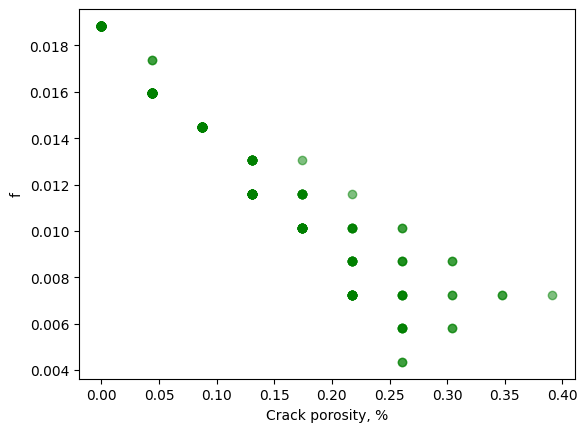

In [138]:
fig, ax = plt.subplots()

prop = 'Elec'  # Property 'Elec'

for idx in range(0, 2):
    try:
        path_to_ser = Path(f'/content/drive/MyDrive/Sample_double_porosity_{prop}_{idx}.csv')
        data = pd.read_csv(path_to_ser, skiprows=0)
        porosity = data["Porosity,%_air"].iloc[0] * 100


        filtered_data = data[data[f"total diff {prop}"] < 5]
        sorted_data = filtered_data.sort_values(by=f"total diff {prop}")
        porosity_array =  sorted_data["Porosity,%_air"] * 100

        # # Plot the scatter for each index
        # ax.scatter(sorted_data["crack porosity"] * 100, sorted_data['f'], label= f'{np.round(porosity, 2)}', marker='o',
        #            alpha=0.5)

        if porosity <=7:
          ax.scatter(sorted_data["crack porosity"] * 100  , sorted_data['f'], label= f'{np.round(porosity, 2)}', marker='o',
                   alpha=0.5, color='green')
        elif porosity >7 and porosity <=14:
          ax.scatter(sorted_data["crack porosity"] * 100, sorted_data['f'], label= f'{np.round(porosity, 2)}', marker='o',
                   alpha=0.5, color='red')
        elif porosity >14 and porosity <=25:
          ax.scatter(sorted_data["crack porosity"] * 100, sorted_data['f'], label= f'{np.round(porosity, 2)}', marker='o',
                   alpha=0.5, color='blue')
        # elif porosity >20 and porosity <=25:
        #   ax.scatter(sorted_data["crack porosity"] * 100, sorted_data['f'], label= f'{np.round(porosity, 2)}', marker='o',
        #            alpha=0.5, color='pink')
        # else:
        #   ax.scatter(sorted_data["crack porosity"] * 100, sorted_data['f'], label= f'{np.round(porosity, 2)}', marker='o',
        #            alpha=0.5, color='black')

    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")

# Set labels and limits
ax.set_ylabel('f')
ax.set_xlabel('Crack porosity, %')
# ax.set_ylim(0, 0.1)
# ax.set_xlim(0, 3)

# Show a legend for each sample
# ax.legend()

# Show the combined plot
plt.show()

In [ ]:
path_to_ser = Path('/content/f model.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='Лист1 (2)', skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['Porosity,%',"crack porosity", "f_synt"], inplace=True)

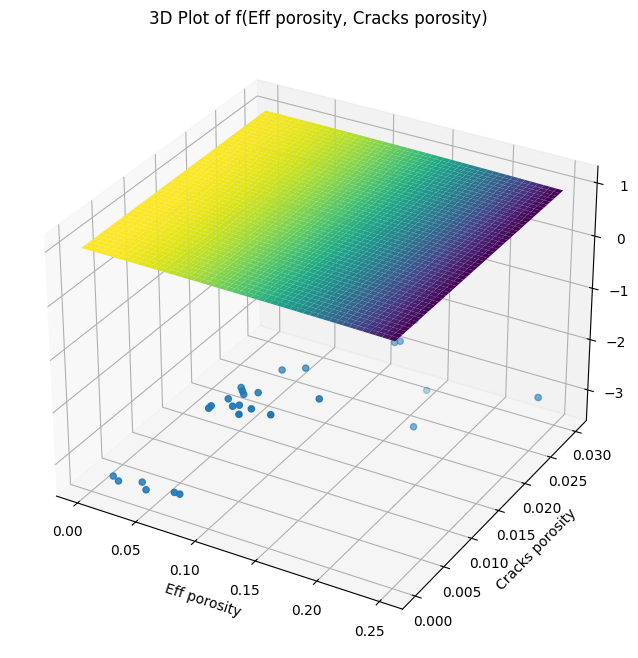

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f_func(x, y):
    return 1 / (x**2 + y**2 + 1)

# Create the grid of a and ac values
phi = np.linspace(0, 0.25, 50)
phi_cracks = np.linspace(0, 0.03, 50)
PHI, PHI_CRACKS = np.meshgrid(phi, phi_cracks)

# Calculate the values of f
F = (f_func(PHI, PHI_CRACKS))

# Plot the 3D graph
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(PHI, PHI_CRACKS, F, cmap='viridis')

# Reverse the x-axis label
# ax.set_xlim(0, 0.25)
ax.scatter(data["Porosity,%"]/100, (data['crack porosity']), np.log10(data['f_synt']))
ax.set_xlabel('Eff porosity')
ax.set_ylabel('Cracks porosity')
ax.set_zlabel('f')
# ax.set_zlim(-4, -2)
ax.set_title('3D Plot of f(Eff porosity, Cracks porosity)')
plt.show()

FileNotFoundError: Sample_8.csv not found. Skipping to the next index.


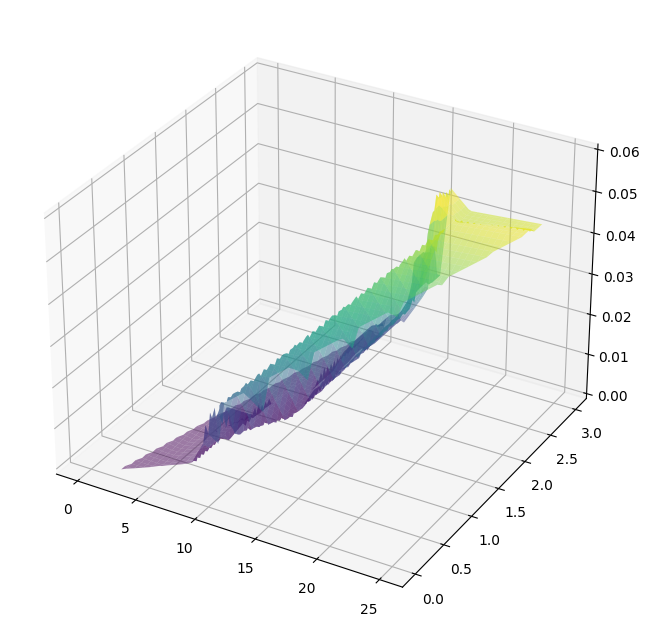

In [ ]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, projection='3d')

all_x, all_y, all_z = [], [], []

for idx in range(0, 32):
    try:
        path_to_ser = Path(f'/content/drive/MyDrive/Sample_double_porosity_{prop}_{idx}.csv')
        data = pd.read_csv(path_to_ser, skiprows=0)


        length = 50
        filtered_data = data[data[f"total diff {prop}"] < 10][:length]
        # filtered_data = data[data[f"total diff {prop}"] < 10]
        sorted_data = filtered_data.sort_values(by=f"total diff {prop}")
        porosity = sorted_data["Porosity,%_air"]* 100
        crack_porosity = sorted_data["crack porosity"]* 100
        f = sorted_data["f"]

        # print(sorted_data[["f", "Porosity,%_air", "crack porosity"]])

        x, y, z = porosity, crack_porosity, f

        all_x.extend(x)
        all_y.extend(y)
        all_z.extend(z)

    except FileNotFoundError:
        print(f"FileNotFoundError: Sample_{idx}.csv not found. Skipping to the next index.")

# Perform interpolation on all accumulated data points
zi = griddata((all_x, all_y), all_z, (xi, yi), method='linear')

# ax.scatter(all_x, all_y, all_z, color='r', label='Data Points', alpha=0.2)
ax.plot_surface(xi, yi, zi, alpha=0.5, cmap='viridis', label='Interpolated Surface')
# ax.view_init(elev=0, azim=0) # 2D
ax.set_zlim(0, 0.06)
# ax.view_init(elev=30, azim=20)

# ax.legend()
plt.show()


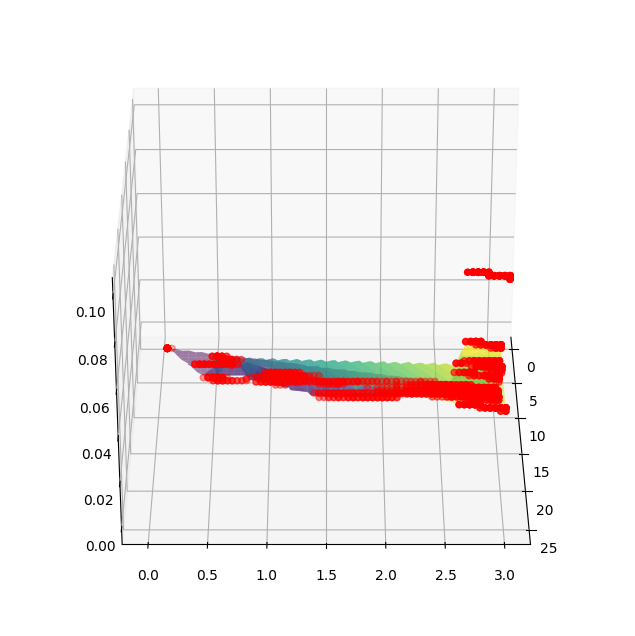

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

# Rest of your existing code...

# Create the figure and 3D axes
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, projection='3d')

# Perform interpolation on all accumulated data points
zi = griddata((all_x, all_y), all_z, (xi, yi), method='linear')

# Plot the initial surface
surf = ax.plot_surface(xi, yi, zi, alpha=0.5, cmap='viridis', label='Interpolated Surface')
ax.scatter(all_x, all_y, all_z, color='r', label='Data Points')

# Set the viewing angle
ax.view_init(elev=30, azim=-45)

# Function to update the plot for each frame
def update(angle):
    ax.view_init(elev=30, azim=angle)
    return surf,

# Create the animation
ani = FuncAnimation(fig, update, frames=np.linspace(0, 360, 360), interval=50, blit=True)
ani.save('animation.mp4', writer='ffmpeg')

# Show the plot
plt.show()
plt.ion()

In [140]:
idx=0

### Merge

In [142]:
from sklearn.preprocessing import MinMaxScaler

def normalized(data, prop):
  if prop == "Elas":
    # data = data.rename(columns={f"total diff {prop}": f"Diff {prop}"})
    data[f"Diff {prop}"] = data[f"total diff {prop}"]
  else:
    matrix_nX3 = np.column_stack((data[f"Diff {prop} air"],
                                   data[f"Diff {prop} water"],
                                   data[f"Diff {prop} oil"]))
    data[f"Diff {prop}"] = np.sqrt(np.sum(matrix_nX3 ** 2, axis=1))

    # Normalization - Linear scaling
  data[f"Diff {prop} normalized"] = MinMaxScaler().fit_transform(np.array(data[f"Diff {prop}"]).reshape(-1, 1))
  print(data[:5])

  return data

def all_data_normalizing(idx, prop):

    # thermal
    phys_prop = prop[0]
    path_to_ser = Path(f'/content/Sample_one_porosity_{phys_prop}_{idx}.csv')
    globals()[f"Sample_{idx}_thermal"] = pd.read_csv(path_to_ser, skiprows=0)
    normalized_sample_data = normalized(globals()[f"Sample_{idx}_thermal"] , phys_prop)

    # electrical
    phys_prop = prop[1]
    path_to_ser = Path(f'/content/Sample_one_porosity_{phys_prop}_{idx}.csv')
    globals()[f"Sample_{idx}_electrical"] = pd.read_csv(path_to_ser, skiprows=0)
    normalized_sample_data = normalized(globals()[f"Sample_{idx}_electrical"], phys_prop)

    # elastic
    phys_prop = prop[2]
    path_to_ser = Path(f'/content/Sample_one_porosity_{phys_prop}_{idx}.csv')
    globals()[f"Sample_{idx}_elastic"] = pd.read_csv(path_to_ser, skiprows=0)
    normalized_sample_data = normalized(globals()[f"Sample_{idx}_elastic"], phys_prop)


    merged_data_total = pd.DataFrame()

    merged_data_total = pd.merge(globals()[f"Sample_{idx}_thermal"],
                                 globals()[f"Sample_{idx}_electrical"],
                                 on=["AR inclusion", "f"], how='inner')

    merged_data_total['Diff TC+Elec'] = np.sqrt(merged_data_total[f'Diff {prop[0]} normalized']**2 + \
                                                  merged_data_total[f'Diff {prop[1]} normalized']**2)

    merged_data_total = pd.merge(merged_data_total,
                                 globals()[f"Sample_{idx}_elastic"],
                                 on=["AR inclusion", "f"], how='inner')

    merged_data_total['Diff TC+Elec+Elas'] = np.sqrt(merged_data_total[f'Diff {prop[0]} normalized']**2 + \
                                                     merged_data_total[f'Diff {prop[1]} normalized']**2 + \
                                                     merged_data_total[f'Diff {prop[2]} normalized']**2)

    return merged_data_total

# idx = 0
# merged_data_total = all_data_normalizing(idx, prop=["TC", "Elec", "Elas"])

# ### Merge Thermal, Elastic properties, Electrical properteis
# merged_data_total = pd.merge(diff_columns_tc,
#                                diff_columns_elastic,
#                                on=["AR inclusion", "f"], how='inner')

# merged_data_total = pd.merge(merged_data_total,
#                                diff_columns_electric,
#                                on=["AR inclusion", "f"], how='inner')

# merged_data_total['Diff tc+velocities'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
#                                                   merged_data_total['Diff velocities fluid']**2)

# merged_data_total['Diff tc+velocities+electrical'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
#                                                   merged_data_total['Diff velocities fluid']**2 + \
#                                                              merged_data_total['Diff Electric fluid']**2)

merged_data_total[:5]

   Unnamed: 0  Porosity,%_air  AR inclusion    f  TC_mtrx_air    TC_air  TC_HSup_air  TC_HSlo_air  \
0           0        0.045249      0.010970  0.0         2.95  1.791642     2.756627     1.035104   
1           1        0.045249      0.011357  0.0         2.95  1.806832     2.756627     1.035104   
2           2        0.045249      0.011758  0.0         2.95  1.822094     2.756627     1.035104   
3           3        0.045249      0.012174  0.0         2.95  1.837420     2.756627     1.035104   
4           4        0.045249      0.012604  0.0         2.95  1.852799     2.756627     1.035104   

      e_air  TC_exp_air  Diff TC air  Porosity,%_water  TC_mtrx_water  TC_water  TC_HSup_water  \
0  0.984735    2.472888        27.55          0.045249           2.95  2.727397       2.807551   
1  0.951139    2.472888        26.93          0.045249           2.95  2.727686       2.807551   
2  0.918689    2.472888        26.32          0.045249           2.95  2.727984       2.807551   
3

Unnamed: 0_x  Porosity,%_air_x  AR inclusion    f  TC_mtrx_air    TC_air  TC_HSup_air  \
0             0          0.045249      0.010970  0.0         2.95  1.791642     2.756627   
1             1          0.045249      0.011357  0.0         2.95  1.806832     2.756627   
2             2          0.045249      0.011758  0.0         2.95  1.822094     2.756627   
3             3          0.045249      0.012174  0.0         2.95  1.837420     2.756627   
4             4          0.045249      0.012604  0.0         2.95  1.852799     2.756627   

   TC_HSlo_air   e_air_x  TC_exp_air  Diff TC air  Porosity,%_water_x  TC_mtrx_water  TC_water  \
0     1.035104  0.984735    2.472888        27.55            0.045249           2.95  2.727397   
1     1.035104  0.951139    2.472888        26.93            0.045249           2.95  2.727686   
2     1.035104  0.918689    2.472888        26.32            0.045249           2.95  2.727984   
3     1.035104  0.887347    2.472888        25.70            0.045249           2.95  2.728291   
4     1.035104  0.857073    2.472888        25.08            0.045249           2.95  2.728608   

   TC_HSup_water  TC_HSlo_water  e_water_x  TC_exp_water  Diff TC water  Porosity,%_x  \
0       2.807551       2.718513   0.984735      2.740225           0.47      0.045249   
1       2.807551       2.718513   0.951139      2.740225           0.46      0.045249   
2       2.807551       2.718513   0.918689      2.740225           0.45      0.045249   
3       2.807551       2.718513   0.887347      2.740225           0.44      0.045249   
4       2.807551       2.718513   0.857073      2.740225           0.42      0.045249   

   TC_mtrx_oil    TC_oil  TC_HSup_oil  TC_HSlo_oil   e_oil_x  TC_exp_oil  Diff TC oil  \
0         2.95  2.281782     2.765668     2.113015  0.984735    2.668885        14.50   
1         2.95  2.286292     2.765668     2.113015  0.951139    2.668885        14.34   
2         2.95  2.290883     2.765668     2.113015  0.918689    2.668885        14.16   
3         2.95  2.295554     2.765668     2.113015  0.887347    2.668885        13.99   
4         2.95  2.300305     2.765668     2.113015  0.857073    2.668885        13.81   

   total diff TC    Diff TC  Diff TC normalized  Unnamed: 0_y  Porosity,%_air_y  Elec_mtrx_air  \
0      31.136368  31.136368            0.477523             0          0.045249        0.00182   
1      30.513474  30.513474            0.466897             1          0.045249        0.00182   
2      29.890642  29.890642            0.456272             2          0.045249        0.00182   
3      29.264376  29.264376            0.445588             3          0.045249        0.00182   
4      28.633877  28.633877            0.434833             4          0.045249        0.00182   

   Elec_air  Elec_HSup_air  Elec_HSlo_air   e_air_y  Elec_exp_air  Diff Elec air  \
0  0.007447       0.034257       0.002077  0.984735      0.003773          97.41   
1  0.007291       0.034257       0.002077  0.951139      0.003773          93.26   
2  0.007138       0.034257       0.002077  0.918689      0.003773          89.20   
3  0.006988       0.034257       0.002077  0.887347      0.003773          85.24   
4  0.006842       0.034257       0.002077  0.857073      0.003773          81.37   

   Porosity,%_water_y  Elec_mtrx_water  Elec_water  Elec_HSup_water  Elec_HSlo_water  e_water_y  \
0            0.045249           0.0143    0.058599         0.271961         0.016322   0.984735   
1            0.045249           0.0143    0.057363         0.271961         0.016322   0.951139   
2            0.045249           0.0143    0.056155         0.271961         0.016322   0.918689   
3            0.045249           0.0143    0.054976         0.271961         0.016322   0.887347   
4            0.045249           0.0143    0.053825         0.271961         0.016322   0.857073   

   Elec_exp_water  Diff Elec water  Porosity,%_y  Elec_mtrx_oil  Elec_oil  Elec_HSup_oil  \
0        0

In [162]:
idx_list = [1]

In [164]:
def main():
    for idx in idx_list:
        try:
            merged_data_total = all_data_normalizing(idx, prop=["TC", "Elec", "Elas"])
            filtered_data = merged_data_total[merged_data_total['f'] > 0]
            sorted_merged_all = filtered_data.sort_values(by='Diff TC+Elec+Elas', ascending=True)

            globals()[f"sample_{idx}_merge"] = pd.DataFrame()
            globals()[f"sample_{idx}_merge"] = sorted_merged_all
            globals()[f"sample_{idx}_merge"].to_csv(f'/content/Sample_one_porosity_merged_{idx}.csv', index=True)
            globals()[f"sample_{idx}_merge"].to_csv(f'/content/drive/My Drive/Sample_one_porosity_merged_{idx}.csv', index=False)

        except KeyError as e:
            print(f"KeyError: {e}. Skipping to the next index.")
        except FileNotFoundError as e:
            print(f"FileNotFoundError: {e}. Check if the directory exists and you have write permissions.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Sample_one_porosity_TC_1.csv'. Check if the directory exists and you have write permissions.


In [159]:
# filtered_data = merged_data_total[merged_data_total['f'] > 0]
# sorted_merged_all = filtered_data.sort_values(by='Diff TC+Elec+Elas', ascending=True)
# sorted_merged_all.iloc[0]

Text(0, 0.5, 'f')

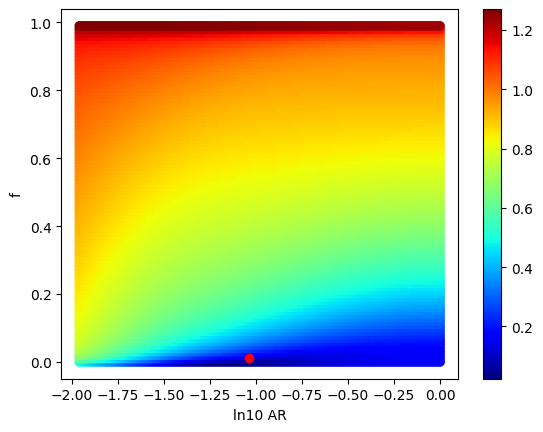

In [158]:
scatter = plt.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                      c=merged_data_total['Diff TC+Elec'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.scatter(np.log10(sorted_merged_all["AR inclusion"]).iloc[0], sorted_merged_all["f"].iloc[0], c='red')
plt.xlabel('ln10 AR')
plt.ylabel('f')
# plt.xlim(-4, -2)

# plt.ylim(0, 0.1)

Text(0, 0.5, 'f')

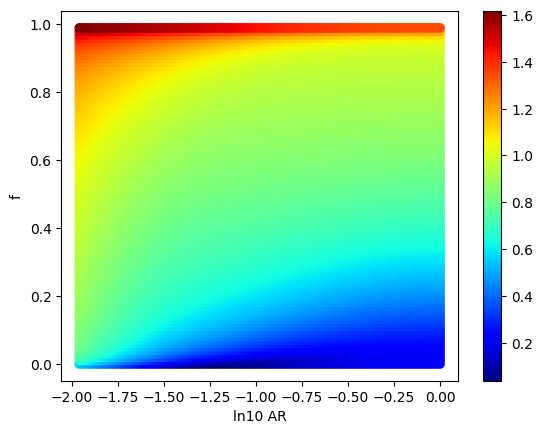

In [146]:
scatter = plt.scatter(np.log10(merged_data_total["AR inclusion"]), merged_data_total["f"],
                      c=merged_data_total['Diff TC+Elec+Elas'], cmap='jet', marker='o')

plt.colorbar(scatter)  # Add color bar to the plot
plt.xlabel('ln10 AR')
plt.ylabel('f')
# plt.xlim(-4, -2)

# plt.ylim(0, 0.1)

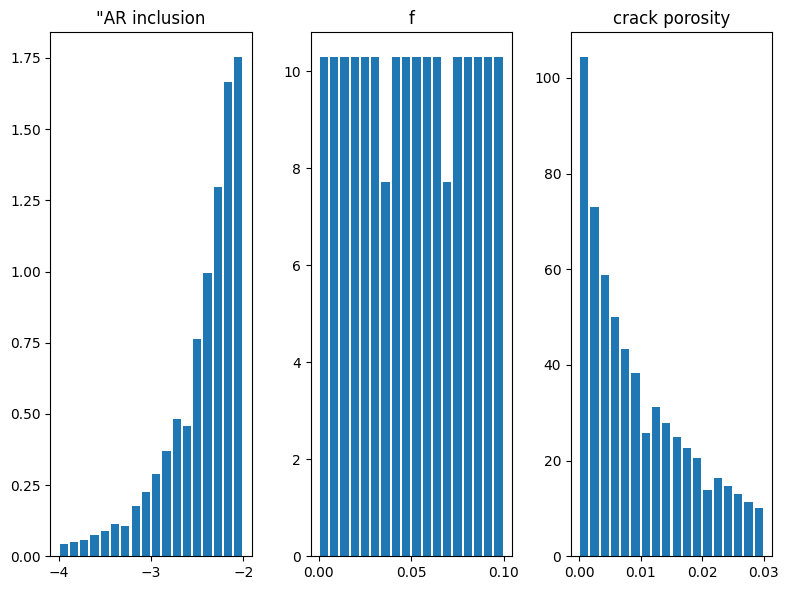

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8, 6))

# for ax in axs:
#   ax.set_title(f'Sample {idx}, {prop}')

# First scatter plot
axs[0].hist(np.log10(merged_data_total["AR inclusion"]), bins="sturges", density=True,
            histtype='barstacked', rwidth=0.8)
axs[0].set_title('"AR inclusion')
# axs[0].set_xlabel('log10(AR cracks)')
# axs[0].set_ylabel('Crack porosity, %')
# axs[0].set_xlim(-4, -2)
# axs[0].set_ylim(0, 3)

# Second scatter plot
axs[1].hist((merged_data_total["f"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)
axs[1].set_title('f')
# axs[1].set_ylabel('f')
# axs[1].set_xlabel('Crack porosity, %')
# axs[1].set_ylim(0, 1)
# axs[1].set_xlim(0, 3)

axs[2].hist((merged_data_total["crack porosity"]), bins="sturges", density=True,
         histtype='barstacked', rwidth=0.8)
axs[2].set_title('crack porosity')

plt.tight_layout()
plt.show()

In [ ]:
# Statiscics
sorted = merged_data_total.sort_values(by='Diff TC+Elec+Elas', ascending=True)
sorted[["AR inclusion",	"f",	"crack porosity"]].describe()

AR inclusion             f  crack porosity
count  99222.000000  99222.000000    99222.000000
mean       0.004929      0.492754        0.009417
std        0.002898      0.288646        0.008033
min        0.000100      0.000000        0.000000
25%        0.002462      0.246377        0.002609
50%        0.004799      0.492754        0.007391
75%        0.007163      0.739130        0.014783
max        0.010000      0.985507        0.030000

In [ ]:
sorted.columns

Index(['Unnamed: 0_x', 'Porosity,%_air_x', 'AR inclusion', 'f',
       'crack porosity', 'TC_mtrx_air', 'TC_air', 'TC_HSup_air', 'TC_HSlo_air',
       'e_air_x',
       ...
       'Vp_HSup_oil', 'Vs_HSup_oil', 'Vp_HSlo_oil', 'Vs_HSlo_oil', 'e_oil',
       'Diff Vp oil', 'Diff Vs oil', 'Diff Elas oil', 'total diff',
       'Diff TC+Elec+Elas'],
      dtype='object', length=125)

In [ ]:
column_list_full = ["Porosity,%_air_x", "AR inclusion", "f", "crack porosity", "Diff TC air", "Diff TC water", "Diff TC oil", "Diff Elec air", "Diff Elec water", "Diff Elec oil", "Diff TC", "Diff Elec", \
               "Diff Vp air", "Diff Vs air","Diff Vp water", "Diff Vs water", "Diff Vp oil", "Diff Vs oil", "Diff TC+Elec+Elas"]

In [ ]:
sorted[column_list][:20]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
sorted[:5]

Unnamed: 0_x  Porosity,%_air_x  AR inclusion    f  crack porosity  \
356           356          0.045249      0.005690  0.0        0.006735   
335           335          0.045249      0.005179  0.0        0.006122   
377           377          0.045249      0.006866  0.0        0.007347   
357           357          0.045249      0.006251  0.0        0.006735   
396           396          0.045249      0.007543  0.0        0.007959   

     TC_mtrx_air    TC_air  TC_HSup_air  TC_HSlo_air   e_air_x  ...  \
356         2.95  2.460257     2.756627     1.035104  0.282571  ...   
335         2.95  2.472410     2.756627     1.035104  0.282196  ...   
377         2.95  2.464703     2.756627     1.035104  0.255437  ...   
357         2.95  2.473416     2.756627     1.035104  0.257224  ...   
396         2.95  2.458239     2.756627     1.035104  0.251900  ...   

     Vp_HSlo_oil  Vs_HSlo_oil     e_oil  Diff Vp oil  Diff Vs oil  \
356     2.503361     0.000005  0.282571        -4.65        -3.43   
335     2.503361     0.000005  0.282196        -4.22        -3.34   
377     2.503361     0.000005  0.255437        -4.47        -2.57   
357     2.503361     0.000005  0.257224        -4.14        -2.56   
396     2.503361     0.000005  0.251900        -4.74        -2.51   

     Diff Elas oil  total diff Elas  Diff Elas  Diff Elas normalized  \
356           5.78        20.769027  20.769027              0.014137   
335           5.38        20.731920  20.731920              0.013884   
377           5.16        20.687644  20.687644              0.013583   
357           4.87        20.666637  20.666637              0.013440   
396           5.36        20.720777  20.720777              0.013809   

     Diff TC+Elec+Elas  
356           0.019225  
335           0.019348  
377           0.019465  
357           0.019624  
396           0.020026  

[5 rows x 125 columns]

In [ ]:
# columns_with_ = [col for col in sorted_df.columns if 'Vp' in col or 'Vs' in col]
columns_with_ = [col for col in sorted_df.columns if 'Elec' in col]
columns_with_

['Elec_mtrx_air',
 'Elec_air',
 'Elec_HSup_air',
 'Elec_HSlo_air',
 'Elec_exp_air',
 'Diff Elec air',
 'Elec_mtrx_water',
 'Elec_water',
 'Elec_HSup_water',
 'Elec_HSlo_water',
 'Elec_exp_water',
 'Diff Elec water',
 'Elec_mtrx_oil',
 'Elec_oil',
 'Elec_HSup_oil',
 'Elec_HSlo_oil',
 'Elec_exp_oil',
 'Diff Elec oil',
 'total diff Elec',
 'Diff Elec',
 'Diff Elec normalized',
 'Diff TC+Elec',
 'Diff TC+Elec+Elas']

In [ ]:
# Assuming your DataFrame is named df and the column names are in a list named column_names
sorted_df = pd.DataFrame()

column_list = ["crack porosity", "f", "Diff TC air", "Diff TC water", "Diff TC oil", "Diff Elec air", "Diff Elec water", "Diff Elec oil", \
               "Diff Vp air", "Diff Vs air","Diff Vp water", "Diff Vs water", "Diff Vp oil", "Diff Vs oil"]

column_list_to_save = ["Porosity,%_air_x", "AR inclusion", "f", "crack porosity", "Diff TC air", "Diff TC water", "Diff TC oil", "Diff Elec air", "Diff Elec water", "Diff Elec oil", "Diff TC", "Diff Elec", \
               "Diff Vp air", "Diff Vs air","Diff Vp water", "Diff Vs water", "Diff Vp oil", "Diff Vs oil", "Diff TC+Elec+Elas", \
                       "TC_air", "TC_water", "TC_oil", "Elec_air", "Elec_water", "Elec_oil", "Vp air", "Vs air", "Vp water", "Vs water", "Vp oil", "Vs oil"]

rows = []
error = 10

for index, row in merged_data_total.iterrows():
    condition = all(abs(row[col]) < error for col in column_list[2:]) and \
     row['f'] != 0 and\
     row['crack porosity'] != 0

    if condition:
        rows.append(row)

sorted_df = pd.DataFrame(rows)
print(sorted_df.shape)

if sorted_df.shape[0] == 0:
  pass
else:
  from google.colab import drive
  drive.mount('/content/drive')

  sorted_df = sorted_df.sort_values(by='Diff TC+Elec+Elas', ascending=True)

  globals()[f"sample_sorted_{error}_{idx}"] = pd.DataFrame()
  globals()[f"sample_sorted_{error}_{idx}"] = sorted_df[column_list_to_save]
  globals()[f"sample_sorted_{error}_{idx}"].to_csv(f'/content/Sample_sorted_{error}_{idx}.csv', index=True)
  globals()[f"sample_sorted_{error}_{idx}"].to_csv(f'/content/drive/My Drive/Sample_sorted_{error}_{idx}.csv', index=False)

(1416, 125)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sorted_df[column_list_full][0:20]

Porosity,%_air_x  AR inclusion         f  crack porosity  Diff TC air  Diff TC water  \
16597          0.083261      0.005130  0.015942        0.008261         0.14           2.02   
18035          0.083261      0.005130  0.017391        0.008261         0.14           2.02   
16622          0.083261      0.005484  0.015942        0.008696         0.09           2.04   
15184          0.083261      0.005484  0.014493        0.008696         0.09           2.04   
18009          0.083261      0.004799  0.017391        0.007826         0.42           1.99   
15159          0.083261      0.005130  0.014493        0.008261         0.14           2.01   
16571          0.083261      0.004799  0.015942        0.007826         0.42           1.99   
18060          0.083261      0.005484  0.017391        0.008696         0.09           2.04   
19447          0.083261      0.004799  0.018841        0.007826         0.42           1.99   
15208          0.083261      0.005863  0.014493        0.009130         0.28           2.07   
16646          0.083261      0.005863  0.015942        0.009130         0.28           2.07   
19473          0.083261      0.005130  0.018841        0.008261         0.14           2.02   
17982          0.083261      0.004489  0.017391        0.007391         0.75           1.96   
15133          0.083261      0.004799  0.014493        0.007826         0.42           1.99   
16596          0.083261      0.004799  0.015942        0.008261         0.29           2.02   
19420          0.083261      0.004489  0.018841        0.007391         0.75           1.97   
13746          0.083261      0.005484  0.013043        0.008696         0.09           2.04   
16598          0.083261      0.005484  0.015942        0.008261         0.58           2.01   
18036          0.083261      0.005484  0.017391        0.008261         0.58           2.02   
13770          0.083261      0.005863  0.013043        0.009130         0.28           2.06   

       Diff TC oil  Diff Elec air  Diff Elec water  Diff Elec oil   Diff TC  Diff Elec  \
16597         1.10           2.29             2.27           2.57  2.304344   4.123336   
18035         1.10           0.81             0.84           5.57  2.304344   5.690923   
16622         1.27           0.84             0.82           4.02  2.404704   4.187887   
15184         1.27           4.07             4.06           0.90  2.404704   5.818806   
18009         0.92           0.75             0.72           4.02  2.232241   4.152264   
15159         1.10           5.47             5.47           0.50  2.295583   7.751890   
16571         0.92           3.81             3.80           1.05  2.232241   5.482572   
18060         1.27           2.29             2.33           7.05  2.404704   7.770167   
19447         0.92           2.26             2.30           6.93  2.232241   7.643461   
15208         1.43           2.75             2.73           2.24  2.531442   4.475824   
16646         1.43           0.53             0.55           5.39  2.531442   5.443850   
19473         1.10           3.84             3.88           8.51  2.304344  10.110396   
17982         0.73           2.37             2.35           2.40  2.221936   4.110888   
15133         0.92           6.95             6.95           1.99  2.232241  10.028215   
16596         1.15           1.81             1.79           3.04  2.342435   3.965073   
19420         0.73           0.61             0.64           5.29  2.230762   5.363376   
13746         1.27           7.39             7.40           2.30  2.404704  10.708039   
16598         1.05           2.80             2.78           2.07  2.340726   4.455704   
18036         1.05           0.33             0.36           5.10  2.349319   5.123329   
13770         1.43           6.13             6.13           1.02  2.523272   8.728929   

       Diff Vp air  Diff Vs air  Diff Vp water  Diff Vs water  Diff Vp oil  Diff Vs oil  \
16597        -5.52         0.

In [ ]:
sorted_df[column_list_full].describe()

Porosity,%_air_x  AR inclusion            f  crack porosity  Diff TC air  Diff TC water  \
count      1.416000e+03   1416.000000  1416.000000     1416.000000  1416.000000    1416.000000   
mean       8.326070e-02      0.005235     0.018893        0.007630     3.717782       1.972931   
std        1.388269e-17      0.002599     0.006987        0.004008     2.620325       0.237743   
min        8.326070e-02      0.000905     0.004348        0.001739     0.000000       1.610000   
25%        8.326070e-02      0.003008     0.013043        0.004348     1.577500       1.780000   
50%        8.326070e-02      0.005130     0.018841        0.007174     3.220000       1.945000   
75%        8.326070e-02      0.007163     0.024638        0.010435     5.460000       2.130000   
max        8.326070e-02      0.010000     0.034783        0.020000     9.990000       2.700000   

       Diff TC oil  Diff Elec air  Diff Elec water  Diff Elec oil      Diff TC    Diff Elec  \
count  1416.000000    1416.000000      1416.000000    1416.000000  1416.000000  1416.000000   
mean      1.491815       4.112973         4.123531       4.267811     4.818191     8.055565   
std       1.077119       2.697219         2.698477       2.820156     2.192124     3.121404   
min       0.000000       0.010000         0.030000       0.000000     2.074560     3.580559   
25%       0.650000       1.890000         1.902500       1.887500     3.046358     5.238693   
50%       1.295000       3.765000         3.780000       3.815000     4.122063     7.676384   
75%       2.020000       5.972500         5.947500       6.522500     6.176864    10.697809   
max       5.510000       9.980000         9.980000       9.990000    10.369769    15.097871   

       Diff Vp air  Diff Vs air  Diff Vp water  Diff Vs water  Diff Vp oil  Diff Vs oil  \
count  1416.000000  1416.000000    1416.000000    1416.000000  1416.000000  1416.000000   
mean     -3.499597     2.108658       5.386243       5.927182     2.416462     3.048220   
std       3.872236     3.010938       2.305982       2.283400     3.313477     2.363615   
min      -9.990000    -3.080000      -1.330000       1.350000    -6.380000    -2.110000   
25%      -6.930000    -0.540000       3.850000       3.937500     0.147500     1.057500   
50%      -3.540000     2.135000       5.670000       5.925000     2.670000     3.095000   
75%      -0.250000     4.650000       7.150000       7.845000     4.980000     5.042500   
max       4.020000     7.780000       9.660000       9.990000     8.930000     7.370000   

       Diff TC+Elec+Elas  
count        1416.000000  
mean            0.176956  
std             0.104708  
min             0.035592  
25%             0.088755  
50%             0.152667  
75%             0.246441  
max             0.461196

In [ ]:
path_to_ser = Path(f'/content/Sample_sorted_10_10.csv')
sorted_df = pd.read_csv(path_to_ser, skiprows=0)

In [ ]:
sorted_df[:10]

Porosity,%_air_x  AR inclusion         f  crack porosity  Diff TC air  Diff TC water  \
0          0.083261      0.005863  0.014493        0.009130         0.28           2.07   
1          0.083261      0.005484  0.014493        0.008696         0.09           2.04   
2          0.083261      0.006268  0.014493        0.009565         0.42           2.09   
3          0.083261      0.005863  0.014493        0.009565         0.92           2.09   
4          0.083261      0.005484  0.014493        0.009130         0.76           2.07   
5          0.083261      0.006268  0.014493        0.010000         1.03           2.12   
6          0.083261      0.005130  0.014493        0.008261         0.14           2.01   
7          0.083261      0.006700  0.014493        0.010000         0.52           2.12   
8          0.083261      0.005130  0.014493        0.008696         0.55           2.04   
9          0.083261      0.006700  0.014493        0.010435         1.11           2.14   

   Diff TC oil  Diff Elec air  Diff Elec water  Diff Elec oil   Diff TC  Diff Elec  Diff Vp air  \
0         1.43           2.75             2.73           2.24  2.531442   4.475824        -4.76   
1         1.27           4.07             4.06           0.90  2.404704   5.818806        -5.15   
2         1.59           1.50             1.49           3.48  2.659436   4.071916        -4.32   
3         1.65           0.83             0.82           4.14  2.817268   4.301267        -5.73   
4         1.49           2.13             2.12           2.84  2.661315   4.134840        -6.18   
5         1.80           0.37             0.39           5.36  2.965687   5.386891        -5.24   
6         1.10           5.47             5.47           0.50  2.295583   7.751890        -5.50   
7         1.73           0.35             0.33           4.65  2.785265   4.674816        -3.84   
8         1.32           3.50             3.49           1.46  2.491285   5.153804        -6.58   
9         1.95           1.50             1.52           6.49  3.100677   6.832313        -4.71   

   Diff Vs air  Diff Vp water  Diff Vs water  Diff Vp oil  Diff Vs oil  Diff TC+Elec+Elas  \
0         1.18           4.17           5.13         0.46         2.09           0.028234   
1         0.87           4.28           4.93         0.61         1.92           0.028343   
2         1.53           4.07           5.35         0.34         2.28           0.028560   
3         0.41           3.73           4.52        -0.14         1.46           0.028785   
4         0.05           3.83           4.29        -0.02         1.26           0.029010   
5         0.80           3.65           4.78        -0.24         1.69           0.029048   
6         0.60           4.42           4.77         0.79         1.79           0.029088   
7         1.91           4.00           5.59         0.25         2.50           0.029381   
8        -0.27           3.95           4.09         0.14         1.09           0.029625   
9         1.22           3.59           5.05        -0.30         1.94           0.029767   

     TC_air  TC_water    TC_oil  Elec_air  Elec_water  Elec_oil    Vp air    Vs air  Vp water  \
0  2.246025  2.674611  2.492586  0.008503    0.067330  0.161717  3.956606  2.460748  5.191332   
1  2.250222  2.675316  2.496720  0.008387    0.066411  0.159612  3.940248  2.453174  5.197026   
2  2.242846  2.673916  2.488678  0.008612    0.068190  0.163692  3.974878  2.469170  5.186537   
3  2.231611  2.673849  2.487041  0.008670    0.068655  0.164730  3.916303  2.441995  5.169492   
4  2.235243  2.674551  2.491084  0.008557    0.067758  0.162671  3.897743  2.433307  5.174360   
5  2.228981  2.673157  2.483225  0.008776    0.069495  0.166657  3.936609  2.451453  5.165482   
6  2.255475  2.676030  2.501071  0.008265    0.065437  0.157383  3.926036  2.446569  5.203674   
7  2.240648  2.673231  2.485002  0.008713    0.068991  0.165533  3.994857  2.478332  5.182594   
8  2.239912  2

In [ ]:
# idx_array = [0, 1, 2, 13, 16]

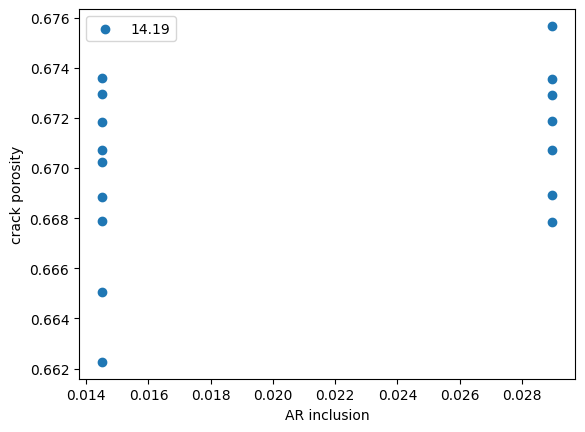

In [ ]:
# data = sorted_df

# plt.scatter(np.log10(data["AR inclusion"]),
#             data["Diff TC+Elec+Elas"])
# plt.xlabel('AR inclusion')
# plt.ylabel('Diff (normalized) TC+Elec+Elas')
# plt.xlim(-4, -2)

# plt.scatter(np.log10(data["AR inclusion"]),
#             data["f"])
# plt.xlabel('AR inclusion')
# plt.ylabel('f')
# plt.xlim(-4, -2)

# plt.scatter(np.log10(data["AR inclusion"]),
#             data["crack porosity"])
# plt.xlabel('AR inclusion')
# plt.ylabel('crack porosity')
# plt.xlim(-4, -2)

# plt.scatter(np.log10(data["AR inclusion"]),
#             data["Diff TC air"], color='red', alpha=0.2)
# plt.scatter(np.log10(data["AR inclusion"]),
#             data["Diff Elec air"], color='red', alpha=0.4)
# plt.scatter(np.log10(data["AR inclusion"]),
#             data["Diff Elas air"], color='red', alpha=0.8)

# plt.scatter(np.log10(data["AR inclusion"]),
#             data["Diff TC water"], color='black', alpha=0.2)
# plt.scatter(np.log10(data["AR inclusion"]),
#             data["Diff Elec water"], color='black', alpha=0.6)
# plt.scatter(np.log10(data["AR inclusion"]),
#             data["Diff Elas water"], color='black', alpha=0.8)
# plt.xlim(-4, -2)

# plt.show()


# scatter = plt.scatter(np.log10(data["AR inclusion"]), data["crack porosity"],
#                           c=data["Diff TC+Elec+Elas"], cmap='jet', marker='o')
# colorbar = plt.colorbar(scatter)
# colorbar.set_label('невязка по 3м свойствам, %')
# plt.xlim(-4, -2)
# plt.ylim(0, 0.03)
# plt.xlabel('AR inclusion')
# plt.ylabel('crack porosity')

# scatter = plt.scatter(np.log10(data["AR inclusion"]), data["f"],
#                           c=data["Diff TC+Elec+Elas"], cmap='jet', marker='o')
# colorbar = plt.colorbar(scatter)
# colorbar.set_label('невязка по 3м свойствам, %')
# plt.xlim(-4, -2)
# plt.ylim(0, 0.05)
# plt.xlabel('AR inclusion')
# plt.ylabel('f')

for idx in range(3, 4):
    try:
        path_to_ser = Path(f'/content/Sample_sorted_{idx}.csv')
        sorted_df = pd.read_csv(path_to_ser, skiprows=0)
        data = sorted_df

        porosity = data['Porosity,%_air_x'].iloc[0] * 100
        TC = data['TC_air']/data["TC_water"]
        # TC = data['TC_air']/2.95

        plt.scatter(data["f"], TC, label=f'{np.round(porosity, 2)}')
        # plt.scatter(np.log10(data["AR inclusion"]), data["crack porosity"])

        # if porosity <10:
        #   plt.scatter(np.log10(data["AR inclusion"]), data["crack porosity"], color='red', label='<10', alpha=0.5)
        # elif porosity >10 and porosity <=15:
        #   plt.scatter(np.log10(data["AR inclusion"]), data["crack porosity"], color='blue', label='10<phi<15', alpha=0.5)
        # elif porosity >15 and porosity <=25:
        #   plt.scatter(np.log10(data["AR inclusion"]), data["crack porosity"], color='green', label='15<phi<25', alpha=0.7)
        # else:
        #   plt.scatter(np.log10(data["AR inclusion"]), data["crack porosity"])


        # plt.xlim(0, 1)
        # plt.ylim(0, 0.03)
        plt.legend()
        plt.xlabel('AR inclusion')
        plt.ylabel('crack porosity')

    except FileNotFoundError:
        print(f"FileNotFoundError: not found. Skipping to the next index.")

In [ ]:
10**(-2.75), 10**(-2)

(0.0017782794100389228, 0.01)

In [ ]:
# Assuming your DataFrame is named 'sorted_df'
columns_with_ = [col for col in sorted_df.columns if 'Vp' in col or 'Vs' in col]
columns_with_

['Vp air',
 'Vs air',
 'Vp_exp_air',
 'Vs_exp_air',
 'Vp_HSup_air',
 'Vs_HSup_air',
 'Vp_HSlo_air',
 'Vs_HSlo_air',
 'Diff Vp air',
 'Diff Vs air',
 'Vp water',
 'Vs water',
 'Vp_exp_water',
 'Vs_exp_water',
 'Vp_HSup_water',
 'Vs_HSup_water',
 'Vp_HSlo_water',
 'Vs_HSlo_water',
 'Diff Vp water',
 'Diff Vs water',
 'Vp oil',
 'Vs oil',
 'Vp_exp_oil',
 'Vs_exp_oil',
 'Vp_HSup_oil',
 'Vs_HSup_oil',
 'Vp_HSlo_oil',
 'Vs_HSlo_oil',
 'Diff Vp oil',
 'Diff Vs oil']

In [ ]:
check_columns = [columns_with_]

In [ ]:
sorted_df[columns_with_].iloc[0]

Vp air           4.284271e+00
Vs air           2.621581e+00
Vp_exp_air       5.037000e+00
Vs_exp_air       2.360000e+00
Vp_HSup_air      5.553749e+00
Vs_HSup_air      3.073069e+00
Vp_HSlo_air      6.341488e-03
Vs_HSlo_air      3.987983e-03
Diff Vp air     -1.494000e+01
Diff Vs air      1.108000e+01
Vp water         5.456677e+00
Vs water         2.822599e+00
Vp_exp_water     5.294500e+00
Vs_exp_water     2.649500e+00
Vp_HSup_water    5.913403e+00
Vs_HSup_water    3.156880e+00
Vp_HSlo_water    3.288231e+00
Vs_HSlo_water    4.516946e-10
Diff Vp water    3.060000e+00
Diff Vs water    6.530000e+00
Vp oil           5.305619e+00
Vs oil           2.915937e+00
Vp_exp_oil       5.564425e+00
Vs_exp_oil       3.019440e+00
Vp_HSup_oil      5.973663e+00
Vs_HSup_oil      3.291553e+00
Vp_HSlo_oil      2.503361e+00
Vs_HSlo_oil      4.516946e-06
Diff Vp oil     -4.650000e+00
Diff Vs oil     -3.430000e+00
Name: 356, dtype: float64

In [ ]:
sorted["TC_air"].iloc[0]

2.376518816153873

### Direct problem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
total_porosity = sorted["Porosity,%_air_x"].iloc[0]
crack_porosity = sorted["crack porosity"].iloc[0]
f = sorted["f"].iloc[0]
ar_cracks = sorted["AR inclusion"].iloc[0]

# matrix_value, lam_fluid = sorted["TC_mtrx_air"].iloc[0], 0.025
# matrix_value, lam_fluid = sorted["TC_mtrx_water"].iloc[0], 0.6
# matrix_value, lam_fluid = sorted["TC_mtrx_oil"].iloc[0], 0.12

# matrix_value, lam_fluid = sorted["Elec_mtrx_air"].iloc[0], 1.06
# matrix_value, lam_fluid = sorted["Elec_mtrx_water"].iloc[0], 8.42
# matrix_value, lam_fluid = sorted["Elec_mtrx_oil"].iloc[0], 18.87

conc = [1-pore_porosity, pore_porosity-crack_porosity, crack_porosity]
print(1-pore_porosity, pore_porosity-crack_porosity, crack_porosity)
print(sum(conc))
AR_pore = 1.
alpha_shape = [1, AR_pore, ar_cracks]
lam = [matrix_value, lam_fluid, lam_fluid]

lam_eff = effective_tc_f(conc, alpha_shape, lam, f)



AR_mtrx, AR_pore = 1.0, 1.0
# K_matrix, Mu_matrix = sorted["K matrx air"].iloc[0], sorted["Mu matrx air"].iloc[0]
# K_matrix, Mu_matrix = sorted["K matrx water"].iloc[0], sorted["Mu matrx water"].iloc[0]
K_matrix, Mu_matrix = sorted["K matrx oil"].iloc[0], sorted["Mu matrx oil"].iloc[0]

K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

# K_fluid, Mu_fluid, p_fluid = K_air, Mu_air, p_air
# K_fluid, Mu_fluid, p_fluid = K_water, Mu_water, p_water
K_fluid, Mu_fluid, p_fluid = K_oil, Mu_oil, p_oil






K, Mu = main_Berryman_common_double_porosity(AR_mtrx, AR_pore, ar_cracks,
                                             K_matrix, Mu_matrix,
                                             K_fluid, Mu_fluid,
                                             total_porosity-crack_porosity, crack_porosity, f)
porosity = total_porosity
density_mtrx, density_fluid = 2.71, p_fluid
Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
Vp, Vs

0.954751 0.038514306122449 0.006734693877551
1.0


(5.305618898050358, 2.915936861070428)

In [ ]:
### Merge Thermal, Elastic properties, Electrical properteis
merged_data_total = pd.merge(diff_columns_tc,
                               diff_columns_elastic,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total = pd.merge(merged_data_total,
                               diff_columns_electric,
                               on=["AR inclusion", "f"], how='inner')

merged_data_total['Diff tc+velocities'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2)

merged_data_total['Diff tc+velocities+electrical'] = np.sqrt(merged_data_total['Diff TC fluid']**2 + \
                                                  merged_data_total['Diff velocities fluid']**2 + \
                                                             merged_data_total['Diff Electric fluid']**2)

merged_data_total[:5]

### Permeability (inverse)

In [ ]:
path_to_ser = Path('/content/f model.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='Лист1 (2)', skiprows=0)

FileNotFoundError: [Errno 2] No such file or directory: '/content/f model.xlsx'

In [ ]:
data = df_ues

In [ ]:
idx = 32

In [ ]:
porosity = data["Porosity,%"][idx]
exp_permeability = data["Permeability"][idx]
# ar_pore_initial = data['AR thermal']
# ar_pore = data['AR thermal']
AR_cracks = data["AR inclusion"][idx]
cracks_porosity = data["crack porosity"][idx]
f_array = data["f"][idx]
mtrx_perm = 2*10**-4
# fluid_comp =
N = 100
fluid_perm_array = np.logspace(0, 6, N, base=10)
# f = 0.3
fluid_perm_calc = []

import math
calculation_perm =[]

# table = pd.DataFrame()
# table['f mean'] = all_means_f
# table['porosity'] = all_porosity
# table['K i'] = all_means_i


# for ar_cracks, por, cracks_por, f in zip(AR_cracks, porosity, cracks_porosity, f_array):

ar_cracks, por, cracks_por, f = AR_cracks, porosity, cracks_porosity, f_array
for fluid_perm in fluid_perm_array:

  if math.isnan(cracks_por):
    pass

  else:
    por = por/100
    AR_pore = AR_mtrx = 1.0
    conc = [1-por, por-cracks_por, cracks_por]

    alpha_shape = [AR_mtrx, AR_pore, ar_cracks]

    # fluid_perm = 10**(1.7*np.log(por*100)-0.6603)
    # fluid_perm = 10**(1.4097*np.log(por*100)-0.6603)

    components = [mtrx_perm, fluid_perm, fluid_perm]
    # f = f_from_e(por*100, ar)
    # print(por, f, components)
  fluid_perm_calc.append(fluid_perm)
  calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))

In [ ]:
results = pd.DataFrame()
results[f'Sample_{idx}'] = [data["Sample"][idx]]*N
results[f'f_{idx}'] = f_array
results[f'Porosity_{idx}'] = [data["Porosity,%"][idx]]*N
results[f'Fluid perm_{idx}'] = np.log10(fluid_perm_calc)
results[f'Calculatioin perm_{idx}'] = calculation_perm
results[f'Expermental_{idx}'] = [exp_permeability]*len(calculation_perm)

### Байссовский подход
results[f'Diff_{idx}'] = abs((results[f'Calculatioin perm_{idx}'] - results[f'Expermental_{idx}'])/results[f'Expermental_{idx}']*100)
results['p(B|Ai)'] = np.exp(-results[f'Diff_{idx}']**2)
results['p(Ai|b)'] = np.exp(-results[f'Diff_{idx}']**2) / np.sum(results['p(B|Ai)'])

In [ ]:
results = results.sort_values(by=f'Diff_{idx}', ascending=True)
results[0:10]

Sample_32      f_32  Porosity_32  Fluid perm_32  Calculatioin perm_32  Expermental_32  \
52   129914.0  0.014493      5.87785       3.151515              0.475483        0.491424   
53   129914.0  0.014493      5.87785       3.212121              0.546659        0.491424   
51   129914.0  0.014493      5.87785       3.090909              0.413577        0.491424   
50   129914.0  0.014493      5.87785       3.030303              0.359734        0.491424   
54   129914.0  0.014493      5.87785       3.272727              0.628495        0.491424   
49   129914.0  0.014493      5.87785       2.969697              0.312905        0.491424   
48   129914.0  0.014493      5.87785       2.909091              0.272175        0.491424   
55   129914.0  0.014493      5.87785       3.333333              0.722586        0.491424   
47   129914.0  0.014493      5.87785       2.848485              0.236750        0.491424   
46   129914.0  0.014493      5.87785       2.787879              0.205940        0.491424   

      Diff_32        p(B|Ai)        p(Ai|b)  
52   3.243840   2.692383e-05   1.000000e+00  
53  11.239906   1.358934e-55   5.047326e-51  
51  15.841064  1.043394e-109  3.875355e-105  
50  26.797486  1.351593e-312  5.020063e-308  
54  27.892694   0.000000e+00   0.000000e+00  
49  36.326824   0.000000e+00   0.000000e+00  
48  44.614956   0.000000e+00   0.000000e+00  
55  47.039353   0.000000e+00   0.000000e+00  
47  51.823550   0.000000e+00   0.000000e+00  
46  58.093218   0.000000e+00   0.000000e+00

In [ ]:
path_to_ser = Path('/content/f model.xlsx')
df_ues = pd.read_excel(path_to_ser,skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data.dropna(subset=['AR thermal'], inplace=True)

In [ ]:
idx = 27
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]
mtrx_perm = 2*10**-4

In [ ]:
print(porosity,ar_pore)

0.014711499999999999 0.022491


In [ ]:
### Ограничение на максимальное значение параметр связаности f через уравнение уравнение Козени– Кармана, о связи пористости и проницаемости
kmin, kmax, kreal = 0.0169466, 2393.99, exp_permeability
fmax = 1 - (np.log(kmax/kreal)/np.log(kmax/kmin))
print(f"fmax: {np.round(fmax, 2)}")
print(f"k/φ {np.round(kreal/porosity, 2)}")

fmax: 0.0
k/φ 1.15


In [ ]:
N = 200
fluid_perm_list = []
# f_list = np.linspace(0., fmax, N)
f_list = []
calculation_perm =[]

for fluid_comp_perm in np.logspace(1, 5, num=N, base=10):
  for f in np.linspace(0., 1, N):
    conc = [1-porosity, porosity]
    alpha_shape = [1, ar_pore]
    components = [mtrx_perm, fluid_comp_perm]
    calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))
    fluid_perm_list.append(fluid_comp_perm)
    f_list.append(f)

In [ ]:
results = pd.DataFrame()
results[f'Sample_{idx}'] = [data["Sample"][idx]]*N**2
results[f'Porosity_{idx}'] = [data["Porosity,%"][idx]]*N**2
results[f'Fluid perm_{idx}'] = fluid_perm_list
results[f'f_{idx}'] = f_list

results[f'Calculatioin perm_{idx}'] = calculation_perm
results[f'Expermental_{idx}'] = [exp_permeability]*len(calculation_perm)

### Байссовский подход
results[f'Diff_{idx}'] = abs((results[f'Calculatioin perm_{idx}'] - results[f'Expermental_{idx}'])/results[f'Expermental_{idx}']*100)
results['p(B|Ai)'] = np.exp(-results[f'Diff_{idx}']**2)
results['p(Ai|b)'] = np.exp(-results[f'Diff_{idx}']**2) / np.sum(results['p(B|Ai)'])

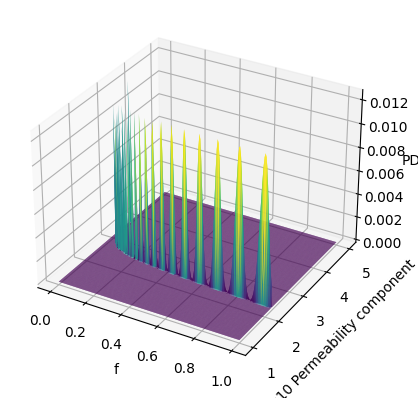

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming x, y, z are your data arrays
x = results[f'f_{idx}']
y = np.log10(results[f'Fluid perm_{idx}'])
z = results['p(Ai|b)']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a surface
surf = ax.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)

# Set labels and title
ax.set_xlabel('f')
ax.set_ylabel('Lg10 Permeability component')
ax.set_zlabel('PDF')

plt.show()

### Permeability direct

In [ ]:
path_to_ser = Path('/content/f model.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='Лист1 (2)', skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
# filtered_data = data[data[f"total diff {prop}"] < 20]
data = data.sort_values(by=f"Porosity,%")
data = data[(data[f"Porosity,%"] < 7) & (data[f"Porosity,%"] >= 0)]
data.dropna(subset=['Porosity,%',"crack porosity" ], inplace=True)

In [ ]:
data

Sample Well  \
27  129817.0    b   
26  129750.0    b   
25  129744.0    b   
0   113480.0    a   
32  129914.0    b   
1   113532.0    a   
9   113603.0    a   
28  129822.0    b   

                                                                                                          Litholohy  \
27  трещинноватый, открытые и полуоткрытые трещины, выполненны открыто и запеченные в глинисто-сульфидном материале   
26                                             пористый, неравномерное распределение пористости и каверн по образцу   
25                                 пористо-кавернозный, неравномерное распределение  пористости и каверн по образцу   
0                                               пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины   
32                                                      пористо-кавернозный, на торцах присутствуют большие каверны   
1                                                                                               пористо-кавернозный   
9                   пористо-кавернозный, частично перекристаллизованный, неравномерная пористость, открытые трещины   
28                                             частичная перекристаллизация, пористость распределенна неравномерно,   

    Porosity,%  Permeability  Density (air)  Density (water)  Density (oil)    Vp air    Vs air  \
27    1.471150      0.016947       2.671899         2.662024       2.663264  4.881000  2.794000   
26    2.162350      0.021934       2.654578         2.638584       2.640757  4.984000  2.876000   
25    3.731300      0.430094       2.608594         2.537846       2.600607  4.817000  2.822000   
0     4.524900      0.832741       2.562685         2.572247       2.576227  5.037000  2.360000   
32    5.877850      0.491424       2.546632         2.498266       2.536095  5.013000  2.883000   
1     6.473371      0.253703       2.532158         2.537162       2.529374  4.042333  2.427667   
9     6.812695      0.399309       2.543359         2.538758       2.535101  4.065667  2.212000   
28    6.934715      2.148710       2.526148         2.525200       2.516316  4.897667  2.757333   

      Vp oil    Vs oil  Vp water  Vs water  Unnamed: 15  AR thermal  AO electrical  AR elastic  \
27  5.958540  3.269995    5.5680    2.9540          NaN    0.022491       0.030200        0.13   
26  5.919150  3.195955    5.6740    2.9915          NaN    0.091201       0.144544        0.03   
25  5.686820  3.238515    5.3600    2.8930          NaN    0.107647       0.055804        0.09   
0   5.564425  3.019440    5.2945    2.6495          NaN    0.066681       0.069183        0.06   
32  5.491510  2.945640    5.4025    2.9025          NaN    0.096383       0.094044        0.10   
1   5.173550  2.849075    5.0545    2.6650          NaN    0.134276       0.087096        0.07   
9   5.177195  2.813970    4.9000    2.4710          NaN    0.158489       0.069183        0.09   
28  5.374120  3.091910    5.2115    2.7795          NaN    0.131826       0.100000        0.19   

    Unnamed: 19    TC air    TC oil    TC 0,6      TC 6     TC 60    TC 180 Скважина        R 0,6  \
27          NaN  2.659425  2.836890       NaN  2.907188  2.914938  3.024933        b          NaN   
26          NaN  2.703512  2.817384       NaN  2.871125  2.848937  2.962650        b          NaN   
25          NaN  2.598375  2.715150       NaN  2.810875  2.798112  2.879308        b          NaN   
0           NaN  2.472888  2.668885       NaN  2.740225  2.966438  2.852613        a          NaN   
32          NaN  2.498588  2.578681  2.691438  2.740613  2.661575  2.792800        b  1789.444046   
1           NaN  2.404575  2.600888  2.745500  2.741125  2.857375  2.834588        a  1045.156958   
9           NaN  2.342800  2.721150  2.935987  2.931388  2.992612  3.003312        a   860.296556   
28          NaN  2.415300  2.605161  2.858213  2.781475  2.809700  2.872242        b  1132.333683   

           R 6       R 60      R 180  R 0,6.1     R 6.1    

In [ ]:
porosity = data["Porosity,%"][0:len(data)+1]
print(len(porosity))
exp_permeability = data["Permeability"][0:len(data)+1]
# ar_pore_initial = data['AR thermal']
# ar_pore = data['AR thermal']
AR_cracks = data["AR inclusion"][0:len(data)+1]
cracks_porosity = data["crack porosity"][0:len(data)+1]
f_array = data["f"]
f = 0.5*10**-3


TC_array = data['TC air'][0:32] / ([2.95] * len(data["Porosity,%"][0:32]))
mtrx_perm = 2*10**-4
# fluid_comp =
# fluid_perm = 10**2.8
# f = 0.3

import math
calculation_perm =[]

# table = pd.DataFrame()
# table['f mean'] = all_means_f
# table['porosity'] = all_porosity
# table['K i'] = all_means_i


for ar_cracks, por, cracks_por, TC in zip(AR_cracks, porosity, cracks_porosity, TC_array):

  if math.isnan(cracks_por):
    pass

  else:
    por = por/100
    AR_pore = AR_mtrx = 1.0

    # cracks_por = 0.0001 * (por*100) ** 1.862

    cracks_por = -0.0696 * TC + 0.0629

    if cracks_por < 0:
      cracks_por = 10**-4


    ar_cracks = 0.0574 * cracks_por ** 0.5235
    conc = [1-por, por-cracks_por, cracks_por]


    alpha_shape = [AR_mtrx, AR_pore, ar_cracks]

    # fluid_perm = 10**(1.7*np.log(por*100)-0.6603)
    # f = 0.026
    fluid_perm = 10**(2.644 * np.exp(0.0361*(por*100)))


    components = [mtrx_perm, fluid_perm, fluid_perm]
    # f = f_from_e(por*100, ar)
    print(alpha_shape)
    calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))

8
[1.0, 1.0, 0.0005826783934839814]
[1.0, 1.0, 0.00046228722524826435]
[1.0, 1.0, 0.0019710370134248664]
[1.0, 1.0, 0.003413590501573819]
[1.0, 1.0, 0.003167716271316846]
[1.0, 1.0, 0.004000043481275726]
[1.0, 1.0, 0.004469803241162415]
[1.0, 1.0, 0.003913285545651757]


In [ ]:
results = pd.DataFrame()
results['Sample'] = data["Sample"][0:len(data)+1]
results['Porosity'] = data["Porosity,%"][0:len(data)+1]
results['Calculatioin perm log'] = (calculation_perm)[0:len(data)+1]
results['Expermental perm log'] = data["Permeability"][0:len(data)+1]
results['Expermental'] = np.log10(exp_permeability)[0:len(data)+1]
results['Calculatioin perm'] = np.log10(calculation_perm)[0:len(data)+1]
results['Expermental'] = np.log10(data["Permeability"][0:len(data)+1])


results['Abs Error'] = np.abs((results['Calculatioin perm'] - results['Expermental'])/results['Expermental']*100)
results['Relative Error'] = np.abs((results['Calculatioin perm'] - results['Expermental']) / results['Expermental']) * 100

In [ ]:
globals()[f'final_{f}'] = pd.DataFrame()
globals()[f'final_{f}']['Sample'] = results['Sample']
globals()[f'final_{f}']['Porosity'] = results['Porosity']
globals()[f'final_{f}'][f'Expermental_{f}'] = results['Expermental']
globals()[f'final_{f}'][f'Calculatioin_perm_{f}'] = results['Calculatioin perm']

In [ ]:
globals()[f'final_{f}']

Sample  Porosity  Expermental_0.0005  Calculatioin_perm_0.0005
27  129817.0  1.471150           -1.770917                 -1.497412
26  129750.0  2.162350           -1.658880                 -1.454491
25  129744.0  3.731300           -0.366437                 -0.636720
0   113480.0  4.524900           -0.079490                 -0.309282
32  129914.0  5.877850           -0.308544                 -0.160387
1   113532.0  6.473371           -0.595674                  0.009993
9   113603.0  6.812695           -0.398691                  0.098534
28  129822.0  6.934715            0.332178                  0.064414

[]

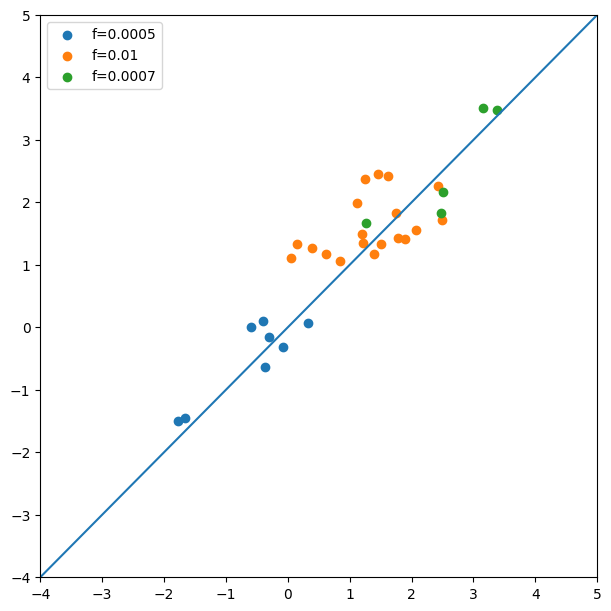

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(6, 6))
ax = fig5.subplots(1, 1, sharex=True)

f = 0.5*10**-3
data = globals()[f'final_{f}']
plt.scatter(data[f'Expermental_{f}'], data[[f'Calculatioin_perm_{f}']], label=f'f={f}')

f = 10**-2
data = globals()[f'final_{f}']
plt.scatter(data[f'Expermental_{f}'], data[[f'Calculatioin_perm_{f}']], label=f'f={f}')

f = 0.7*10**-3
data = globals()[f'final_{f}']
plt.scatter(data[f'Expermental_{f}'], data[[f'Calculatioin_perm_{f}']], label=f'f={f}')

ax.set_xlim([-4, 5])
ax.set_ylim([-4, 5])

ax.plot([-4, 5], [-4, 5])
plt.legend()

plt.plot()